# Project Title:  
The following notebook is an overall analysis of the custom DensnetWithHead model performance over the CheXpert database
### Setup and Configuration:


1. [[T]raining]  
run  
```CUDA_VISIBLE_DEVICES=0  python main.py fit -c ./configs/chexpert_all.yaml```  
> Results:  
 model trained results as .ckpt files with the best loss for each epoch located at ```~/fairness_on_embeddings/results/chexpert_all/checkpoints```

2. [testing]  
2.1 [testing] over ***[[v]alidation set]*** 

    1. make the appropriate changes int the config file like ```./configs/chexpert_all.yaml``` to run ***"val"*** instead of "test"
    2. run  
    ```CUDA_VISIBLE_DEVICES=0  python main.py predict -c ./configs/mimic_base_NoFinding_syn_age.yaml --ckpt_path /local/home/rezajam/fairness_on_embeddings/results/mimic_base_NoFinding_syn_age/checkpoints/best_val_loss-epoch=03-val_loss=0.4604.ckpt```  
    > Results:  
    prediction labels ***(```labels_val.py```)***, & prediction probabilities ***(``probabilities_val.py``)*** from [v]alidation set,  
    located at ```~/fairness_on_embeddings/results/chexpert_all/probabilities```
    

    
    2.2 [testing] over ***[[testing] set]***  
    1. make the appropriate changes int the config file like ```./configs/chexpert_all.yaml``` to run ***"test"*** instead of "val"
    2. run  
    ```CUDA_VISIBLE_DEVICES=0  python main.py predict -c ./configs/mimic_base_NoFinding_syn_age.yaml --ckpt_path /local/home/rezajam/fairness_on_embeddings/results/mimic_base_NoFinding_syn_age/checkpoints/best_val_loss-epoch=03-val_loss=0.4604.ckpt```  
    > Results:  
    prediction labels ***(```labels_test.py```)***, & prediction probabilities ***(``probabilities_test.py``)*** from [testing] set, located at ```~/fairness_on_embeddings/results/chexpert_all/probabilities```

below is ran with modifications in ```./configs/chexpert_all.yaml```:  
. ```${trainer.max_epochs}: 5 ```
 
. ```${trainer.....save_top_k}: 3```


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


### Data Loading:  

we extract all the results of labels and probabilites from the validation set domain and athe ones from the testing set domain

In [13]:
# ---------------------------------------------------------------------------- #
#                             validation set domain                            #
# ---------------------------------------------------------------------------- #
print("----------------------------------------------[ labels from [V]alidation set ]------------------------------------------------")
grandtruth_labels_val = np.load('/local/home/rezajam/fairness_on_embeddings/results/mimic_base_NoFinding_syn_age/probabilities/labels_val.npy')



print(f"grandtruth_labels:\n{grandtruth_labels_val[:5]}")
print("Shape of the grandtruth_labels:", grandtruth_labels_val.shape)
print("grandtruth_labels type:", grandtruth_labels_val.dtype)


print("----------------------------------------------[ probabilites from [V]alidation set ]------------------------------------------------")
# Replace 'your_file.npy' with the path to your .npy file
predicted_probabilities_val = np.load('/local/home/rezajam/fairness_on_embeddings/results/mimic_base_NoFinding_syn_age/probabilities/probabilities_val.npy')


print(f"predicted_probabilities in validation set:\n{predicted_probabilities_val[:5]}")
print("Shape of the predicted_probabilities:", predicted_probabilities_val.shape)
print("predicted_probabilities type:", predicted_probabilities_val.dtype)






# ---------------------------------------------------------------------------- #
#                              testing set domain                              #
# ---------------------------------------------------------------------------- #
print("----------------------------------------------[ labels from [testing] set ]------------------------------------------------")
labels_test = np.load('/local/home/rezajam/fairness_on_embeddings/results/mimic_base_NoFinding_syn_age/probabilities/labels_test.npy')
print(f"labels_test:\n{labels_test[:5]}")
print("Shape of the labels_test:", labels_test.shape)
print("labels_test type:", labels_test.dtype)


print("----------------------------------------------[ probabilites from [testing] set ]------------------------------------------------")
pp_test = np.load('/local/home/rezajam/fairness_on_embeddings/results/mimic_base_NoFinding_syn_age/probabilities/probabilities_test.npy')
print(f"predicted_probabilities in testing set:\n{pp_test[:5]}")
print("Shape of the predicted_probabilities in testing set:", pp_test.shape)
print("predicted_probabilities type:", pp_test.dtype)

----------------------------------------------[ labels from [V]alidation set ]------------------------------------------------
grandtruth_labels:
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
Shape of the grandtruth_labels: (37958, 1)
grandtruth_labels type: float32
----------------------------------------------[ probabilites from [V]alidation set ]------------------------------------------------
predicted_probabilities in validation set:
[[0.25856164]
 [0.04967381]
 [0.20161463]
 [0.01384848]
 [0.08707734]]
Shape of the predicted_probabilities: (37958, 1)
predicted_probabilities type: float32
----------------------------------------------[ labels from [testing] set ]------------------------------------------------
labels_test:
[[0.]
 [0.]
 [1.]
 [1.]
 [1.]]
Shape of the labels_test: (37648, 1)
labels_test type: float32
----------------------------------------------[ probabilites from [testing] set ]------------------------------------------------
predicted_probabilities in testing set:
[[0.50199896]

Having a list of names of label names for plots

In [14]:
label_names = [
    "No Finding"
]

## ⚙️ Functions

### ⚙️ Define a classification report function

In [15]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def get_metrics(y_true, y_pred):
    return confusion_matrix(y_true, y_pred), accuracy_score(y_true, y_pred), precision_score(y_true, y_pred), recall_score(y_true, y_pred), f1_score(y_true, y_pred)


In [16]:
len(label_names)

1

### ⚙️🔢 **Confusion Matrix Functions**

#### ⚙️🔢 Define confusion matrix plot function

In [17]:
# Single-label version of plot_confusion_matrices
def plot_confusion_matrices(y_true, y_pred, title):
    fig, ax = plt.subplots(figsize=(5, 5))

    # Compute confusion matrix and metrics with zero_division=0 for precision and recall
    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'],
                cbar=True, ax=ax)
    
    ax.set_title(f'[{label_names}] in {title} Patients')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

    # Add metrics as text below the confusion matrix plot
    metrics_text = (f"Accuracy: {accuracy:.4f}\n"
                    f"Precision: {precision:.4f}\n"
                    f"Recall: {recall:.4f}\n"
                    f"F1-Score: {f1:.4f}")
    ax.text(0.5, -0.3, metrics_text, ha='center', va='top', fontsize=12, transform=ax.transAxes)

    # Adjust layout to avoid overlap
    plt.tight_layout()
    plt.show()

#### ⚙️🔢🔢🔴🟢 Compare Confusion Matrix with colors functions:

these are solely for visual purposes!

This function generates dual ROC curves with color-coded indicators to highlight metrics changes across two criteria, such as comparing metrics between groups (e.g., male vs. female). Green (🟢) denotes an improvement in metrics, while red (🔴) indicates a decline.

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

def compare_confusion_matrices(grandtruth_labels1, predicted_labels1, title1, 
                               grandtruth_labels2, predicted_labels2, title2):
    
    # subplots         (2 rows, columns equal to number of labels)
    fig, axes = plt.subplots(2, len(label_names), figsize=(len(label_names)*4, 10))

    # 1 loop over each label to plot its confusion matrix for both sets
    for label_idx in range(len(label_names)):
        # (top row) metrics
        y_true1 = np.argmax(grandtruth_labels1, axis=1)
        y_pred1 = np.argmax(predicted_labels1, axis=1)
        # y_true1 = grandtruth_labels1[:, label_idx]
        # y_pred1 = predicted_labels1[:, label_idx]
        cm1, accuracy1, precision1, recall1, f11 = get_metrics(y_true1, y_pred1)

        # (top row) confusion matrix
        sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Predicted 0', 'Predicted 1'],
                    yticklabels=['Actual 0', 'Actual 1'],
                    cbar=True, ax=axes[0, label_idx])
        
        # (top row) title and labels
        axes[0, label_idx].set_title(f'[{label_names[label_idx]}] in {title1} Patients')
        axes[0, label_idx].set_xlabel('Predicted')
        axes[0, label_idx].set_ylabel('Actual')
        


        
        # (bottom row) metrics
        y_true2 = np.argmax(grandtruth_labels2, axis=1)
        y_pred2 = np.argmax(predicted_labels2, axis=1)
        # y_true2 = grandtruth_labels2[:, label_idx]
        # y_pred2 = predicted_labels2[:, label_idx]
        cm2, accuracy2, precision2, recall2, f12 = get_metrics(y_true2, y_pred2)

        # (bottom row) confusion matrix
        sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Predicted 0', 'Predicted 1'],
                    yticklabels=['Actual 0', 'Actual 1'],
                    cbar=True, ax=axes[1, label_idx])
        
        # (bottom row) title and labels
        axes[1, label_idx].set_title(f'[{label_names[label_idx]}] in {title2} Patients')
        axes[1, label_idx].set_xlabel('Predicted')
        axes[1, label_idx].set_ylabel('Actual')



        #---------- COLOR ----------
        # (top row) Color based on metrics comparison
        accuracy_color1 = 'green' if accuracy1 > accuracy2 else 'red'
        precision_color1 = 'green' if precision1 > precision2 else 'red'
        recall_color1 = 'green' if recall1 > recall2 else 'red'
        f1_color1 = 'green' if f11 > f12 else 'red'
        # (bottom row) Color reversed
        accuracy_color2 = 'green' if accuracy_color1 == 'red' else 'red'
        precision_color2 = 'green' if precision_color1 == 'red' else 'red'
        recall_color2 = 'green' if recall_color1 == 'red' else 'red'
        f1_color2 = 'green' if f1_color1 == 'red' else 'red'
        #---------- COLOR ----------

        #---------- text -----------
        # (top row) metrics text below confusion matrix with color
        axes[0, label_idx].text(0.5, -0.3, f"Accuracy: {accuracy1:.4f}", color=accuracy_color1, ha='center', va='top', fontsize=12, transform=axes[0, label_idx].transAxes)
        axes[0, label_idx].text(0.5, -0.4, f"Precision: {precision1:.4f}", color=precision_color1, ha='center', va='top', fontsize=12, transform=axes[0, label_idx].transAxes)
        axes[0, label_idx].text(0.5, -0.5, f"Recall: {recall1:.4f}", color=recall_color1, ha='center', va='top', fontsize=12, transform=axes[0, label_idx].transAxes)
        axes[0, label_idx].text(0.5, -0.6, f"F1-Score: {f11:.4f}", color=f1_color1, ha='center', va='top', fontsize=12, transform=axes[0, label_idx].transAxes)

        # (bottom row) metrics text below confusion matrix with color
        axes[1, label_idx].text(0.5, -0.3, f"Accuracy: {accuracy2:.4f}", color=accuracy_color2, ha='center', va='top', fontsize=12, transform=axes[1, label_idx].transAxes)
        axes[1, label_idx].text(0.5, -0.4, f"Precision: {precision2:.4f}", color=precision_color2, ha='center', va='top', fontsize=12, transform=axes[1, label_idx].transAxes)
        axes[1, label_idx].text(0.5, -0.5, f"Recall: {recall2:.4f}", color=recall_color2, ha='center', va='top', fontsize=12, transform=axes[1, label_idx].transAxes)
        axes[1, label_idx].text(0.5, -0.6, f"F1-Score: {f12:.4f}", color=f1_color2, ha='center', va='top', fontsize=12, transform=axes[1, label_idx].transAxes)
        #---------- text -----------


    plt.tight_layout()
    plt.show()


### ⚙️ Apply threshold  

#### 1. Labels([v]alid) + Probabilites([v]alid) ➡️  find_best_threshold ➡️ The best threshold 

The Label and Predicted Probabilities are both from [V]alidation dataset.  
The threshold found from the function, will be the ***only threshold*** for the rest of the analysis




In [20]:
# ---------------------------------------------------------------------------- #
#                     GL + PP ==> find_best_threshold ==> T                    #
# ---------------------------------------------------------------------------- #
# grandtruth_labels_val = np.load('/local/home/rezajam/fairness_on_embeddings/results/chexpert_all/probabilities/labels_val.npy')
# predicted_probabilities_val = np.load('/local/home/rezajam/fairness_on_embeddings/results/chexpert_all/probabilities/probabilities_val.npy')

from metrics.metrics import calculate_roc_auc, find_best_threshold
thresholds = find_best_threshold(predicted_probabilities_val, grandtruth_labels_val )
print(f"thresholds\n{thresholds}")

thresholds
{0: 0.33321267}


#### 2. Probability(testing) >= Best Threshold ➡️ predicted labels  
note that for the rest of the analysis every evaluation will be over the ***testing set***.



In [21]:
# # ---------------------------------------------------------------------------- #
# #                               apply_thresholds                               #
# # ---------------------------------------------------------------------------- #

def apply_thresholds(pp_test, thresholds):
    # Initialize predicted_labels as an array of zeros with the same shape as pp_test
    predicted_labels = np.zeros_like(pp_test, dtype=float)

    # # Validate thresholds: Ensure that all threshold values are between 0 and 1
    # for label, threshold in thresholds.items():
    #     if not (0 <= threshold <= 1):
    #         raise ValueError(f"Threshold for label {label} is out of range: {threshold}. Must be between 0 and 1.")
    
    # Apply thresholds to pp_test to get binary predictions
    for idx, label in enumerate(thresholds.keys()):
        predicted_labels[:, idx] = (pp_test[:, idx] >= thresholds[label])
         
    return predicted_labels



### ⚙️📈 **ROC Curve Functions**

#### ⚙️ get FPR and TPR function for ROC curve  
🔴 While it remains essential to retain the full range of FPR and TPR values across all existing thresholds for plotting the ROC,  
it is also important to note that the optimal threshold obtained enables us to identify the corresponding best FPR and TPR for each predicted label.  
This approach provides a comprehensive evaluation of each label individually.


In [23]:
from metrics.metrics import calculate_fpr_fnr
# ------------------------------- tpr = 1 - fnr ------------------------------ #
def fnr_to_tpr(fnr):
    if fnr:
        tpr = fnr
        for i in fnr:
            tpr[i] = 1 - fnr[i]
        return tpr
    


def fpr_tpr_auc(predicted_probabilities, grandtruth_labels, thresholds):
    # fpr , tpr for ALL  THRESHOLDS
    fpr_overall, tpr_overall, AUC = calculate_roc_auc(predicted_probabilities, grandtruth_labels)

    # fpr , fnr(= 1 - tpr ) for BEST THRESHOLDS
    fpr, fnr = calculate_fpr_fnr(predicted_probabilities, grandtruth_labels, thresholds)
    tpr = fnr_to_tpr(fnr)

    return fpr, tpr, fpr_overall, tpr_overall, AUC

    # print(f"fpr: {fpr}\n")
    # print(f"tpr: {tpr}\n")
    # print(f"fpr_overall: {fpr_overall}\n")
    # print(f"tpr_overall: {tpr_overall}\n")
    # print(f"AUC: {AUC}\n")

# fpr, tpr, fpr_overall, tpr_overall, AUC = fpr_tpr_auc(predicted_probabilities_val, grandtruth_labels_val, thresholds)
fpr, tpr, fpr_overall, tpr_overall, AUC = fpr_tpr_auc(pp_test, labels_test, thresholds)

In [24]:
print(f"AUC:\n{AUC}")

AUC:
{0: 0.8544297001746335}


#### ⚙️ 📈 The ROC plot function


In [25]:
from sklearn.metrics import RocCurveDisplay

def plot_rocs(fpr, tpr, fpr_overall, tpr_overall, AUC, title):

    fig, axes = plt.subplots(1, len(AUC), figsize=(len(AUC)* 5, len(AUC)* 10))
    for label_idx in range(len(AUC)):
        roc_display = RocCurveDisplay(fpr=fpr_overall[label_idx], tpr=tpr_overall[label_idx])
        roc_display.plot(ax=axes[label_idx])
        # roc_display.plot()
        # Set title and axis labels

        #           plt.title(f"ROC Curve for Label {label_idx}")
        axes[label_idx].set_title(f"ROC Curve for Label [{label_names[label_idx]}] in {title} Patients")
        axes[label_idx].set_xlabel("False Positive Rate (1-Specificity)")
        axes[label_idx].set_ylabel("True Positive Rate (Sensitivity)")

        metrics_text = f"Best threshold: {thresholds[label_idx]:.4f}\n" \
                       f"FPR: {fpr[label_idx]:.4f}\n" \
                       f"TPR: {tpr[label_idx]:.4f}\n" \
                       f"AUC : {AUC[label_idx]:.4f}"

        # Place the text on the plot (adjust coordinates as needed)
        axes[label_idx].text(0.5, 0.1, metrics_text, fontsize=12, bbox=dict(facecolor='white', alpha=1))



    plt.tight_layout()
    plt.show()



#### ⚙️📈📈🔴🟢 Compare ROC curves with colors functions:

these are solely for visual purposes!

This function generates dual ROC curves with color-coded indicators to highlight performance changes across two criteria, such as comparing metrics between groups (e.g., male vs. female). Green (🟢) denotes an improvement in performance, while red (🔴) indicates a decline.

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

def compare_rocs_colored(fpr1, tpr1, fpr_overall1, tpr_overall1, AUC1,
                           fpr2, tpr2, fpr_overall2, tpr_overall2, AUC2,
                           thresholds, label_text1, label_text2):
    
    # first get the # of labels we are dealing with
    num_labels = len(thresholds)
    
    # [GRID]
    # Set up a figure with subplots arranged in rows (one for each class) and two columns (one for each set of AUCs)
    fig, axes = plt.subplots(num_labels, 2, figsize=(12, num_labels * 3))
    #                  6(Labels)(Rows) x 2(Male/Female)(Cols) ROCs
    
    for label_idx in range(num_labels):
        # Plot the ROC curve for the first set of fpr/tpr values in the first column (ex: Male ROCs)
        roc_display1 = RocCurveDisplay(fpr=fpr_overall1[label_idx], tpr=tpr_overall1[label_idx])
        # if num_labels > 1:
        #       ax1 = axes[label_idx, 0] 
        # else:
        #       ax1 = axes[0]
        # [GRID]: colmn label, in 1st colmn
        ax1 = axes[label_idx, 0] 
        roc_display1.plot(ax=ax1)
        ax1.set_title(f"[{label_names[label_idx]}] for {label_text1} patients ")
        ax1.set_xlabel("False Positive Rate (1-Specificity)")
        ax1.set_ylabel("True Positive Rate (Sensitivity)")
        # ----------------------------------- color ---------------------------------- #
        # Color-code FPR, TPR, and AUC based on comparison with other ROC's (ex: Female ROCs) metrics
        # the bigger the FPR the Worse (red)
        fpr_color1 = 'red' if fpr1[label_idx] > fpr2[label_idx] else 'green'

        tpr_color1 = 'green' if tpr1[label_idx] > tpr2[label_idx] else 'red'
        auc_color1 = 'green' if AUC1[label_idx] > AUC2[label_idx] else 'red'
        # ----------------------------------- color ---------------------------------- #
        # Display each metric with its respective color, with added spacing
        ax1.text(0.6, 0.4, f"Best threshold: {thresholds[label_idx]:.4f}", fontsize=10, bbox=dict(facecolor='white', alpha=1), transform=ax1.transAxes)
        ax1.text(0.6, 0.3, f"FPR: {fpr1[label_idx]:.4f}", color=fpr_color1, fontsize=10, bbox=dict(facecolor='white', alpha=1), transform=ax1.transAxes)
        ax1.text(0.6, 0.2, f"TPR: {tpr1[label_idx]:.4f}", color=tpr_color1, fontsize=10, bbox=dict(facecolor='white', alpha=1), transform=ax1.transAxes)
        ax1.text(0.6, 0.1, f"AUC: {AUC1[label_idx]:.4f}", color=auc_color1, fontsize=10, bbox=dict(facecolor='white', alpha=1), transform=ax1.transAxes)
        
        
        
        # Plot the ROC curve for the second set of fpr/tpr values in the second column (ex: Female ROCs)
        roc_display2 = RocCurveDisplay(fpr=fpr_overall2[label_idx], tpr=tpr_overall2[label_idx])
        # if num_labels > 1:
        #       ax2 = axes[label_idx, 1] 
        # else:
        #       ax2 = axes[1]
        # [GRID]: colmn label, in 2nd colmn
        ax2 = axes[label_idx, 1]
        roc_display2.plot(ax=ax2)
        ax2.set_title(f"[{label_names[label_idx]}] for {label_text2} patients ")
        ax2.set_xlabel("False Positive Rate (1-Specificity)")
        ax2.set_ylabel("True Positive Rate (Sensitivity)")
        # ----------------------------------- color ---------------------------------- #
        # colors switched 
        fpr_color2 = 'green' if fpr_color1 == 'red' else 'red'
        tpr_color2 = 'green' if tpr_color1 == 'red' else 'red'
        auc_color2 = 'green' if auc_color1 == 'red' else 'red'
        # fpr_color2 = 'green' if fpr1[label_idx] > fpr2[label_idx] else 'red'
        # tpr_color2 = 'red' if tpr1[label_idx] > tpr2[label_idx] else 'green'
        # auc_color2 = 'red' if AUC1[label_idx] > AUC2[label_idx] else 'green'
        # ----------------------------------- color ---------------------------------- #
        ax2.text(0.6, 0.4, f"Best threshold: {thresholds[label_idx]:.4f}", fontsize=10, bbox=dict(facecolor='white', alpha=1), transform=ax2.transAxes)
        ax2.text(0.6, 0.3, f"FPR: {fpr2[label_idx]:.4f}", color=fpr_color2, fontsize=10, bbox=dict(facecolor='white', alpha=1), transform=ax2.transAxes)
        ax2.text(0.6, 0.2, f"TPR: {tpr2[label_idx]:.4f}", color=tpr_color2, fontsize=10, bbox=dict(facecolor='white', alpha=1), transform=ax2.transAxes)
        ax2.text(0.6, 0.1, f"AUC: {AUC2[label_idx]:.4f}", color=auc_color2, fontsize=10, bbox=dict(facecolor='white', alpha=1), transform=ax2.transAxes)

    plt.tight_layout()
    plt.show()


#### ⚙️📈📈📈  ***Big Picture*** ROC curves:  

This is used for graphs of many labels over many attributes of data (like age-groups)


In [27]:
def plot_roc_bigpicture(pp_groups, label_groups, title):
    # Determine the number of labels and age groups
    num_labels = len(thresholds)
    num_age_groups = len(pp_groups)

    # Set up the subplots grid for labels x age groups
    fig, axes = plt.subplots(num_labels, num_age_groups, figsize=(20, num_labels * 3))

    # Loop through each label index
    for label_idx in range(num_labels):
        # Loop through each age group
        for col_idx, age_range in enumerate(pp_groups):
            # Calculate FPR, TPR, and AUC for the current age range and label
            fpr, tpr, fpr_overall, tpr_overall, AUC = fpr_tpr_auc(pp_groups[age_range], label_groups[age_range], thresholds)
            
            # Plot ROC curve for this label and age group
            roc_display = RocCurveDisplay(fpr=fpr_overall[label_idx], tpr=tpr_overall[label_idx])
            ax = axes[label_idx, col_idx] if num_labels > 1 else axes[col_idx]
            roc_display.plot(ax=ax)
            
            # Set titles and axis labels
            ax.set_title(f"[{label_names[label_idx]}] in {title} Patients aged {age_range}")
            ax.set_xlabel("False Positive Rate (1-Specificity)")
            ax.set_ylabel("True Positive Rate (Sensitivity)")
            
            # Display threshold, FPR, TPR, and AUC for the label
            metrics_text = f"Best threshold: {thresholds[label_idx]:.4f}\n" \
                           f"FPR: {fpr[label_idx]:.4f}\n" \
                           f"TPR: {tpr[label_idx]:.4f}\n" \
                           f"AUC : {AUC[label_idx]:.4f}"
            ax.text(0.5, 0.1, metrics_text, fontsize=10, bbox=dict(facecolor='white', alpha=1), transform=ax.transAxes)

    # Adjust layout and display plot
    plt.tight_layout()
    plt.show()

# **MIMIC + 1% Synthetic Report**:  
from final_mimic_chexpert_all.yaml  

run 


In [ ]:
# CUDA_VISIBLE_DEVICES=0 python main.py fit -c ./configs/final_mimic_01_syn_all.yaml

After Training is done -> you got Checkpoint file/s  

run

In [ ]:
# CUDA_VISIBLE_DEVICES=1 python main.py predict -c ./configs/final_mimic_01_syn_all.yaml --ckpt_path /local/.......# CUDA_VISIBLE_DEVICES=0 python main.py predict -c ./configs/final_mimic_chexpert_all.yaml --ckpt_path /local/.......

After Training  
Get labels and probabilites for test and valid

## **DEBUG**:

Labels size: 37648
Testing dataset size: 37648
Labels size: 37648
Testing dataset size: 37648


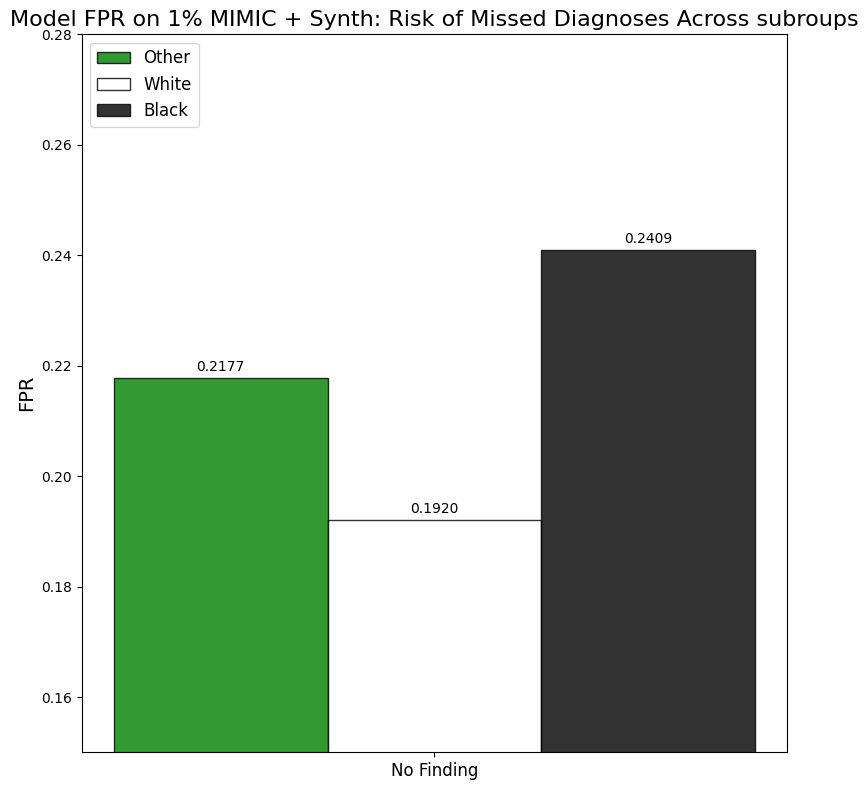

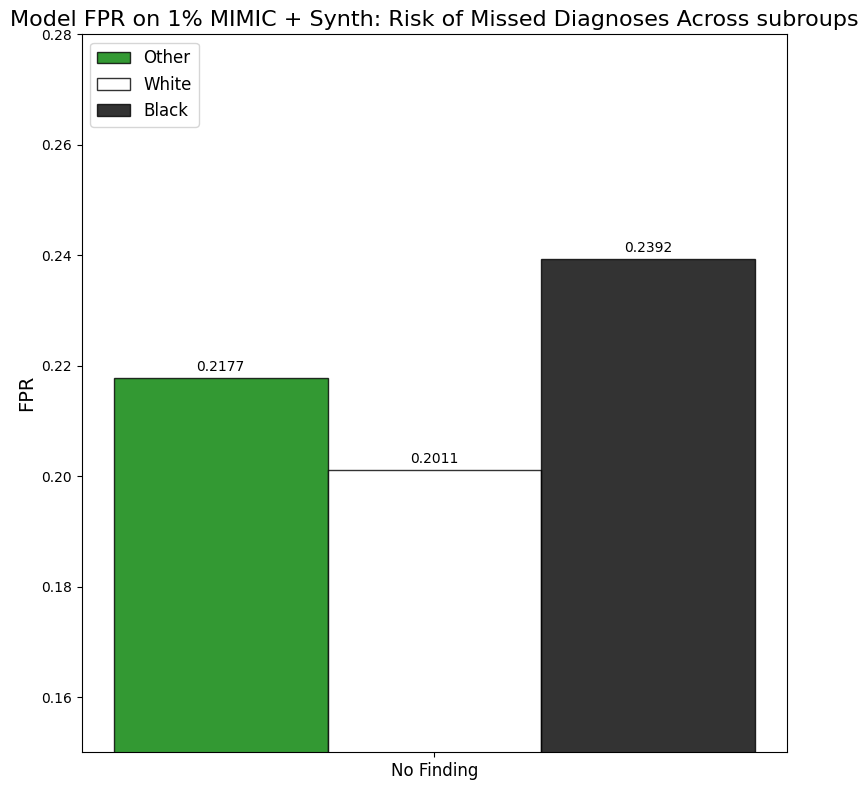

({0: 0.16464064832586905,
  1: 0.11787254432199329,
  2: 0.0933527945022198,
  3: 0.2081650635142081,
  4: 0.09373631187034603,
  5: 0.23924406915963006},
 0.23924406915963006)

In [2]:
# ---------------------------------------------------------------------------- #
#                                                                              #
#                                  [[[ FPR ]]]                                 #
#                                                                              #
# ---------------------------------------------------------------------------- #

# CUDA_VISIBLE_DEVICES=0 python main.py predict -c ./configs/final_mimic_real_all.yaml --ckpt_path /local/home/rezajam/fairness_on_embeddings/results/final_mimic_real_all/checkpoints/best_val_loss-epoch=02-val_loss=0.3401.ckpt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score
from metrics.metrics import calculate_roc_auc,find_best_threshold, calculate_fpr_fnr

# # ---------------------------------------------------------------------------- #
# #                               plot_auc_barchart                              #
# # ---------------------------------------------------------------------------- #
import matplotlib.pyplot as plt
import numpy as np

def plot_auc_barchart(auc_all, auc_white, auc_black, label_names):
    """
    Plots a bar chart comparing AUCs for Total, White, and Black groups for each disease label.

    Parameters:
    - auc_all: List of AUCs for the total population.
    - auc_white: List of AUCs for the White group.
    - auc_black: List of AUCs for the Black group.
    - label_names: List of disease labels.
    """
    n_labels = len(label_names)
    x = np.arange(n_labels)  # Label positions on x-axis

    # Bar width
    width = 0.25
    # width = 0.5

    # Create the figure and axes
    fig, ax = plt.subplots(figsize=(8, 8))  # Increase figure size for better visibility

    # Plot bars for each group
    bars_all = ax.bar(x - width, auc_all, width, label='Other', alpha=0.8, color="green", edgecolor="black")
    bars_white = ax.bar(x, auc_white, width, label='White', alpha=0.8, color="white", edgecolor="black")
    bars_black = ax.bar(x + width, auc_black, width, label='Black', alpha=0.8, color="black", edgecolor="black")

    # Add labels to the bars
    ax.bar_label(bars_all, fmt='%.4f', padding=3)
    ax.bar_label(bars_white, fmt='%.4f', padding=3)
    ax.bar_label(bars_black, fmt='%.4f', padding=3)

    # Add labels, title, and legend
    # ax.set_xlabel("Disease Labels", fontsize=14)
    ax.set_ylabel("FPR", fontsize=14)
    ax.set_title("Model FPR on 1% MIMIC + Synth: Risk of Missed Diagnoses Across subroups", fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(label_names, fontsize=12)
    ax.legend(loc='upper left', fontsize=12)

    # Adjust y-axis range to zoom in on differences
    # ax.set_ylim(0.8, 1.0) #For more than 1 epochs
    ax.set_ylim(0.15, 0.28) #For 1 epoch

    

    # Display the plot
    plt.tight_layout()
    plt.show()


# ---------------------------------------------------------------------------- #
#                                                                              #
#                                  [ THE CODE ]                                #
#                                                                              #
# ---------------------------------------------------------------------------- #

exp_type = "final_mimic_01_syn_all"
labels_val = np.load(f'/local/home/rezajam/fairness_on_embeddings/results/{exp_type}/probabilities/labels_val.npy')
pp_val = np.load(f'/local/home/rezajam/fairness_on_embeddings/results/{exp_type}/probabilities/probabilities_val.npy')
labels_test = np.load(f'/local/home/rezajam/fairness_on_embeddings/results/{exp_type}/probabilities/labels_test.npy')
pp_test = np.load(f'/local/home/rezajam/fairness_on_embeddings/results/{exp_type}/probabilities/probabilities_test.npy')

label_names = [
    "Cardiomegaly"
    ,"Edema"
    ,"Consolidation"
    ,"Atelectasis"
    ,"Pleural Effusion"
    ,"No Finding"
]

# ---------------------------------------------------------------------------- #
#                                 get Threshold                                #
# ---------------------------------------------------------------------------- #
thresholds = find_best_threshold(pp_val, labels_val)


# ---------------------------------------------------------------------------- #
#                                   RACE                                       #
# ---------------------------------------------------------------------------- #

# -------------------------------- Explore Race ------------------------------ #
# get csvs
mimic_test_csv = pd.read_csv('/local/home/rezajam/project/med-stable-diffusion/data/csv/mimic/mimic_test.csv')
# mimic_test_csv = pd.read_csv('/local/home/rezajam/fairness_on_embeddings/results-backup/mimic_test.csv')
# use_frontal: True
# mimic_test_csv = mimic_test_csv[mimic_test_csv["Frontal/Lateral"] == "Frontal"]


# --------------------------------- CREATE ID -------------------------------- #
# CREATE ID from Path 'p' from p231434 
# add the patient_id from /.../p12313/...:
mimic_test_csv['subject_id'] = mimic_test_csv['Path'].apply(lambda x: x.split('/')[2])
# remove 'p' from p231434
mimic_test_csv['subject_id'] = mimic_test_csv['subject_id'].apply(lambda x: x.split('p')[1]).astype(int)
mimic_test_csv
# --------------------------------- ADD RACE --------------------------------- #

# ------------ ADD RACE from merging admissions id to the mimic id ----------- #
mimic_admissions =  pd.read_csv('/local/data/physionet.org/files/mimiciv/2.2/hosp/admissions.csv')
# Ensure mimic_admissions has no duplicate subject_id rows
mimic_admissions = mimic_admissions.drop_duplicates(subset='subject_id')
# Create a mapping from subject_id to race
id_to_race = mimic_admissions.set_index('subject_id')['race']
# Add the race column to mimic_test_csv based on subject_id mapping
mimic_test_csv['race'] = mimic_test_csv['subject_id'].map(id_to_race)
# Verify the lengths remain unchanged

print("Labels size:", labels_test.shape[0])
print("Testing dataset size:", mimic_test_csv.shape[0])
assert len(labels_test) == len(mimic_test_csv), "Length mismatch detected!"
# mimic_test_csv
mimic_test_csv1 = mimic_test_csv.copy()


# ---------------------------------------------------------------------------- #
#                       [Race] Label-Probability Analysis                      #
# ---------------------------------------------------------------------------- #

# ----------------------------------- TOTAL ---------------------------------- #
labels_test = np.load(f'/local/home/rezajam/fairness_on_embeddings/results/{exp_type}/probabilities/labels_test.npy')
pp_test = np.load(f'/local/home/rezajam/fairness_on_embeddings/results/{exp_type}/probabilities/probabilities_test.npy')
mimic_test_csv = mimic_test_csv1.copy()

label_all = {}
pp_all = {}
label_all = labels_test
pp_all = pp_test
__, __, my_auc_all = calculate_roc_auc(pp_all, label_all)

fpr_all, fnr_all = calculate_fpr_fnr(pp_all, label_all, thresholds)
# my_auc_all = {}
# for i in range(label_all.shape[1]):
#     my_auc_all[i] = roc_auc_score(label_all[:, i], pp_all[:, i])

# ----------------------------------- WHITE ---------------------------------- #
labels_test = np.load(f'/local/home/rezajam/fairness_on_embeddings/results/{exp_type}/probabilities/labels_test.npy')
pp_test = np.load(f'/local/home/rezajam/fairness_on_embeddings/results/{exp_type}/probabilities/probabilities_test.npy')
mimic_test_csv = mimic_test_csv1.copy()

white_related = [
    'WHITE',
    'WHITE - RUSSIAN',
    'WHITE - OTHER EUROPEAN',
    'WHITE - BRAZILIAN',
    'WHITE - EASTERN EUROPEAN'
]
label_white = {}
pp_white = {}
mimic_test_csv = mimic_test_csv1.copy()
label_white = labels_test[mimic_test_csv['race'].isin(white_related)]
mimic_test_csv = mimic_test_csv1.copy()
pp_white = pp_test[mimic_test_csv['race'].isin(white_related)]
__, __, my_auc_white = calculate_roc_auc(pp_white, label_white)


fpr_white, fnr_white = calculate_fpr_fnr(pp_white, label_white, thresholds)
# my_auc_white = {}
# for i in range(label_white.shape[1]):
#     my_auc_white[i] = roc_auc_score(label_white[:, i], pp_white[:, i])

# ----------------------------------- BLACK ---------------------------------- #
labels_test = np.load(f'/local/home/rezajam/fairness_on_embeddings/results/{exp_type}/probabilities/labels_test.npy')
pp_test = np.load(f'/local/home/rezajam/fairness_on_embeddings/results/{exp_type}/probabilities/probabilities_test.npy')
mimic_test_csv = mimic_test_csv1.copy()

black_related = [
    'BLACK/AFRICAN AMERICAN',
    'BLACK/CAPE VERDEAN',
    'BLACK/AFRICAN',
    'BLACK/CARIBBEAN ISLAND'
]
label_black = {}
pp_black = {}
mimic_test_csv = mimic_test_csv1.copy()
label_black = labels_test[mimic_test_csv['race'].isin(black_related)]
mimic_test_csv = mimic_test_csv1.copy()
pp_black = pp_test[mimic_test_csv['race'].isin(black_related)]
__, __, my_auc_black = calculate_roc_auc(pp_black, label_black)


fpr_black, fnr_black = calculate_fpr_fnr(pp_black, label_black, thresholds)

# my_auc_black = {}
# for i in range(label_black.shape[1]):
#     my_auc_black[i] = roc_auc_score(label_black[:, i], pp_black[:, i])

# ----------------------------------- OTHER ---------------------------------- #
label_other = {}
pp_other = {}
other_race_mask = ~mimic_test_csv['race'].isin(black_related + white_related)
mimic_test_csv = mimic_test_csv1.copy()
label_other = labels_test[other_race_mask]
mimic_test_csv = mimic_test_csv1.copy()
pp_other = pp_test[other_race_mask]
__, __, my_auc_other = calculate_roc_auc(pp_other, label_other)


fpr_other, fnr_other = calculate_fpr_fnr(pp_other, label_other, thresholds)



# ----------------------------- Call the function ---------------------------- #
# label_names = [
#     "Cardiomegaly"
#     ,"Edema"
#     ,"Consolidation"
#     ,"Atelectasis"
#     ,"Pleural Effusion"
#     ,"No Finding"
# ]

# fpr_all_list   = [fpr_all[i]   for i in range(len(label_names))]
# fpr_white_list = [fpr_white[i] for i in range(len(label_names))]
# fpr_black_list = [fpr_black[i] for i in range(len(label_names))]

# plot_auc_barchart(fpr_all_list, fpr_white_list, fpr_black_list, label_names)




# ---------------------------------------------------------------------------- #
#                                   GENDER                                     #
# ---------------------------------------------------------------------------- #
mimic_patients =  pd.read_csv('/local/data/physionet.org/files/mimiciv/2.2/hosp/patients.csv')

mimic_patients = mimic_patients.drop_duplicates(subset='subject_id')
mimic_patients
# Create a mapping from subject_id to race
id_to_race = mimic_patients.set_index('subject_id')['gender']
# Add the race column to mimic_test_csv based on subject_id mapping
mimic_test_csv['gender'] = mimic_test_csv['subject_id'].map(id_to_race)
# Verify the lengths remain unchanged

print("Labels size:", labels_test.shape[0])
print("Testing dataset size:", mimic_test_csv.shape[0])
assert len(labels_test) == len(mimic_test_csv), "Length mismatch detected!"

# ----------------------------------- MALE ----------------------------------- #
labels_test = np.load(f'/local/home/rezajam/fairness_on_embeddings/results/{exp_type}/probabilities/labels_test.npy')
pp_test = np.load(f'/local/home/rezajam/fairness_on_embeddings/results/{exp_type}/probabilities/probabilities_test.npy')

label_male = {}
pp_male = {}
label_male = labels_test[mimic_test_csv['gender'] == "M"]
pp_male = pp_test[mimic_test_csv['gender'] == "M"]
__, __, my_auc_male = calculate_roc_auc(pp_male, label_male)


fpr_male, fnr_male = calculate_fpr_fnr(pp_male, label_male, thresholds)

# ----------------------------------- FEMALE --------------------------------- #
labels_test = np.load(f'/local/home/rezajam/fairness_on_embeddings/results/{exp_type}/probabilities/labels_test.npy')
pp_test = np.load(f'/local/home/rezajam/fairness_on_embeddings/results/{exp_type}/probabilities/probabilities_test.npy')

label_female = {}
pp_female = {}
label_female = labels_test[mimic_test_csv['gender'] == "F"]
pp_female = pp_test[mimic_test_csv['gender'] == "F"]
__, __, my_auc_female = calculate_roc_auc(pp_female, label_female)


fpr_female, fnr_female = calculate_fpr_fnr(pp_female, label_female, thresholds)

label_names = ["No Finding"]
plot_auc_barchart(fpr_all[5], fpr_white[5], fpr_black[5], label_names)
plot_auc_barchart(fpr_all[5], fpr_male[5], fpr_female[5], label_names)
fpr_female , fpr_female[5]

Labels size: 37648
Testing dataset size: 37648
Labels size: 37648
Testing dataset size: 37648


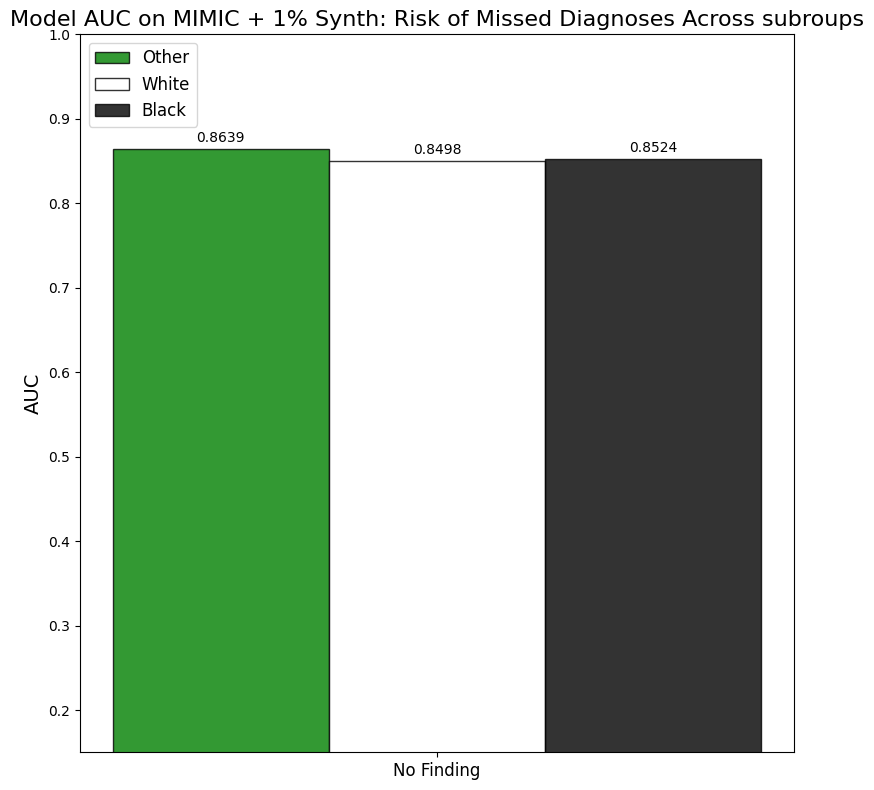

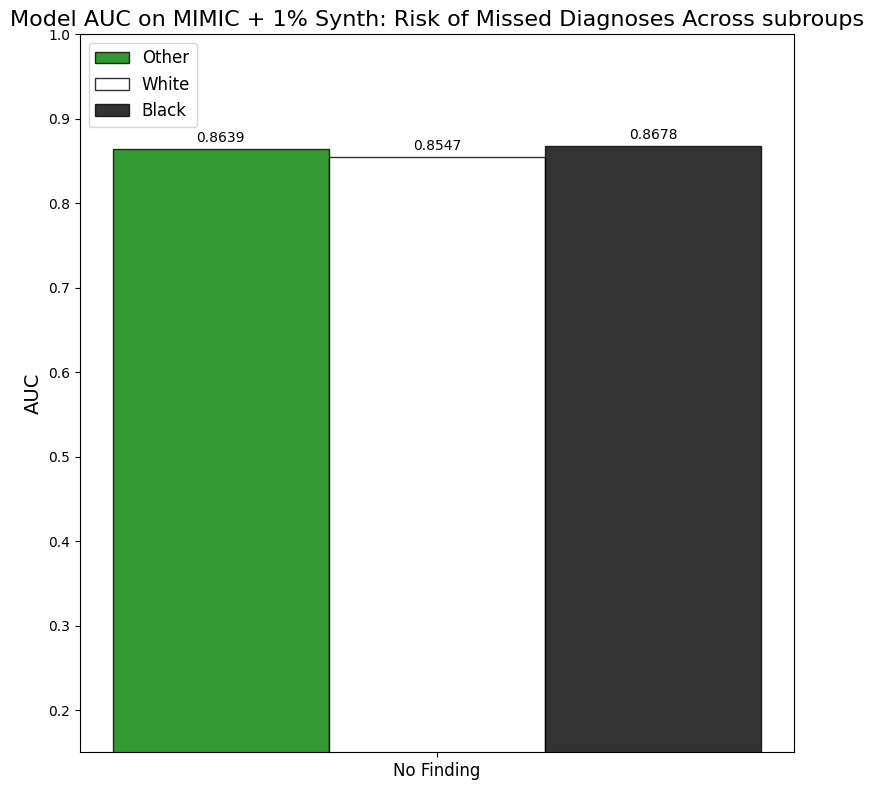

({0: 0.17302945796070135,
  1: 0.12247380239520958,
  2: 0.10937327595718857,
  3: 0.22613202400436444,
  4: 0.10461173279077654,
  5: 0.2177209797657082},
 0.2177209797657082)

In [3]:
# ---------------------------------------------------------------------------- #
#                                                                              #
#                                  [[[ AUC ]]]                                 #
#                                                                              #
# ---------------------------------------------------------------------------- #

# CUDA_VISIBLE_DEVICES=0 python main.py predict -c ./configs/final_mimic_real_all.yaml --ckpt_path /local/home/rezajam/fairness_on_embeddings/results/final_mimic_real_all/checkpoints/best_val_loss-epoch=02-val_loss=0.3401.ckpt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score
from metrics.metrics import calculate_roc_auc,find_best_threshold, calculate_fpr_fnr

# # ---------------------------------------------------------------------------- #
# #                               plot_auc_barchart                              #
# # ---------------------------------------------------------------------------- #
import matplotlib.pyplot as plt
import numpy as np

def plot_auc_barchart(auc_all, auc_white, auc_black, label_names):
    """
    Plots a bar chart comparing AUCs for Total, White, and Black groups for each disease label.

    Parameters:
    - auc_all: List of AUCs for the total population.
    - auc_white: List of AUCs for the White group.
    - auc_black: List of AUCs for the Black group.
    - label_names: List of disease labels.
    """
    n_labels = len(label_names)
    x = np.arange(n_labels)  # Label positions on x-axis

    # Bar width
    width = 0.25
    # width = 0.5

    # Create the figure and axes
    fig, ax = plt.subplots(figsize=(8, 8))  # Increase figure size for better visibility

    # Plot bars for each group
    bars_all = ax.bar(x - width, auc_all, width, label='Other', alpha=0.8, color="green", edgecolor="black")
    bars_white = ax.bar(x, auc_white, width, label='White', alpha=0.8, color="white", edgecolor="black")
    bars_black = ax.bar(x + width, auc_black, width, label='Black', alpha=0.8, color="black", edgecolor="black")

    # Add labels to the bars
    ax.bar_label(bars_all, fmt='%.4f', padding=3)
    ax.bar_label(bars_white, fmt='%.4f', padding=3)
    ax.bar_label(bars_black, fmt='%.4f', padding=3)

    # Add labels, title, and legend
    # ax.set_xlabel("Disease Labels", fontsize=14)
    ax.set_ylabel("AUC", fontsize=14)
    ax.set_title("Model AUC on MIMIC + 1% Synth: Risk of Missed Diagnoses Across subroups", fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(label_names, fontsize=12)
    ax.legend(loc='upper left', fontsize=12)

    # Adjust y-axis range to zoom in on differences
    # ax.set_ylim(0.8, 1.0) #For more than 1 epochs
    ax.set_ylim(0.15, 1.0) #For 1 epoch

    

    # Display the plot
    plt.tight_layout()
    plt.show()


# ---------------------------------------------------------------------------- #
#                                                                              #
#                                  [ THE CODE ]                                #
#                                                                              #
# ---------------------------------------------------------------------------- #

exp_type = "final_mimic_01_syn_all"
labels_val = np.load(f'/local/home/rezajam/fairness_on_embeddings/results/{exp_type}/probabilities/labels_val.npy')
pp_val = np.load(f'/local/home/rezajam/fairness_on_embeddings/results/{exp_type}/probabilities/probabilities_val.npy')
labels_test = np.load(f'/local/home/rezajam/fairness_on_embeddings/results/{exp_type}/probabilities/labels_test.npy')
pp_test = np.load(f'/local/home/rezajam/fairness_on_embeddings/results/{exp_type}/probabilities/probabilities_test.npy')

label_names = [
    "Cardiomegaly"
    ,"Edema"
    ,"Consolidation"
    ,"Atelectasis"
    ,"Pleural Effusion"
    ,"No Finding"
]

# ---------------------------------------------------------------------------- #
#                                 get Threshold                                #
# ---------------------------------------------------------------------------- #
thresholds = find_best_threshold(pp_val, labels_val)


# ---------------------------------------------------------------------------- #
#                                   RACE                                       #
# ---------------------------------------------------------------------------- #

# -------------------------------- Explore Race ------------------------------ #
# get csvs
mimic_test_csv = pd.read_csv('/local/home/rezajam/project/med-stable-diffusion/data/csv/mimic/mimic_test.csv')
# mimic_test_csv = pd.read_csv('/local/home/rezajam/fairness_on_embeddings/results-backup/mimic_test.csv')
# use_frontal: True
# mimic_test_csv = mimic_test_csv[mimic_test_csv["Frontal/Lateral"] == "Frontal"]


# --------------------------------- CREATE ID -------------------------------- #
# CREATE ID from Path 'p' from p231434 
# add the patient_id from /.../p12313/...:
mimic_test_csv['subject_id'] = mimic_test_csv['Path'].apply(lambda x: x.split('/')[2])
# remove 'p' from p231434
mimic_test_csv['subject_id'] = mimic_test_csv['subject_id'].apply(lambda x: x.split('p')[1]).astype(int)
mimic_test_csv
# --------------------------------- ADD RACE --------------------------------- #

# ------------ ADD RACE from merging admissions id to the mimic id ----------- #
mimic_admissions =  pd.read_csv('/local/data/physionet.org/files/mimiciv/2.2/hosp/admissions.csv')
# Ensure mimic_admissions has no duplicate subject_id rows
mimic_admissions = mimic_admissions.drop_duplicates(subset='subject_id')
# Create a mapping from subject_id to race
id_to_race = mimic_admissions.set_index('subject_id')['race']
# Add the race column to mimic_test_csv based on subject_id mapping
mimic_test_csv['race'] = mimic_test_csv['subject_id'].map(id_to_race)
# Verify the lengths remain unchanged

print("Labels size:", labels_test.shape[0])
print("Testing dataset size:", mimic_test_csv.shape[0])
assert len(labels_test) == len(mimic_test_csv), "Length mismatch detected!"
# mimic_test_csv
mimic_test_csv1 = mimic_test_csv.copy()


# ---------------------------------------------------------------------------- #
#                       [Race] Label-Probability Analysis                      #
# ---------------------------------------------------------------------------- #

# ----------------------------------- TOTAL ---------------------------------- #
labels_test = np.load(f'/local/home/rezajam/fairness_on_embeddings/results/{exp_type}/probabilities/labels_test.npy')
pp_test = np.load(f'/local/home/rezajam/fairness_on_embeddings/results/{exp_type}/probabilities/probabilities_test.npy')
mimic_test_csv = mimic_test_csv1.copy()

label_all = {}
pp_all = {}
label_all = labels_test
pp_all = pp_test
__, __, my_auc_all = calculate_roc_auc(pp_all, label_all)

fpr_all, fnr_all = calculate_fpr_fnr(pp_all, label_all, thresholds)
# my_auc_all = {}
# for i in range(label_all.shape[1]):
#     my_auc_all[i] = roc_auc_score(label_all[:, i], pp_all[:, i])

# ----------------------------------- WHITE ---------------------------------- #
labels_test = np.load(f'/local/home/rezajam/fairness_on_embeddings/results/{exp_type}/probabilities/labels_test.npy')
pp_test = np.load(f'/local/home/rezajam/fairness_on_embeddings/results/{exp_type}/probabilities/probabilities_test.npy')
mimic_test_csv = mimic_test_csv1.copy()

white_related = [
    'WHITE',
    'WHITE - RUSSIAN',
    'WHITE - OTHER EUROPEAN',
    'WHITE - BRAZILIAN',
    'WHITE - EASTERN EUROPEAN'
]
label_white = {}
pp_white = {}
mimic_test_csv = mimic_test_csv1.copy()
label_white = labels_test[mimic_test_csv['race'].isin(white_related)]
mimic_test_csv = mimic_test_csv1.copy()
pp_white = pp_test[mimic_test_csv['race'].isin(white_related)]
__, __, my_auc_white = calculate_roc_auc(pp_white, label_white)


fpr_white, fnr_white = calculate_fpr_fnr(pp_white, label_white, thresholds)
# my_auc_white = {}
# for i in range(label_white.shape[1]):
#     my_auc_white[i] = roc_auc_score(label_white[:, i], pp_white[:, i])

# ----------------------------------- BLACK ---------------------------------- #
labels_test = np.load(f'/local/home/rezajam/fairness_on_embeddings/results/{exp_type}/probabilities/labels_test.npy')
pp_test = np.load(f'/local/home/rezajam/fairness_on_embeddings/results/{exp_type}/probabilities/probabilities_test.npy')
mimic_test_csv = mimic_test_csv1.copy()

black_related = [
    'BLACK/AFRICAN AMERICAN',
    'BLACK/CAPE VERDEAN',
    'BLACK/AFRICAN',
    'BLACK/CARIBBEAN ISLAND'
]
label_black = {}
pp_black = {}
mimic_test_csv = mimic_test_csv1.copy()
label_black = labels_test[mimic_test_csv['race'].isin(black_related)]
mimic_test_csv = mimic_test_csv1.copy()
pp_black = pp_test[mimic_test_csv['race'].isin(black_related)]
__, __, my_auc_black = calculate_roc_auc(pp_black, label_black)


fpr_black, fnr_black = calculate_fpr_fnr(pp_black, label_black, thresholds)

# my_auc_black = {}
# for i in range(label_black.shape[1]):
#     my_auc_black[i] = roc_auc_score(label_black[:, i], pp_black[:, i])

# ----------------------------------- OTHER ---------------------------------- #
label_other = {}
pp_other = {}
other_race_mask = ~mimic_test_csv['race'].isin(black_related + white_related)
mimic_test_csv = mimic_test_csv1.copy()
label_other = labels_test[other_race_mask]
mimic_test_csv = mimic_test_csv1.copy()
pp_other = pp_test[other_race_mask]
__, __, my_auc_other = calculate_roc_auc(pp_other, label_other)


fpr_other, fnr_other = calculate_fpr_fnr(pp_other, label_other, thresholds)



# ----------------------------- Call the function ---------------------------- #
# label_names = [
#     "Cardiomegaly"
#     ,"Edema"
#     ,"Consolidation"
#     ,"Atelectasis"
#     ,"Pleural Effusion"
#     ,"No Finding"
# ]

# fpr_all_list   = [fpr_all[i]   for i in range(len(label_names))]
# fpr_white_list = [fpr_white[i] for i in range(len(label_names))]
# fpr_black_list = [fpr_black[i] for i in range(len(label_names))]

# plot_auc_barchart(fpr_all_list, fpr_white_list, fpr_black_list, label_names)





# ---------------------------------------------------------------------------- #
#                                   GENDER                                     #
# ---------------------------------------------------------------------------- #
mimic_patients =  pd.read_csv('/local/data/physionet.org/files/mimiciv/2.2/hosp/patients.csv')

mimic_patients = mimic_patients.drop_duplicates(subset='subject_id')
mimic_patients
# Create a mapping from subject_id to race
id_to_race = mimic_patients.set_index('subject_id')['gender']
# Add the race column to mimic_test_csv based on subject_id mapping
mimic_test_csv['gender'] = mimic_test_csv['subject_id'].map(id_to_race)
# Verify the lengths remain unchanged

print("Labels size:", labels_test.shape[0])
print("Testing dataset size:", mimic_test_csv.shape[0])
assert len(labels_test) == len(mimic_test_csv), "Length mismatch detected!"

# ----------------------------------- MALE ----------------------------------- #
labels_test = np.load(f'/local/home/rezajam/fairness_on_embeddings/results/{exp_type}/probabilities/labels_test.npy')
pp_test = np.load(f'/local/home/rezajam/fairness_on_embeddings/results/{exp_type}/probabilities/probabilities_test.npy')

label_male = {}
pp_male = {}
label_male = labels_test[mimic_test_csv['gender'] == "M"]
pp_male = pp_test[mimic_test_csv['gender'] == "M"]
__, __, my_auc_male = calculate_roc_auc(pp_male, label_male)


fpr_male, fnr_male = calculate_fpr_fnr(pp_male, label_male, thresholds)

# ----------------------------------- FEMALE --------------------------------- #
labels_test = np.load(f'/local/home/rezajam/fairness_on_embeddings/results/{exp_type}/probabilities/labels_test.npy')
pp_test = np.load(f'/local/home/rezajam/fairness_on_embeddings/results/{exp_type}/probabilities/probabilities_test.npy')

label_female = {}
pp_female = {}
label_female = labels_test[mimic_test_csv['gender'] == "F"]
pp_female = pp_test[mimic_test_csv['gender'] == "F"]
__, __, my_auc_female = calculate_roc_auc(pp_female, label_female)


fpr_female, fnr_female = calculate_fpr_fnr(pp_female, label_female, thresholds)


label_names = ["No Finding"]
plot_auc_barchart(my_auc_all[5], my_auc_white[5], my_auc_black[5], label_names)
plot_auc_barchart(my_auc_all[5], my_auc_male[5], my_auc_female[5], label_names)
fpr_all , fpr_all[5]

In [20]:
import pandas as pd
mimic_sampled_to_syn = pd.read_csv('/local/home/rezajam/clean/per_storage/csvs/mimic/mimic_sampled_to_syn.csv')
syn_train_csv = pd.read_csv('/local/home/rezajam/clean/per_storage/csvs/mimic/samples_id_race_train.csv')
mimic_val_csv = pd.read_csv('/local/home/rezajam/project/med-stable-diffusion/data/csv/mimic/mimic_val.csv')
mimic_test_csv = pd.read_csv('/local/home/rezajam/project/med-stable-diffusion/data/csv/mimic/mimic_test.csv')


print(f"mimic_train_sampled_down_to_syn_size: {mimic_sampled_to_syn.shape[0]} rows \n+ syn_train_csv: {syn_train_csv.shape[0]} rows \nmimic_val_csv: {mimic_val_csv.shape[0]} rows \nmimic_test_csv: {mimic_test_csv.shape[0]} rows")
print(f"MIMIC TRAINING SET RANDOM SAMPLED DOWN TO SYN SIZE")

mimic_train_sampled_down_to_syn_size: 264664 rows 
+ syn_train_csv: 264664 rows 
mimic_val_csv: 37958 rows 
mimic_test_csv: 37648 rows
MIMIC TRAINING SET RANDOM SAMPLED DOWN TO SYN SIZE


In [4]:
import json

FPR_FILE_NAME = "FPR_MIMIC_01SYN"
# label_names = [
#     "Cardiomegaly"
#     ,"Edema"
#     ,"Consolidation"
#     ,"Atelectasis"
#     ,"Pleural Effusion"
#     ,"No Finding"
# ]

fprs = {
    "fpr_all": fpr_all,
    "fpr_white": fpr_white,
    "fpr_black": fpr_black,
    "fpr_other": fpr_other,
    "fpr_male": fpr_male,
    "fpr_female": fpr_female
}
fprs["fpr_all"]
# Export to a JSON file
with open(f"/local/home/rezajam/fairness_on_embeddings/FINAL_ANALYSIS/{FPR_FILE_NAME}.json", "w") as json_file:
    json.dump(fprs, json_file, indent=4)


In [5]:
import json

AUC_FILE_NAME = "AUC_MIMIC_01SYN"
# label_names = [
#     "Cardiomegaly"
#     ,"Edema"
#     ,"Consolidation"
#     ,"Atelectasis"
#     ,"Pleural Effusion"
#     ,"No Finding"
# ]

aucs = {
    "my_auc_all": my_auc_all,
    "my_auc_white": my_auc_white,
    "my_auc_black": my_auc_black,
    "my_auc_other": my_auc_other,
    "my_auc_male": my_auc_male,
    "my_auc_female": my_auc_female
    
}
# Export to a JSON file
with open(f"/local/home/rezajam/fairness_on_embeddings/FINAL_ANALYSIS/{AUC_FILE_NAME}.json", "w") as json_file:
    json.dump(aucs, json_file, indent=4)

In [14]:
import numpy as np
import pandas as pd
synth_test_csv = pd.read_csv('/local/home/rezajam/clean/per_storage/csvs/mimic/samples_id_race_test.csv')
synth_train_csv = pd.read_csv('/local/home/rezajam/clean/per_storage/csvs/mimic/samples_id_race_train.csv')
synth_val_csv = pd.read_csv('/local/home/rezajam/clean/per_storage/csvs/mimic/samples_id_race_val.csv')

# Calculate the number of rows in each dataset
test_count = len(synth_test_csv)
train_count = len(synth_train_csv)
val_count = len(synth_val_csv)
total_count = test_count + train_count + val_count

# Calculate the split ratio
test_ratio = test_count / total_count
train_ratio = train_count / total_count
val_ratio = val_count / total_count

split_ratios = {
    "Train Ratio": train_ratio,
    "Validation Ratio": val_ratio,
    "Test Ratio": test_ratio,
}

split_ratios


{'Train Ratio': 0.7995118296720559,
 'Validation Ratio': 0.10065794243456826,
 'Test Ratio': 0.09983022789337587}

# 📝Performance evaluation [<b>Entire</b> Dataset]


## 📊📈🔢[<b>Entire</b> Dataset] plots and graphs

### 🔢 [<b>Entire</b> Dataset] **Confusion Matrix** plots  

🔴The Ground Truth Labels (GL) and Predicted Probabilities (PP) are both from Validation dataset.  
The threshold found from the function, will be the ***only threshold*** for the rest of the analyses. 
 
🔴 for the rest of the analysis all evaluations will be conducted on the ***testing set*** or ***subsets of it testing set***.

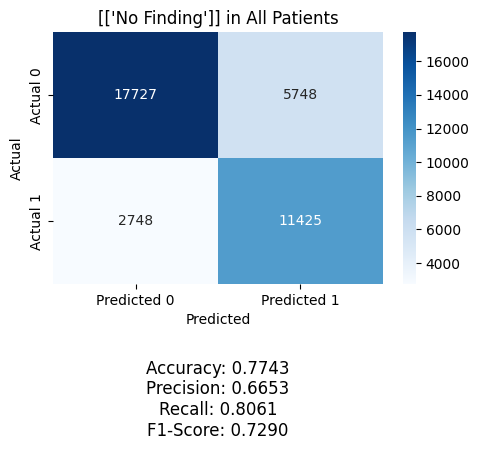

In [28]:
# ---------------------------------------------------------------------------- #
#                             validation set domain                            #
# ---------------------------------------------------------------------------- #
# grandtruth_labels_val = np.load('/local/home/rezajam/fairness_on_embeddings/results/chexpert_all/probabilities/labels_val.npy')
# predicted_probabilities_val = np.load('/local/home/rezajam/fairness_on_embeddings/results/chexpert_all/probabilities/probabilities_val.npy')
thresholds = find_best_threshold(predicted_probabilities_val, grandtruth_labels_val)


thresholds_array = np.array(list(thresholds.values()))
# ---------------------------------------------------------------------------- #
#                              testing set domain                              #
# ---------------------------------------------------------------------------- #
# pp_test = np.load('/local/home/rezajam/fairness_on_embeddings/results/chexpert_all/probabilities/probabilities_test.npy')
# labels_test = np.load('/local/home/rezajam/fairness_on_embeddings/results/chexpert_all/probabilities/labels_test.npy')
predicted_labels_all = apply_thresholds(pp_test, thresholds)
# predicted_labels_all = (pp_test >= thresholds_array).astype(int)

# # plot_confusion_matrices(   y_true,           y_pred)
plot_confusion_matrices(labels_test, predicted_labels_all, 'All')

In [188]:
# Test label distributions in ground truth and predictions
for idx, label in enumerate(label_names):
    true_positives = np.sum(pp_test[:, idx] == 1)
    pred_positives = np.sum(predicted_labels_all[:, idx] == 1)
    print(f"Label {label} -> True Positives: {true_positives}, Predicted Positives: {pred_positives}")

# Test thresholds for sensitivity around critical values
threshold_test_values = [0.1, 0.5, 0.9]  # Edge thresholds for stress-testing
for threshold_value in threshold_test_values:
    adjusted_predictions = (pp_test > threshold_value).astype(int)
    for label_idx in range(len(label_names)):
        accuracy = accuracy_score(labels_test[:, label_idx], adjusted_predictions[:, label_idx])
        print(f"Threshold {threshold_value}, Label {label_names[label_idx]} -> Accuracy: {accuracy:.2f}")


Label Cardiomegaly -> True Positives: 0, Predicted Positives: 0
Label Edema -> True Positives: 0, Predicted Positives: 2
Label Consolidation -> True Positives: 0, Predicted Positives: 1
Label Atelectasis -> True Positives: 0, Predicted Positives: 0
Label Pleural Effusion -> True Positives: 0, Predicted Positives: 1
Label No Finding -> True Positives: 0, Predicted Positives: 2
Threshold 0.1, Label Cardiomegaly -> Accuracy: 0.72
Threshold 0.1, Label Edema -> Accuracy: 0.63
Threshold 0.1, Label Consolidation -> Accuracy: 0.50
Threshold 0.1, Label Atelectasis -> Accuracy: 0.38
Threshold 0.1, Label Pleural Effusion -> Accuracy: 0.60
Threshold 0.1, Label No Finding -> Accuracy: 0.82
Threshold 0.5, Label Cardiomegaly -> Accuracy: 0.89
Threshold 0.5, Label Edema -> Accuracy: 0.75
Threshold 0.5, Label Consolidation -> Accuracy: 0.93
Threshold 0.5, Label Atelectasis -> Accuracy: 0.70
Threshold 0.5, Label Pleural Effusion -> Accuracy: 0.79
Threshold 0.5, Label No Finding -> Accuracy: 0.91
Thresho

### 🔍 ***[ Analysis ]:***  

### Overall Evaluations  
1. **Balanced Accuracy but Variable Precision and Recall**: The model shows reasonable Accuracy across most conditions, but there’s a notable trade-off between Precision and Recall. For some conditions, the model has low precision, indicating a high number of false positives, while other conditions have moderate to high recall, which suggests the model is good at detecting true positives.

2. **Precision issues**: Many labels have LOW Precision values, such as **Cardiomegaly (0.4696)**, **Consolidation (0.1529)**, and **No Finding (0.4195)**.  
This means that for these conditions, **MANY** predicted positives are **false positives**. Meaning many patients will be diagnosed with conditions but they might be completely healthy from leading unnecessary medical follow-ups procedures and increase in the medical burden.

3. **Recall Variability**: Recall (sensitivity) is high for conditions like **Pleural Effusion (0.8492)** and **Atelectasis (0.8222)**, indicating that the model is relatively successful at capturing most true positive cases for these conditions.  
However, it’s lower for **No Finding (0.6224)** and **Consolidation (0.4810)**, which may result in missed diagnoses and can be extremely dangerous.

4. **Low F1-Scores for Certain Conditions**: The F1-scores, which represent a balance between precision and recall, are quite low for **Consolidation (0.2321)** and **No Finding (0.5012)**.  
This suggests a need for improvement in distinguishing these conditions, as the model is struggling with both false positives and false negatives. This makes the model for these labels unreliable.

#### More Explanation on ***No Finding***:
- **Low Precision (0.4195)**:  
The relatively low precision means that model's prediction on No Finding label is mostly False Positives. For No Findings label specifically, this implies that the model identifies many patients to be compeletely healthy from all the 12 pathologies, while they might actually have at least one of the conditions. This is very concerning in a medical setting, because it can result in patients being under-treated, and take away their chance of further medical attention.
- **Low Recall (0.6224)**:  
This means that the model is very bad at finding actual true positives (actual healthy people), resulting in many patients to be diagnosed with conditions but they might be completely healthy from leading to unnecessary medical follow-ups and increase in the medical burden.
- **Low F1-Scores (0.5012)**:  
This means that the model is the balance between both Recall and Precision is very low, making the model is unreliable.


### 📈 [<b>Entire</b> Dataset] **ROC curve** plots

/local/home/rezajam/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_plot/roc_curve.py:171: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


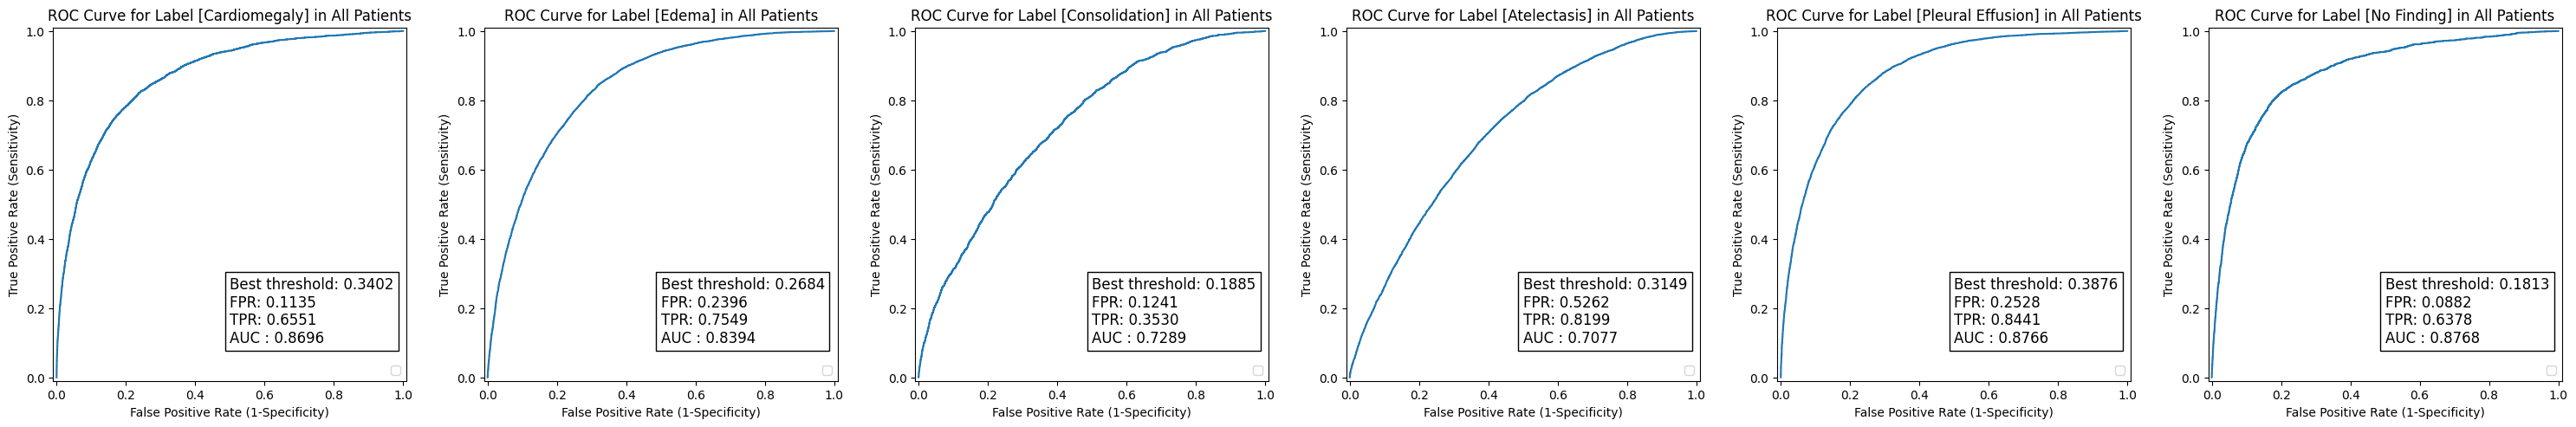

In [301]:
plot_rocs(fpr, tpr, fpr_overall, tpr_overall, AUC, 'All')

### 🔍 ***[ Analysis ]:***  

### Overall Evaluations
- **Consolidation and Atelectasis**:  
[**Consolidation**: **AUC**: 0.8669, **FPR**: 0.0932, **TPR**: 0.6093]  
[**Atelectasis**: **AUC**: 0.7041, **FPR**: 0.5437, **TPR**: 0.8222]  
These labels show the weakest performance.  
High FPRs, meaning a high rate of false positives and poor sensitivity for true positives. Low AUCs meaning the model is bad at classifying healthy cases with sick patients.  
   **Possible Strategies:**
      - Targeted feature engineering 
      - Targeted threshold tuning
      - Data augmentation for images of Consolidation and Atelectasis  
   
- **No Finding**:  
[**No Finding**: **AUC**: 0.8761, **FPR**: 0.0865, **TPR**: 0.6224]  
While AUC is high, the relatively low TPR for "No Finding" suggests that the model is under-predicting healthy people, which leads to unnecessary medical follow-ups procedures and increases in the medical burden.  
   **Possible Strategies:**
      - We must increase Recall by tuning.

### Metric-Specific Observations:  
1. **AUCs**:
   - **No Finding** highest AUC (0.8761), indicating that the model is good at classifying cases with no disease from those with disease.
   - **Pleural Effusion** also has a strong AUC (0.8737), suggesting good discrimination ability for this condition.
   - **Atelectasis (0.7041)** and **Consolidation (0.7362)** have the lowest AUCs, showing weaker performance in distinguishing these pathologies.

2. **Thresholds**:
   - These thresholds balance the trade-off between false positives and false negatives.
   - **High Threshold** (ex: Pleural Effusion at 0.3551).
   - **Low Threshold** (ex: Consolidation at 0.1781) suggest the model is more forgiving in predicting positives for Consolidation label, we obsereved low Recall in confusion matrix for Consolidation. This low threshold might be a good aspect of the consolidation and actually necessary to raise the recall and TPR, and compensate for that.

3. **FPRs & TPRs**:
   - **FPRs**:
      - **No Finding** has a low FPR (0.0865), meaning it generates relatively few false positives for healthy cases, which is great.
     - **Atelectasis** has the highest FPR (0.5437), which aligns with the low precision due to many false positives seen in confusion matrix that Atelectasis has.
   - **TPRs** are generally moderate to high. 
      - **High TPR** Pleural Effusion (0.8492) and Atelectasis (0.8222) have the highest TPRs. High TPRs indicate that the model is sensitive in detecting these conditions, which is crucial in medical diagnostics.
      - **Low TPR** for **Consolidation (0.4810)** indicates that the model misses **many** true positive cases for this condition, leading to under-diagnosis, as seen in the confusion matrix.

### **Important Observations**
In this case for medical imaging disease detection for initial screenings where detecting positives (sick patients) is critical, a high TPR might be good even if it comes with a higher FPR (i.e. its ok if we be less sensitive and pick some healthy cases as sick). False positives can be dealt with in follow-up testings. Because it is very costly to miss positive cases.



In [19]:
print(f"FPR[No-Findings]:{(fpr[5])}")

FPR[No-Findings]:0.07923094813551439


# 📝Performance Bias Evaluation  
Evaluation on the ***Subset*** of the entire testing dataset 

For this section we will need to have access to the entire testing set,  
Since the indeces of the labels and probabilities are the same as the **testing set**.  
The labels set and probabilities set are **not shuffled**.

#### Data Loading

In [20]:
chexpert_test_csv = pd.read_csv('/local/home/rezajam/project/med-stable-diffusion/data/csv/chexpert/chexpert_test.csv')
chexpert_test_csv.head(10)

Path     Sex  Age  \
0  CheXpert-v1.0-small/train/patient00010/study1/...  Female   50   
1  CheXpert-v1.0-small/train/patient00010/study1/...  Female   50   
2  CheXpert-v1.0-small/train/patient00017/study1/...  Female   56   
3  CheXpert-v1.0-small/train/patient00017/study2/...  Female   56   
4  CheXpert-v1.0-small/train/patient00056/study1/...    Male   88   
5  CheXpert-v1.0-small/train/patient00056/study1/...    Male   88   
6  CheXpert-v1.0-small/train/patient00056/study4/...    Male   88   
7  CheXpert-v1.0-small/train/patient00056/study3/...    Male   88   
8  CheXpert-v1.0-small/train/patient00056/study2/...    Male   88   
9  CheXpert-v1.0-small/train/patient00061/study2/...    Male   90   

  Frontal/Lateral AP/PA  No Finding  Enlarged Cardiomediastinum  Cardiomegaly  \
0         Frontal    PA         1.0                         0.0           NaN   
1         Lateral   NaN         1.0                         0.0           NaN   
2         Frontal    AP         1.0                         NaN           0.0   
3         Frontal    AP         NaN                        -1.0           NaN   
4         Frontal    AP         NaN                         NaN           0.0   
5         Lateral   NaN         NaN                         NaN           0.0   
6         Frontal    AP         NaN                         NaN           1.0   
7         Frontal    AP         NaN                         NaN           NaN   
8         Frontal    AP         NaN                         NaN           NaN   
9         Frontal    PA         NaN                         NaN           1.0   

   Lung Opacity  Lung Lesion  Edema  Consolidation  Pneumonia  Atelectasis  \
0           0.0          NaN    NaN            NaN        NaN          NaN   
1           0.0          NaN    NaN            NaN        NaN          NaN   
2           NaN          NaN    NaN            NaN        NaN          NaN   
3           NaN          NaN    1.0           -1.0        NaN          NaN   
4           1.0          NaN    NaN            0.0        NaN          1.0   
5           1.0          NaN    NaN            0.0        NaN          1.0   
6           1.0          NaN    1.0            NaN        NaN          NaN   
7           1.0          NaN    NaN            NaN        NaN          NaN   
8          -1.0          NaN    NaN           -1.0        NaN         -1.0   
9           1.0          NaN    NaN            NaN        NaN          NaN   

   Pneumothorax  Pleural Effusion  Pleural Other  Fracture  Support Devices  \
0           NaN               0.0            NaN       NaN              NaN   
1           NaN               0.0            NaN       NaN              NaN   
2           0.0               NaN            NaN       NaN              1.0   
3          -1.0              -1.0            NaN       NaN              1.0   
4           NaN               0.0            NaN       NaN              NaN   
5           NaN               0.0            NaN       NaN              NaN   
6           NaN               1.0            NaN       NaN              1.0   
7           NaN               1.0            NaN       NaN              1.0   
8           NaN               NaN            NaN       NaN              1.0   
9           0.0               1.0            NaN       NaN              1.0   

      PatientID  
0  patient00010  
1  patient00010  
2  patient00017  
3  patient00017  
4  patient00056  
5  patient00056  
6  patient00056  
7  patient00056  
8  patient00056  
9  patient00061

## 📝Performance Bias by ***Genders*** 

### 📝 [**'Male'**] Analysis

#### Data Preprocessing

masking the ***Male patients*** away from entire  in Testing set, and use the indeces to find their corresponding model results (labels and predicted_probabilities)

In [21]:
import pandas as pd

# chexpert_test_csv = pd.read_csv('/local/home/rezajam/project/med-stable-diffusion/data/csv/chexpert/chexpert_test.csv')

# -------------------------------- male labels ------------------------------- #
# labels_test = pd.DataFrame(labels_test, index=chexpert_test_csv.index)
labels_test_df = pd.DataFrame(labels_test)
male_labels = labels_test_df[chexpert_test_csv['Sex'] == 'Male']
male_labels = male_labels.to_numpy()
# ---------------------------------- male pp --------------------------------- #
# pp_test = pd.DataFrame(pp_test, index=chexpert_test_csv.index)
pp_test_df = pd.DataFrame(pp_test)
male_pp = pp_test_df[chexpert_test_csv['Sex'] == 'Male']
male_pp = male_pp.to_numpy()
# male_pp = male_pp.to_numpy()

# type(male_gtl)

/tmp/ipykernel_938389/1050031093.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_labels = labels_test_df[chexpert_test_csv['Sex'] == 'Male']
/tmp/ipykernel_938389/1050031093.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_pp = pp_test_df[chexpert_test_csv['Sex'] == 'Male']


#### 📊📈🔢[**'Male'**] plots and graphs

##### 🔢[**'Male'**] PLOT **Confusion Matrix**

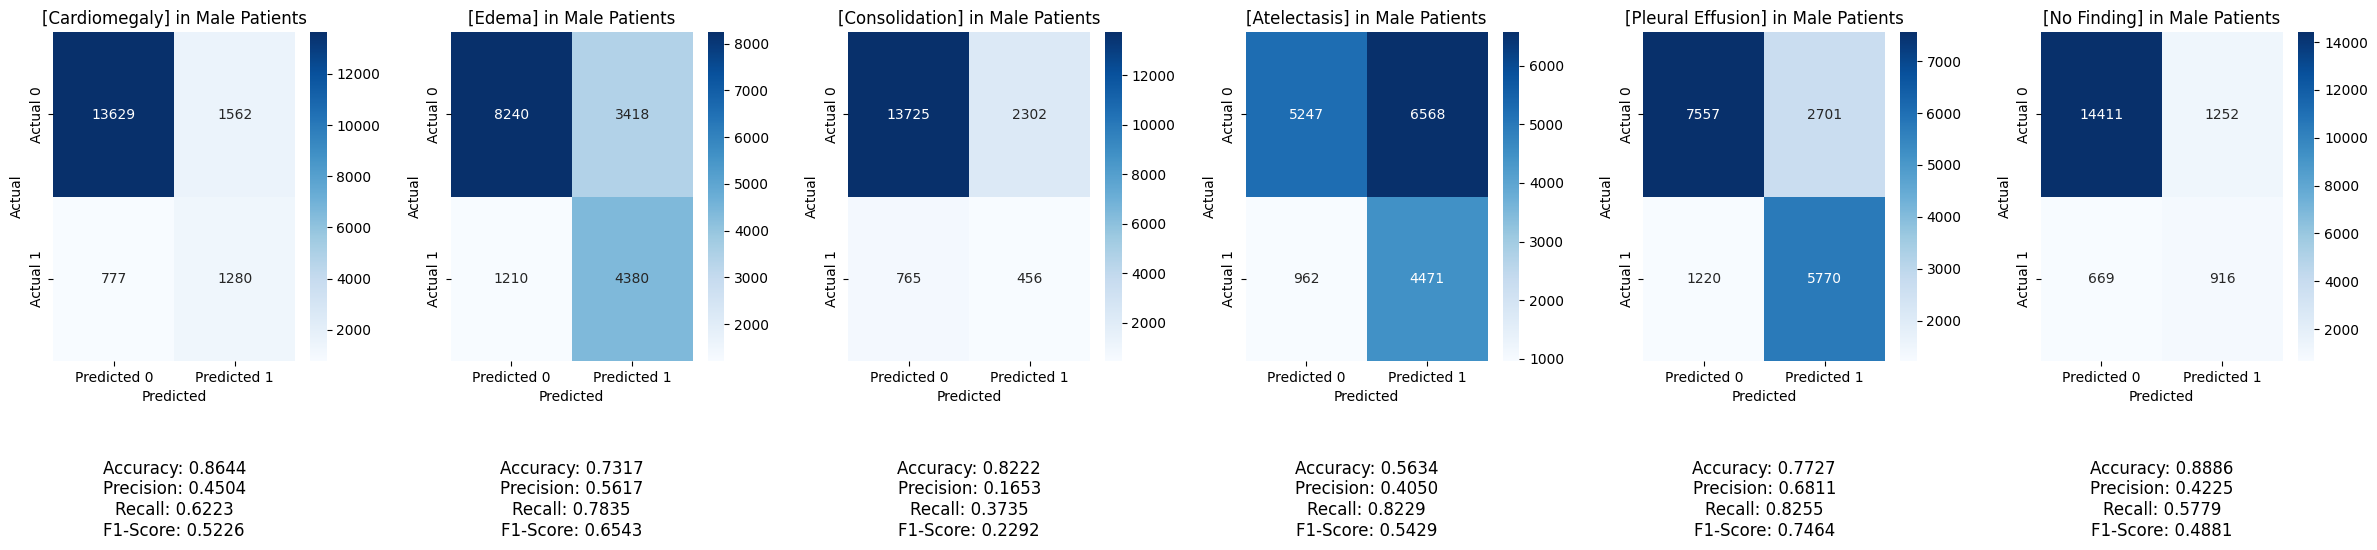

In [22]:
# ---------------------------------------------------------------------------- #
#                             PLOT confusion_matrix                            #
# ---------------------------------------------------------------------------- #
# thresholds = find_best_threshold(male_pp, male_gtl)
predicted_labels_male = apply_thresholds(male_pp, thresholds)
plot_confusion_matrices(male_labels, predicted_labels_male,'Male')
# plot_confusion_matrices(male_gtl, apply_thresholds(male_pp, find_best_threshold(male_pp, male_gtl)))

##### 🔍 ***[ Analysis ]:***  

##### **Overall Evaluations:**
   - **General Trend**: The model tends to **prioritize sensitivity (high TPR)**  
   at the cost of **specificity (higher FPR)** for conditions like **Atelectasis** and **Edema**.
   - **Best Performance**: **Pleural Effusion** and **Cardiomegaly**.
   - **Weakest Performance**: **Consolidation** and **Atelectasis**.
---
### **Pathology-based Evaluation**


1. **Cardiomegaly**  
**High accuracy** with moderate recall and **low precision**.

2. **Edema**  
**High recall** suggests the model captures true cases effectively, though the **lower precision** shows a tendency for false positives.

3. **Consolidation**  
*Poor performance overall*, with ***very low precision*** and ***very low recall***, indicating frequent false positives and missed cases.

4. **Atelectasis**  
*Poor performance overall*, with **High recall** but **low precision** and **low accuracy**, leading to many false positives.

5. **Pleural Effusion**  
*Strong performance* with **high recall** and **high precision**, making pleural effusion one of the ***best-predicted conditions !***

6. **No Finding**  
**High accuracy** but l**ower precision**.




##### 📈 [**'Male'**] PLOT **ROC curves**

/local/home/rezajam/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_plot/roc_curve.py:171: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


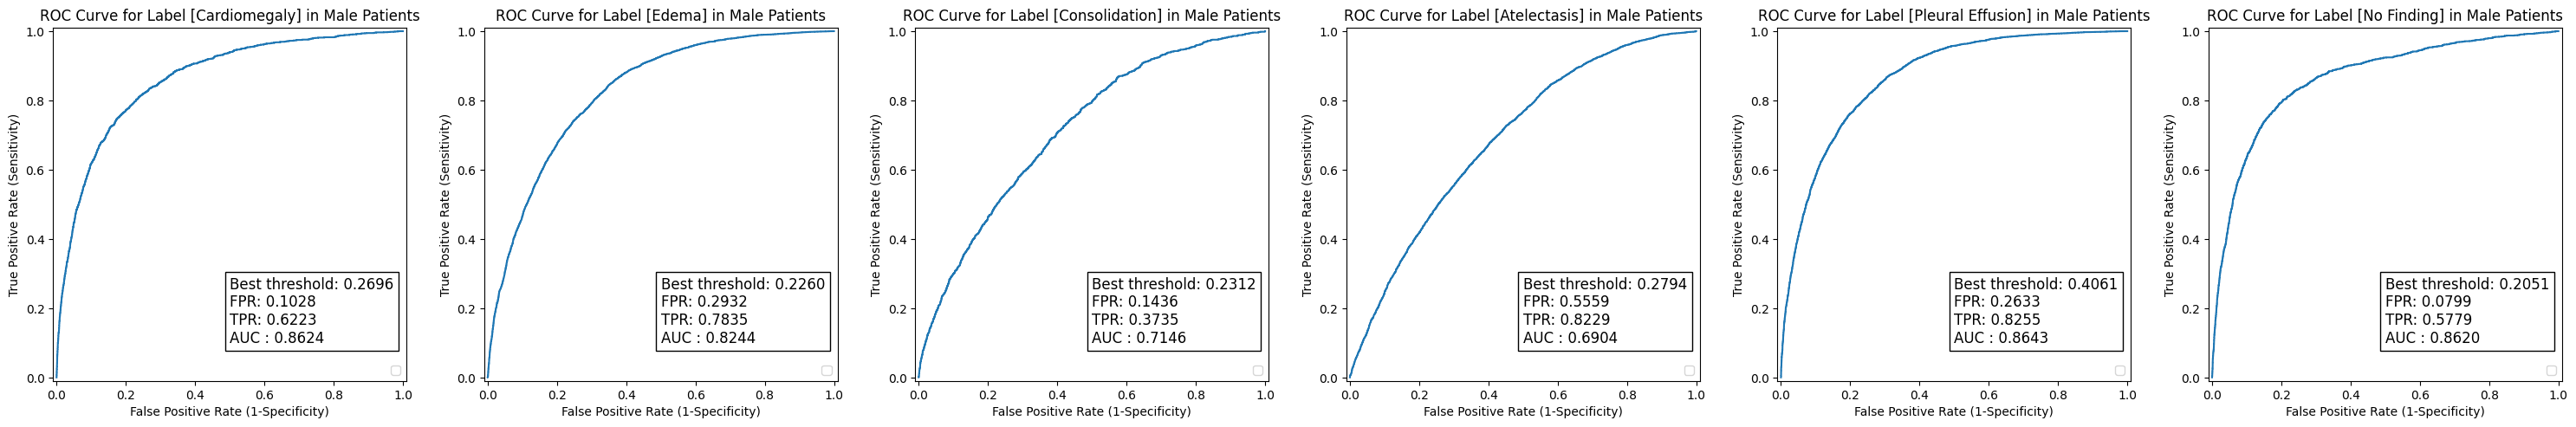

In [23]:
# ---------------------------------------------------------------------------- #
#                                   PLOT ROCS                                  #
# ---------------------------------------------------------------------------- #
fpr, tpr, fpr_overall, tpr_overall, AUC = fpr_tpr_auc(male_pp, male_labels, thresholds)
plot_rocs(fpr, tpr, fpr_overall, tpr_overall, AUC,'Male')

##### 🔍 ***[ Analysis ]:***  

##### **Overall Evaluations:**
   - **General Trend**: The model tends to **prioritize sensitivity (high TPR)**  
   at the cost of **specificity (higher FPR)** for conditions like **Atelectasis** and **Edema**.
   - **Best Performance**: **Pleural Effusion** and **Cardiomegaly**.
   - **Weakest Performance**: **Consolidation** and **Atelectasis**.
---
### **Pathology-based Evaluation**

1. 🔴 **Cardiomegaly**  
*Strong performance* with **good specificity(low FPR)** and **reliable prediction(high AUC)** for cardiomegaly in male patients.

2. **Edema**  
**Strong sensitivity (High TPR)**.

3. 🔴 **Consolidation**  
*weaker performance* with the model **struggling to accurately classify consolidation cases (Lower AUC)** and **Lower TPR** , leading to both false positives and missed cases.

4. **Atelectasis**  
**Low AUC** and **high FPR**.

5. **Pleural Effusion**  
*Strong performance* with **High AUC** and **High TPR**.

6. **No Finding**  
**High AUC** and **low FPR**.



### 📝 [**'Female'**] Analysis

#### Data Preprocessing

masking the ***Female*** away from entire the model results (labels and predicted_probabilities) in Testing set

In [24]:
import pandas as pd

# chexpert_test_csv = pd.read_csv('/local/home/rezajam/project/med-stable-diffusion/data/csv/chexpert/chexpert_test.csv')

# -------------------------------- female gtlabels ------------------------------- #
labels_test_df = pd.DataFrame(labels_test)
female_labels = labels_test_df[chexpert_test_csv['Sex'] == 'Female']
female_labels = female_labels.to_numpy()
# ---------------------------------- female pp --------------------------------- #
pp_test_df = pd.DataFrame(pp_test)
female_pp = pp_test_df[chexpert_test_csv['Sex'] == 'Female']
female_pp = female_pp.to_numpy()

/tmp/ipykernel_938389/2406574905.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_labels = labels_test_df[chexpert_test_csv['Sex'] == 'Female']
/tmp/ipykernel_938389/2406574905.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_pp = pp_test_df[chexpert_test_csv['Sex'] == 'Female']


In [25]:
chexpert_test_csv[chexpert_test_csv['Sex'] == 'Female']

Path     Sex  Age  \
0      CheXpert-v1.0-small/train/patient00010/study1/...  Female   50   
1      CheXpert-v1.0-small/train/patient00010/study1/...  Female   50   
2      CheXpert-v1.0-small/train/patient00017/study1/...  Female   56   
3      CheXpert-v1.0-small/train/patient00017/study2/...  Female   56   
15     CheXpert-v1.0-small/train/patient00067/study3/...  Female   56   
...                                                  ...     ...  ...   
33319  CheXpert-v1.0-small/train/patient63487/study1/...  Female   87   
33320  CheXpert-v1.0-small/train/patient60608/study1/...  Female   75   
33321  CheXpert-v1.0-small/train/patient64138/study2/...  Female   49   
33322  CheXpert-v1.0-small/train/patient43457/study5/...  Female   52   
33324  CheXpert-v1.0-small/train/patient48554/study1/...  Female   45   

      Frontal/Lateral AP/PA  No Finding  Enlarged Cardiomediastinum  \
0             Frontal    PA         1.0                         0.0   
1             Lateral   NaN         1.0                         0.0   
2             Frontal    AP         1.0                         NaN   
3             Frontal    AP         NaN                        -1.0   
15            Frontal    PA         NaN                         NaN   
...               ...   ...         ...                         ...   
33319         Frontal    AP         NaN                         NaN   
33320         Frontal    AP         NaN                         0.0   
33321         Frontal    AP         NaN                         NaN   
33322         Lateral   NaN         NaN                         NaN   
33324         Frontal    AP         1.0                         NaN   

       Cardiomegaly  Lung Opacity  Lung Lesion  Edema  Consolidation  \
0               NaN           0.0          NaN    NaN            NaN   
1               NaN           0.0          NaN    NaN            NaN   
2               0.0           NaN          NaN    NaN            NaN   
3               NaN           NaN          NaN    1.0           -1.0   
15              NaN           NaN          1.0    NaN            1.0   
...             ...           ...          ...    ...            ...   
33319           NaN           NaN          NaN    NaN            NaN   
33320           NaN           1.0          NaN    NaN           -1.0   
33321           NaN           NaN          NaN    1.0           -1.0   
33322           NaN           1.0          NaN    NaN           -1.0   
33324           NaN           0.0          NaN    NaN            NaN   

       Pneumonia  Atelectasis  Pneumothorax  Pleural Effusion  Pleural Other  \
0            NaN          NaN           NaN               0.0            NaN   
1            NaN          NaN           NaN               0.0            NaN   
2            NaN          NaN           0.0               NaN            NaN   
3            NaN          NaN          -1.0              -1.0            NaN   
15           NaN          NaN          -1.0               NaN            NaN   
...          ...          ...           ...               ...            ...   
33319        NaN          NaN           NaN               1.0            NaN   
33320        NaN         -1.0           NaN               NaN            NaN   
33321        NaN         -1.0           0.0               1.0            NaN   
33322        1.0          NaN           NaN               NaN            1.0   
33324        NaN          NaN           0.0               NaN            NaN   

       Fracture  Support Devices     PatientID  
0           NaN              NaN  patient00010  
1           NaN              NaN  patient00010  
2           NaN              1.0  patient00017  
3           NaN              1.0  patient00017  
15          NaN              1.0  patient00067  
...         ...              ...           ...  
33319       NaN              1.0  patient63487  
33320       NaN              NaN  patient60608  
33321       NaN              1.0  patient64138  
33322 

#### 📊📈🔢[**'Female'**] plots and graphs

##### 🔢[**'Female'**] PLOT **Confusion Matrix**

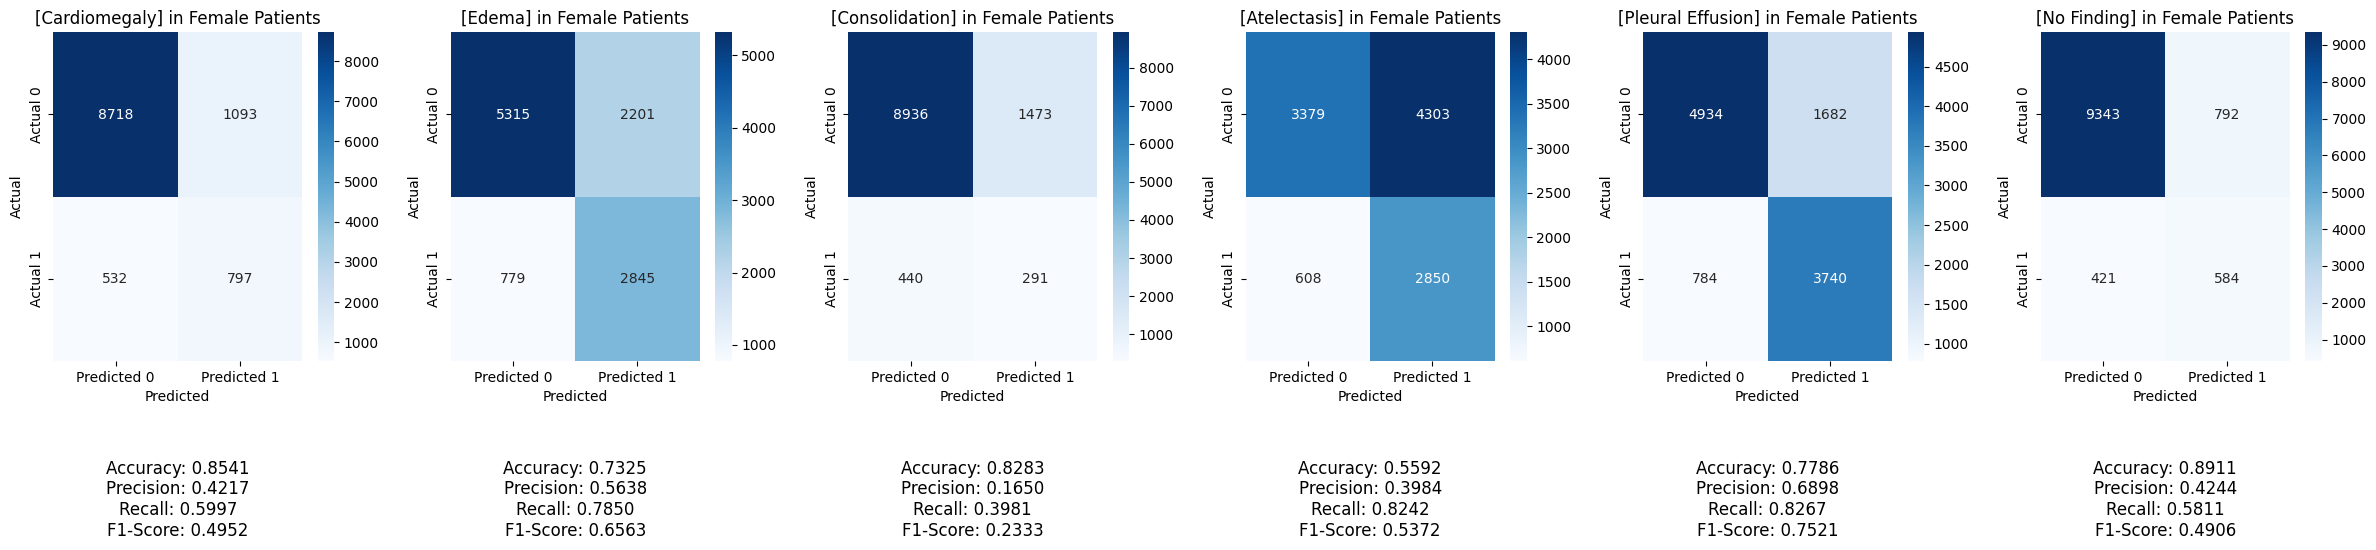

In [26]:
# ---------------------------------------------------------------------------- #
#                             PLOT confusion_matrix                            #
# ---------------------------------------------------------------------------- #
# threshold = find_best_threshold(female_pp, female_gtl)
predicted_labels_female = apply_thresholds(female_pp, thresholds)
plot_confusion_matrices(female_labels, predicted_labels_female, 'Female')
# plot_confusion_matrices(female_gtl, apply_thresholds(female_pp, find_best_threshold(female_pp, female_gtl)))


##### 🔍 ***[ Analysis ]:***  

##### **Overall Evaluations:**

  - **General Trend**: The model has a tendency for high recall but lower precision across several conditions, indicating it prioritizes identifying true positives but generates more false positives.
  - **Best Performance**: **Pleural Effusion**
  - **Weakest Performance**: **Consolidation** and **Atelectasis**
---
### **Pathology-based Evaluation**

   - **Cardiomegaly**:  
   **high accuracy** but **lower precision**.

   - **Edema**:  
   **Good recall** but **lower precision**.

   - 🔴**Consolidation**:  
   **Very low precision and recall**, making this the ***weakest-performing condition***. The model struggles to identify consolidation accurately, resulting in **many false positives and false negatives**.

   - **Atelectasis**:  
   **High recall** but **low accuracy and precision**, meaning many false positives, with the model capturing true cases **at the cost of substantial false positives**.

   - 🔴**Pleural Effusion**:  
  **Strong performance with high recall and balanced precision**, making pleural effusion one of the ***best-predicted*** conditions in this set.

   - **No Finding**:  
   **High accuracy** but **low precision**, meaning the model is **cautious** with this label but still incurs false positives.



##### 📈[**'Female'**] PLOT **ROCs**

In [284]:
# ---------------------------------------------------------------------------- #
#                                   PLOT ROCS                                  #
# ---------------------------------------------------------------------------- #
fpr2, tpr2, fpr_overall2, tpr_overall2, AUC2 = fpr_tpr_auc(female_pp, female_labels, thresholds)
plot_rocs(fpr2, tpr2, fpr_overall2, tpr_overall2, AUC2, 'Female')


NameError: name 'female_pp' is not defined

##### 🔍 ***[ Analysis ]:***  

##### **Overall Evaluations:**

- **General Trend**: The model tends to **prioritize sensitivity (high TPR)** at the expense of **specificity (higher FPR)** for conditions like **Edema** and **Atelectasis**.
- **Best Performance**: **Pleural Effusion** and **No Finding** because they have **high AUC** with **balanced TPR and FPR**.
- **Weakest Performance**: **Consolidation** and **Atelectasis** have ***the lowest AUCs***, with **high FPR** and **moderate to low TPR**.

---
##### **Pathology-based Evaluation:**

1. **Cardiomegaly**  
**high AUC** (discrimination).

2. **Edema**  
**High TPR** indicates **strong sensitivity**, but a relatively **high FP**R means the model **captures more true positives at the cost of more false positives**.

3. 🔴 **Consolidation**  
**Lower AUC** and **Lower TPR** indicate ***poor performance***, with the model struggling to distinguish consolidation from other conditions, leading to both false positives and missed cases.

4. 🔴**Atelectasis**  
**Low AUC** and **very high FPR** indicate ***poor performance***.

5. **Pleural Effusion**  
***Strong performance*** with **high AUC** and  **High TPR**, indicate reliable classification of pleural effusion, although with moderate false positives.

6. **No Finding**  
***Strong performance*** with **High AUC** and **low FPR** indicate good specificity, although normal TPR suggests some true findings may be missed.


### [**'Male'**]  vs [**'Female'**] Overall Evaluation



#### 🔢🔢 [**'Male'**]  vs [**'Female'**] **confusion matrices**

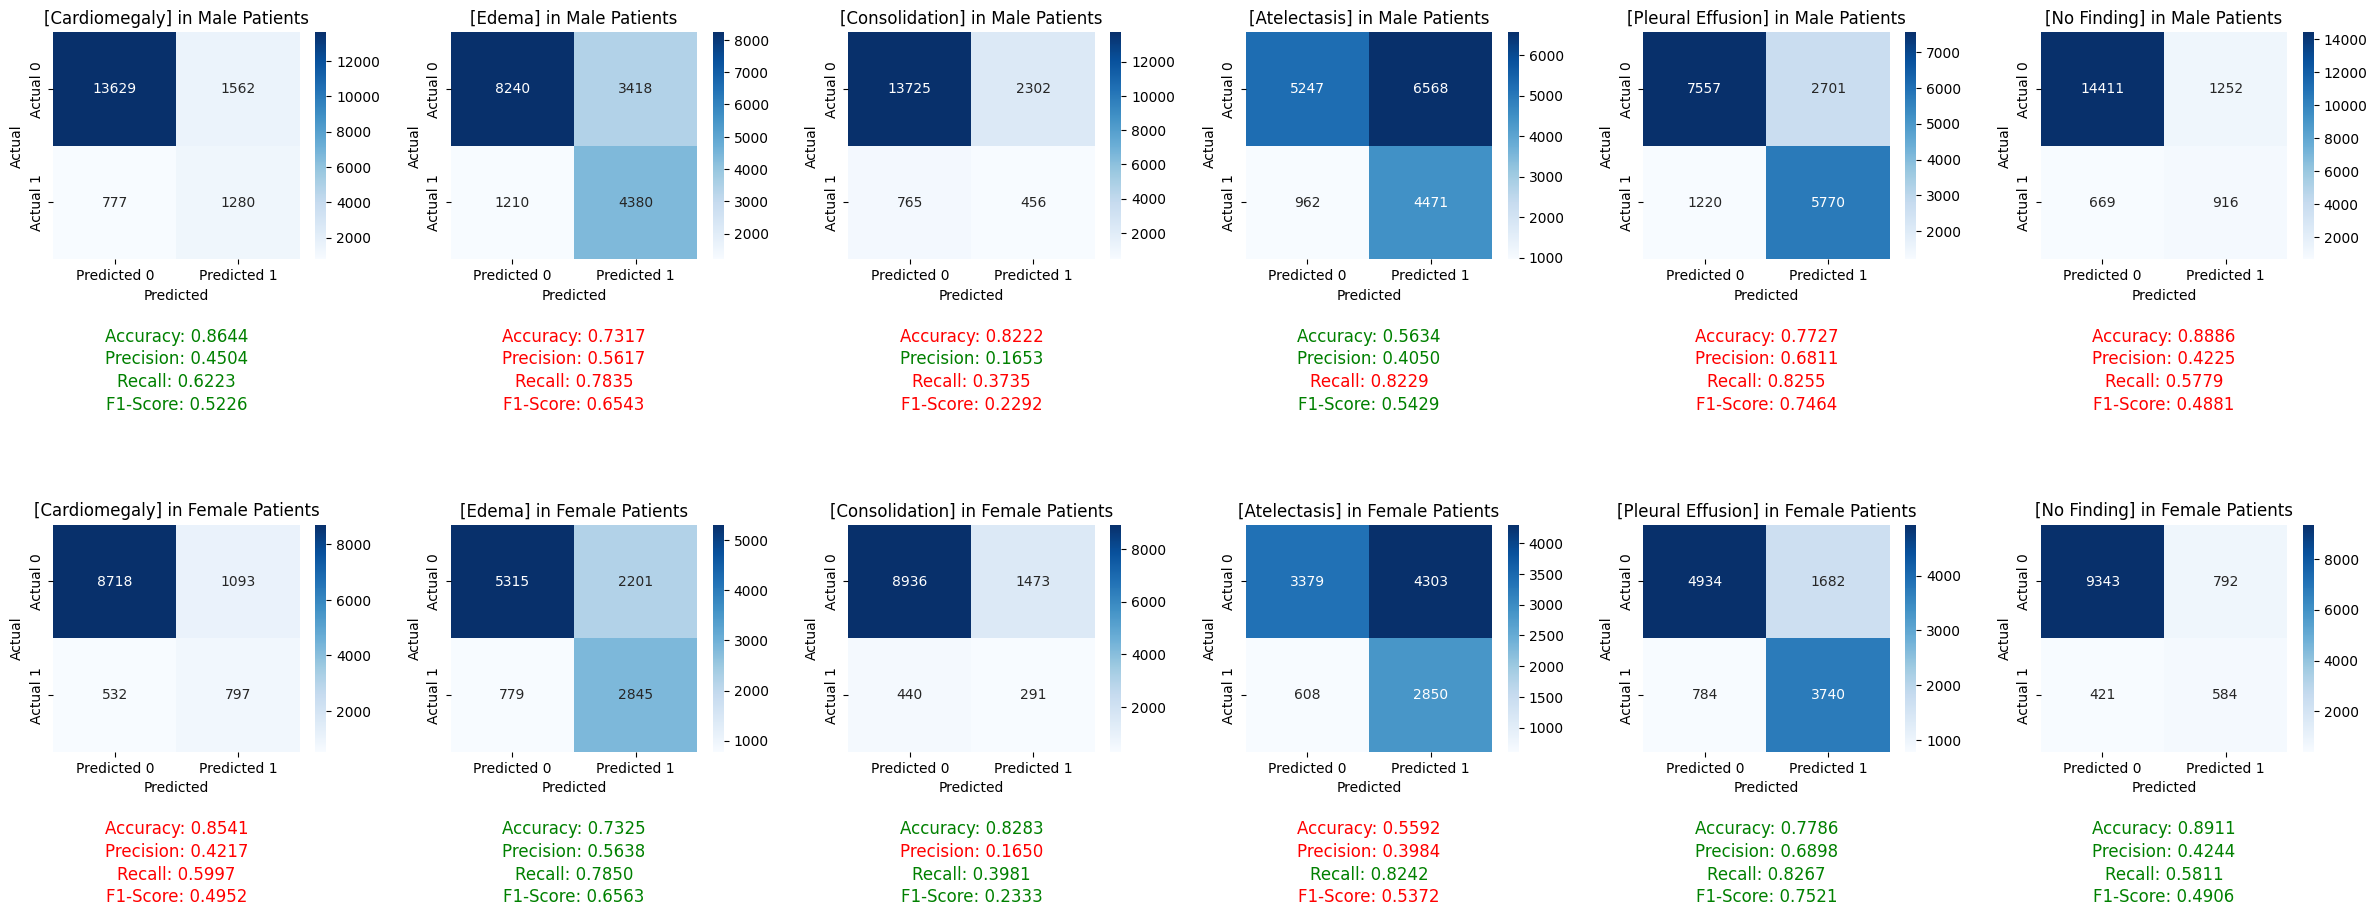

In [28]:
compare_confusion_matrices(male_labels, predicted_labels_male,'Male', female_labels, predicted_labels_female,'Female')

##### 🔍 ***[ Analysis ]:***  

##### **Overall Evaluations:**
From the confusion matrices and performance metrics provided, **female patients** appear to experience **generally lower model performance** across several conditions compared to male patients. Here’s a summary:

1. **Cardiomegaly**: lower **recall and F1-score** for female patients.
   
2. **Consolidation**: *Both genders have poor performance*, but the **precision and recall** are slightly lower in female patients.

3. **Atelectasis**: *Both genders have poor performance*, but the **accuracy and F1-score** are slightly lower in female patients.

4. **Edema** + **Pleural Effusion**:  *Both genders have poor performance*, but the **precision** is slightly lower in female patients.

5. **No Finding**: *Both genders have poor performance*, but the **recall** is slightly lower in female patients.

The model generally performs slightly worse for female patients across conditions, with **Consolidation** and **Atelectasis**  and **Edema** being the ***most problematic***. This suggests that **female patients have a higher likelihood of missed or incorrectly identified pathologies** compared to male patients with this model.

---
##### **Pathology-based Evaluation:**

   - **Cardiomegaly**:
     - **Male Patients**: **High accuracy** (0.8762) with **lower precision** (0.4848).
     - **Female Patients**: **lower recall** (0.6012) and **lower F1-score** (0.5130).

   - **Atelectasis**:
     - **Female Patients**: The model's performance is **poor in both genders**, but female patients show slightly lower metrics, with **lower accuracy and F1-score**.

   - **Edema**:
     - **Female Patients**: **Lower accuracy**(0.7538) and **lower precision** (0.5934), but the model has a **higher recall** (0.7724). This trend suggests a slightly better capture of true cases for females, **but at the cost of more false positives**.

   - **Consolidation**:
     - **Both Genders**: This condition shows very **low precision** (0.1547 for males and 0.1501 for females) and **low recall** (~0.48 for both).

   - **Pleural Effusion**:
     - **Both Genders**: **Good accuracy** (~0.78 for both), with a **high recall** (~0.85) and **high precision** (0.6884 for males, 0.6921 for females). The model is more reliable in detecting pleural effusion across genders.
     
   - **No Finding**:
     - **Both Genders**: **High accuracy** (0.8865 for males, 0.8876 for females), but **low precision** (~0.42).
---
### **Gender-based Evaluation**
   - Accuracy remains fairly stable across genders.
   - **Precision tends to be lower in female patients for several conditions**, suggesting that the model may over-predict for female patients.
   - Conditions like **Pleural Effusion** and **Cardiomegaly** are generally predicted better than **Consolidation** and **Atelectasis**, which shows lower performance metrics across both genders.


### 📈📈 [**'Male'**]  vs [**'Female'**] **AUCs**

/local/home/rezajam/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_plot/roc_curve.py:171: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


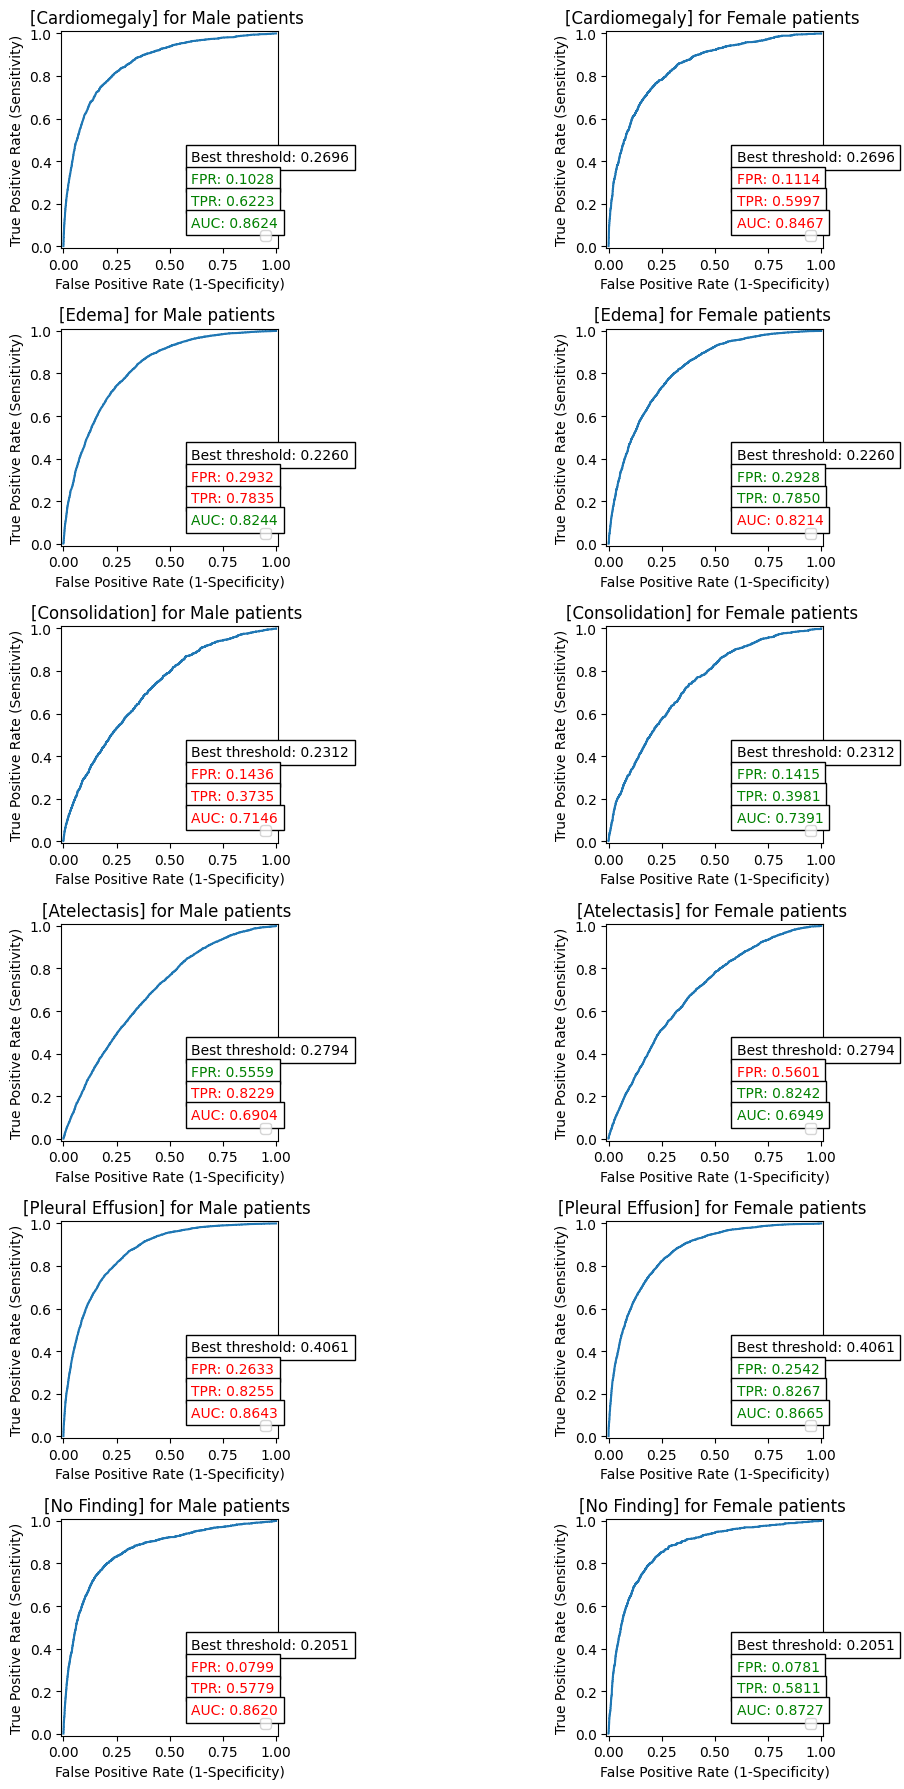

In [29]:
# plot_dual_aucs(fpr, tpr, fpr_overall, tpr_overall, AUC, fpr2, tpr2, fpr_overall2, tpr_overall2, AUC2, thresholds, threshold)
compare_rocs_colored(fpr, tpr, fpr_overall, tpr_overall, AUC, fpr2, tpr2, fpr_overall2, tpr_overall2, AUC2, thresholds,label_text1='Male',label_text2='Female')

##### 🔍 ***[ Analysis ]:***  

##### **Overall Evaluations:**
From the ROC curves and AUC values provided, **female patients** appear to experience **worse model performance** across several pathologies compared to male patients:

1. **Cardiomegaly**: Female patients show a **lower AUC** (0.8613 for females vs. 0.8706 for males) and a **higher (FPR)**, indicating that the model may generate more false positives for females.  
Cardiomegaly metrics **are generally high**, with AUC around 0.86 and (TPR) above 0.6 for females.  
This indicates that the in general model is fine with this condition, but its metrics are slightly worse than male patients.

2. 🔴**Consolidation**: *Both genders have poor performance*, with **AUC values around 0.73-0.74** and **low (TPR)** in general.  
However, female patients have a **higher FPR** and **lower AUC**, making it one of the ***most challenging conditions*** for the model across both genders.  
Consolidation metrics **are generally low**, with both AUC around 0.73-0.74 and (TPR) below 0.5 for both genders.  
This indicates that the **in general model struggles significantly** with this condition.
    - This makes performance for ***Male*** Patients Consolidation **even worse**.

3. **Atelectasis**: *Both genders have poor performance*, with **AUC values** around 0.70. Female patients have a **higher FPR** and  **lower AUC**, leading to a greater tendency for false positives in this group.

4. **Edema** + **Pleural Effusion**: Both conditions show **high AUCs in general**, indicating stronger model performance. However, **female patients** exhibit **lower AUCs and higher FPRs** for Edema, suggesting a higher rate of false positives for Edema and Pleural Effusion as for female patients.

5. **No Finding**: *Both genders perform similarly, with high AUCs (around 0.87-0.88)* and will classify overall sick and ovearll healthy patients. However, the **TPR(i.e. Recall) is lower** in female patients, meaning the model might also miss more healthy patients.

🔴The model consistently shows **slightly worse performance for female patients** across conditions, with **Consolidation, Atelectasis, and Edema** being the ***most problematic***. This indicates that **female patients have a higher likelihood of false positives or missed predictions** compared to male patients.

**Best Performance**: **Pleural Effusion and Cardiomegaly**, **with strong AUC and balanced TPR**.



## 📝Performance Bias by ***AgeGroups***


### 📝Exploration on the ***Age***


In [30]:
# chexpert_test_csv = pd.read_csv('/local/home/rezajam/project/med-stable-diffusion/data/csv/chexpert/chexpert_test.csv')
chexpert_test_csv['Age'].describe()

count    33325.000000
mean        60.452153
std         18.002860
min         18.000000
25%         49.000000
50%         62.000000
75%         74.000000
max         90.000000
Name: Age, dtype: float64

##### 📊 [**'Age'**] distribution histogram

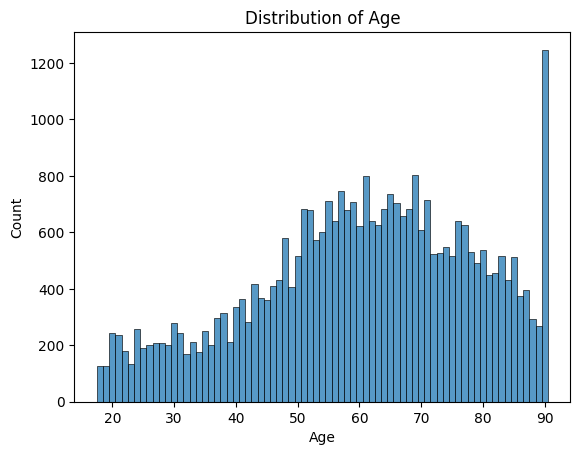

In [31]:
hist = sns.histplot(data=chexpert_test_csv, x='Age', multiple='dodge', discrete=True)

plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Distribution of Age")
plt.show()

As you can see there is a huge spike in the distribution of ages. Specifically in ***patients in ages around 90***.  
Lets check out the number of patients after 74 years old that accumulate 75% patients overall.


In [32]:
above74 = chexpert_test_csv[chexpert_test_csv['Age'] > 74]
above74['Age'].value_counts()

Age
90    1247
76     640
77     626
80     537
78     532
75     518
83     516
85     511
79     492
82     457
81     449
84     431
87     396
86     374
88     292
89     270
Name: count, dtype: int64

### 📝 [**'AgeGroup'**] Bins and grouping decision:

There is an ***obvious spike*** of distribution of patients at ***specific age of 90***.  


Looking at the overall information of the Age distribution, I decided to break the ages into 

5 seperate age ranges of **['0-20', '20-40', '40-60', '60-80', '80+']**

In [33]:
chexpert_test_csv_agegroup = chexpert_test_csv  # to not directly affect the test data

bins = [0, 20, 40, 60, 80, 90]  # Custom age bins based on quartiles and age.describe() stats
age_labels = ['0-20', '20-40', '40-60', '60-80', '80+']  # Labels for the age groups
# Create the AgeGroup column with pd.cut()
chexpert_test_csv_agegroup['AgeGroup'] = pd.cut(chexpert_test_csv_agegroup['Age'], bins=bins, labels=age_labels, right=True, include_lowest=True)
chexpert_test_csv_agegroup.head(10)

Path     Sex  Age  \
0  CheXpert-v1.0-small/train/patient00010/study1/...  Female   50   
1  CheXpert-v1.0-small/train/patient00010/study1/...  Female   50   
2  CheXpert-v1.0-small/train/patient00017/study1/...  Female   56   
3  CheXpert-v1.0-small/train/patient00017/study2/...  Female   56   
4  CheXpert-v1.0-small/train/patient00056/study1/...    Male   88   
5  CheXpert-v1.0-small/train/patient00056/study1/...    Male   88   
6  CheXpert-v1.0-small/train/patient00056/study4/...    Male   88   
7  CheXpert-v1.0-small/train/patient00056/study3/...    Male   88   
8  CheXpert-v1.0-small/train/patient00056/study2/...    Male   88   
9  CheXpert-v1.0-small/train/patient00061/study2/...    Male   90   

  Frontal/Lateral AP/PA  No Finding  Enlarged Cardiomediastinum  Cardiomegaly  \
0         Frontal    PA         1.0                         0.0           NaN   
1         Lateral   NaN         1.0                         0.0           NaN   
2         Frontal    AP         1.0                         NaN           0.0   
3         Frontal    AP         NaN                        -1.0           NaN   
4         Frontal    AP         NaN                         NaN           0.0   
5         Lateral   NaN         NaN                         NaN           0.0   
6         Frontal    AP         NaN                         NaN           1.0   
7         Frontal    AP         NaN                         NaN           NaN   
8         Frontal    AP         NaN                         NaN           NaN   
9         Frontal    PA         NaN                         NaN           1.0   

   Lung Opacity  Lung Lesion  ...  Consolidation  Pneumonia  Atelectasis  \
0           0.0          NaN  ...            NaN        NaN          NaN   
1           0.0          NaN  ...            NaN        NaN          NaN   
2           NaN          NaN  ...            NaN        NaN          NaN   
3           NaN          NaN  ...           -1.0        NaN          NaN   
4           1.0          NaN  ...            0.0        NaN          1.0   
5           1.0          NaN  ...            0.0        NaN          1.0   
6           1.0          NaN  ...            NaN        NaN          NaN   
7           1.0          NaN  ...            NaN        NaN          NaN   
8          -1.0          NaN  ...           -1.0        NaN         -1.0   
9           1.0          NaN  ...            NaN        NaN          NaN   

   Pneumothorax  Pleural Effusion  Pleural Other  Fracture  Support Devices  \
0           NaN               0.0            NaN       NaN              NaN   
1           NaN               0.0            NaN       NaN              NaN   
2           0.0               NaN            NaN       NaN              1.0   
3          -1.0              -1.0            NaN       NaN              1.0   
4           NaN               0.0            NaN       NaN              NaN   
5           NaN               0.0            NaN       NaN              NaN   
6           NaN               1.0            NaN       NaN              1.0   
7           NaN               1.0            NaN       NaN              1.0   
8           NaN               NaN            NaN       NaN              1.0   
9           0.0               1.0            NaN       NaN              1.0   

      PatientID AgeGroup  
0  patient00010    40-60  
1  patient00010    40-60  
2  patient00017    40-60  
3  patient00017    40-60  
4  patient00056      80+  
5  patient00056      80+  
6  patient00056      80+  
7  patient00056      80+  
8  patient00056      80+  
9  patient00061      80+  

[10 rows x 21 columns]

##### 📊[**'AgeGroup'**] Distribution Histogram

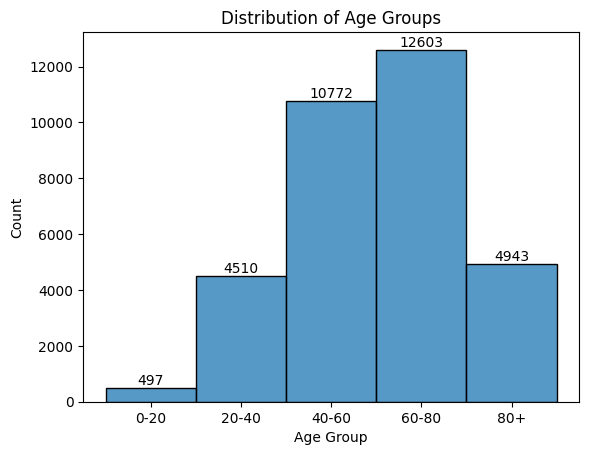

In [34]:
hist = sns.histplot(data=chexpert_test_csv_agegroup, x='AgeGroup', multiple='dodge', discrete=True)
for container in hist.containers:
    hist.bar_label(container, fmt='%d', label_type='edge')  # Add integer labels to the top of the bars
# Plot the histogram of the AgeGroup column

plt.xlabel("Age Group")
plt.ylabel("Count")
plt.title("Distribution of Age Groups")
plt.show()

While this seems to show that 90 year old patients have the shorter bar in the distribution count of the Age Group,  
But its important to remember that this count is just for a single age.

### 📝 [**'AgeGroup'**] Analysis

seperating the labels according to age groups

In [72]:
label_groups = {}
pp_groups = {}


for AgeGroup in age_labels:
    label_groups[AgeGroup] = labels_test_df[chexpert_test_csv_agegroup['AgeGroup'] == AgeGroup].to_numpy()
    pp_groups[AgeGroup] = pp_test_df[ chexpert_test_csv_agegroup['AgeGroup'] == AgeGroup].to_numpy()

# print(label_groups)
# print(pp_groups)

/tmp/ipykernel_2707232/1161311229.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  label_groups[AgeGroup] = labels_test_df[chexpert_test_csv_agegroup['AgeGroup'] == AgeGroup].to_numpy()
/tmp/ipykernel_2707232/1161311229.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pp_groups[AgeGroup] = pp_test_df[ chexpert_test_csv_agegroup['AgeGroup'] == AgeGroup].to_numpy()
/tmp/ipykernel_2707232/1161311229.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  label_groups[AgeGroup] = labels_test_df[chexpert_test_csv_agegroup['AgeGroup'] == AgeGroup].to_numpy()
/tmp/ipykernel_2707232/1161311229.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pp_groups[AgeGroup] = pp_test_df[ chexpert_test_csv_agegroup['AgeGroup'] == AgeGroup].to_numpy()
/tmp/ipykernel_2707232/1161311229.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  label_grou

#### 📊📈🔢[**'AgeGroup'**] plots and graphs

##### 🔢🔢[**'AgeGroup'**] PLOT **Confusion Matrix**

AgeGroup: 0-49


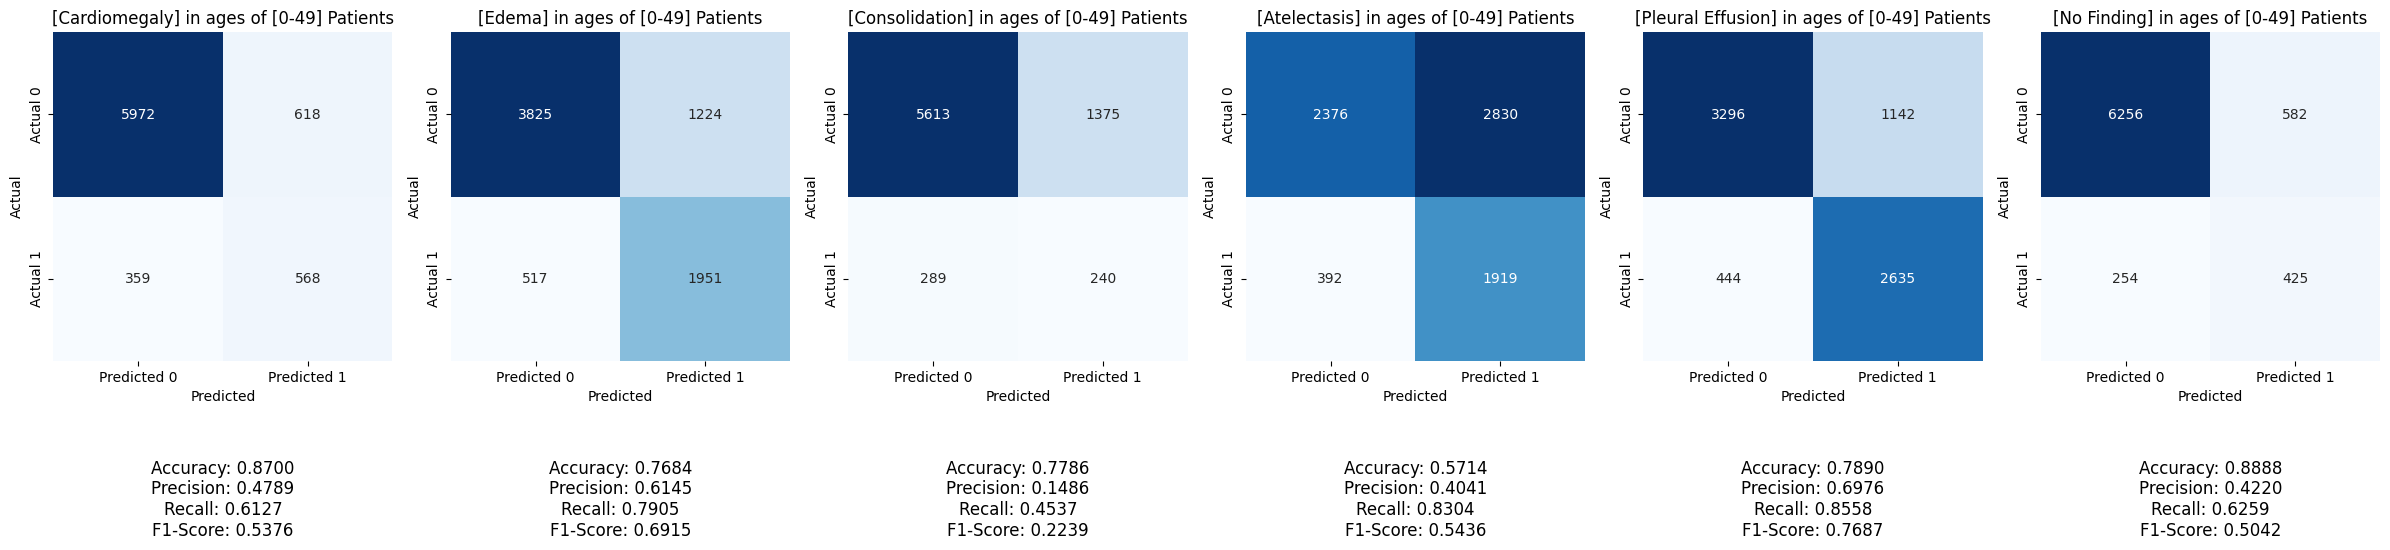

AgeGroup: 50-62


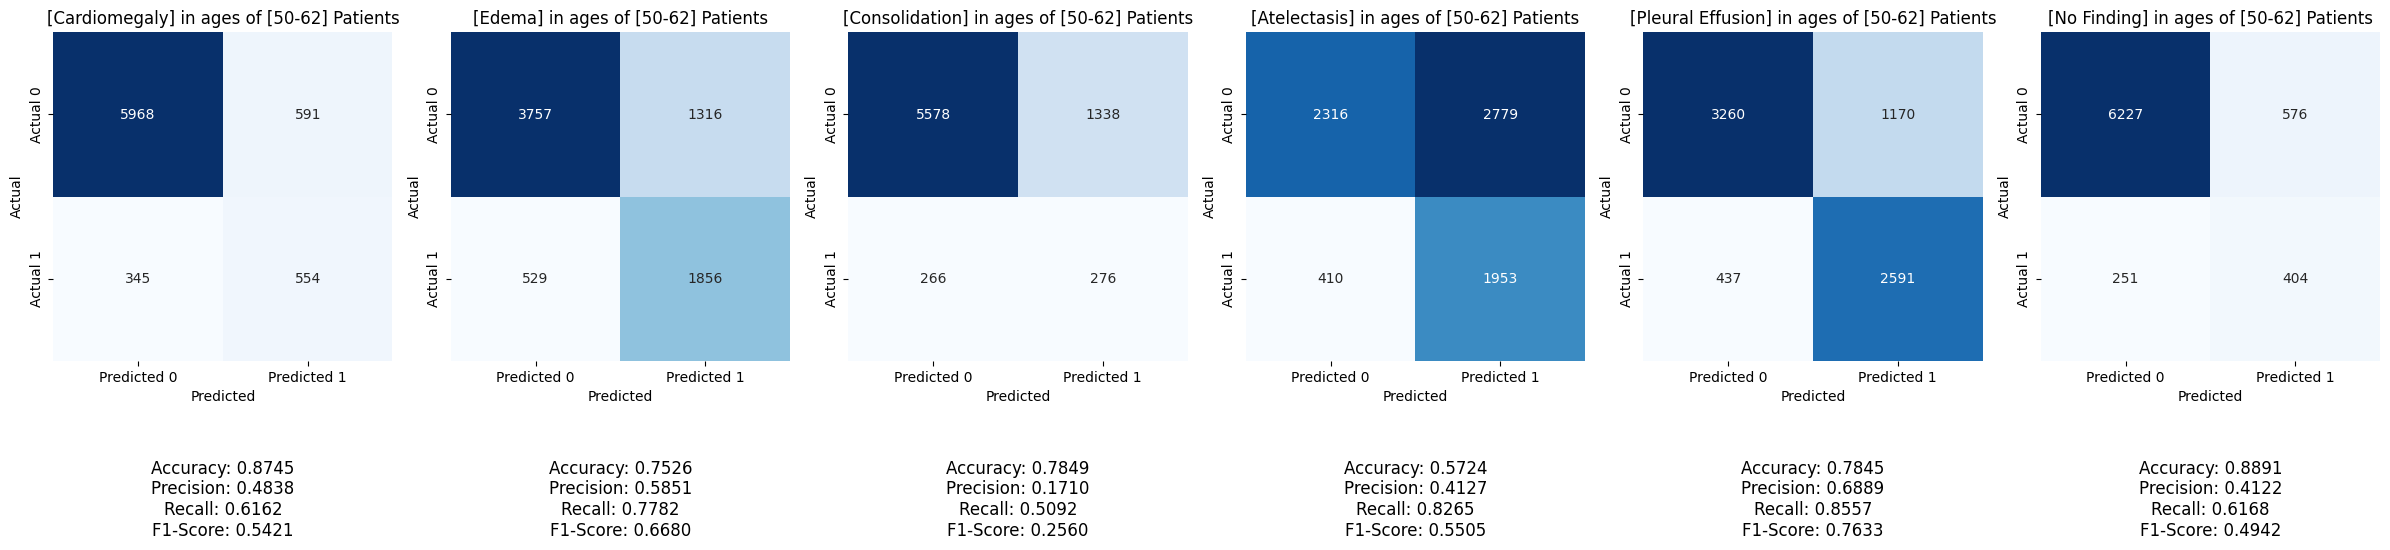

AgeGroup: 63-74


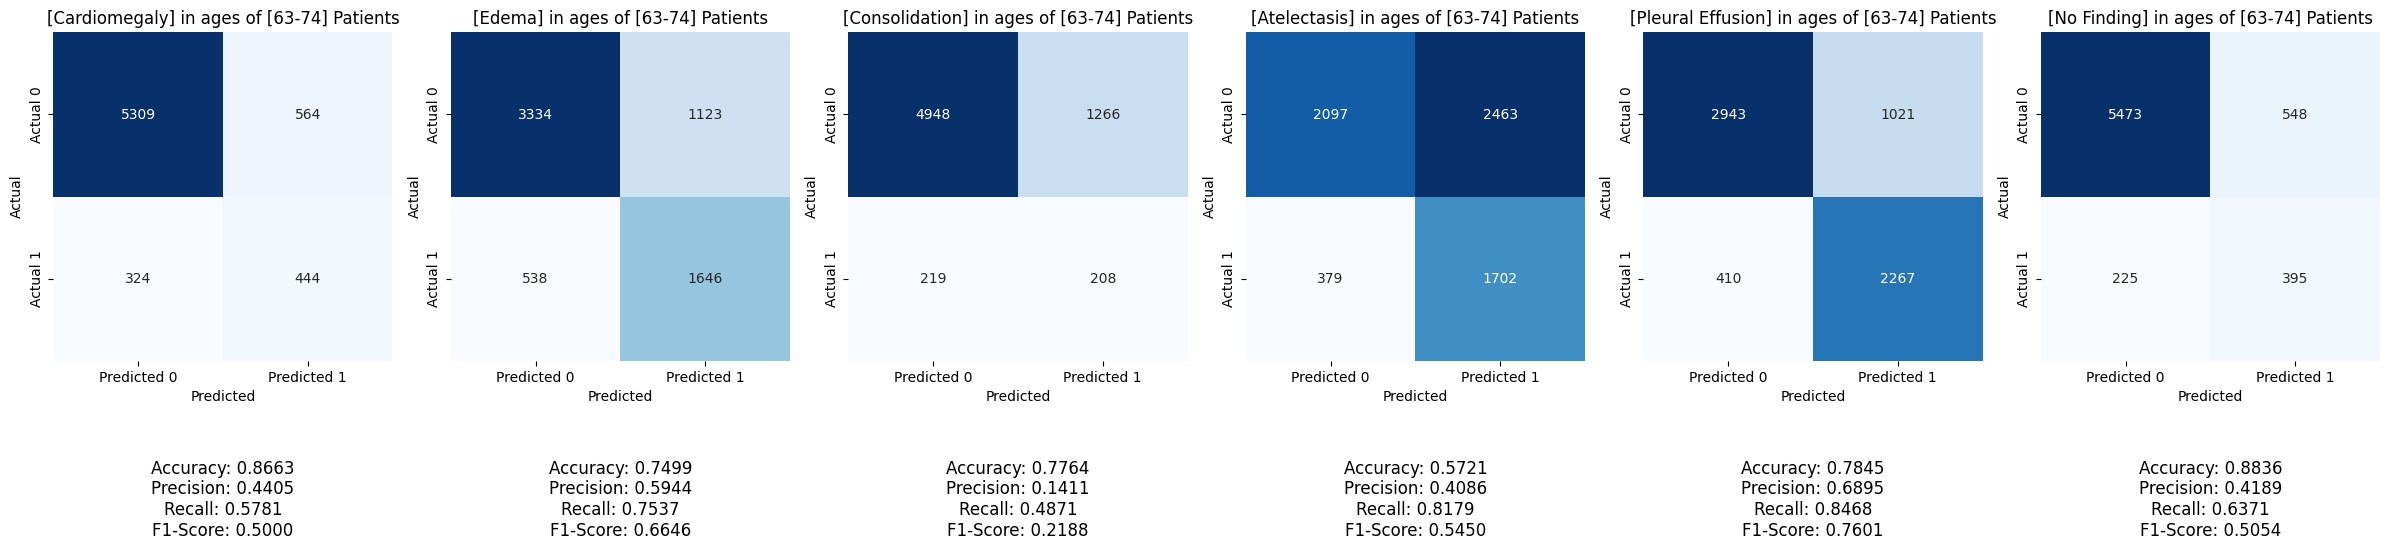

AgeGroup: 75-89


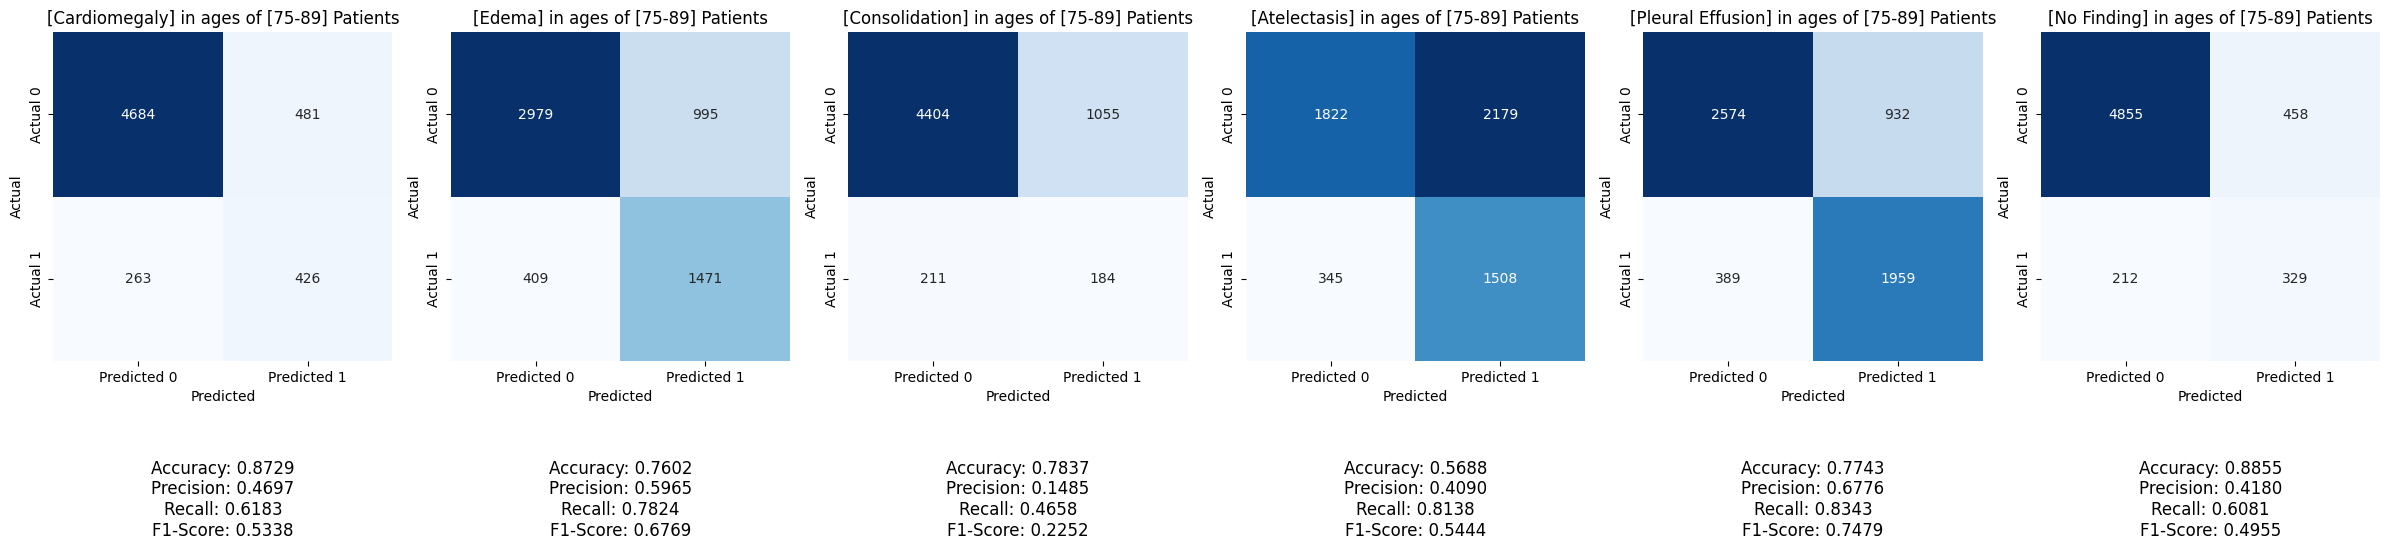

AgeGroup: 90


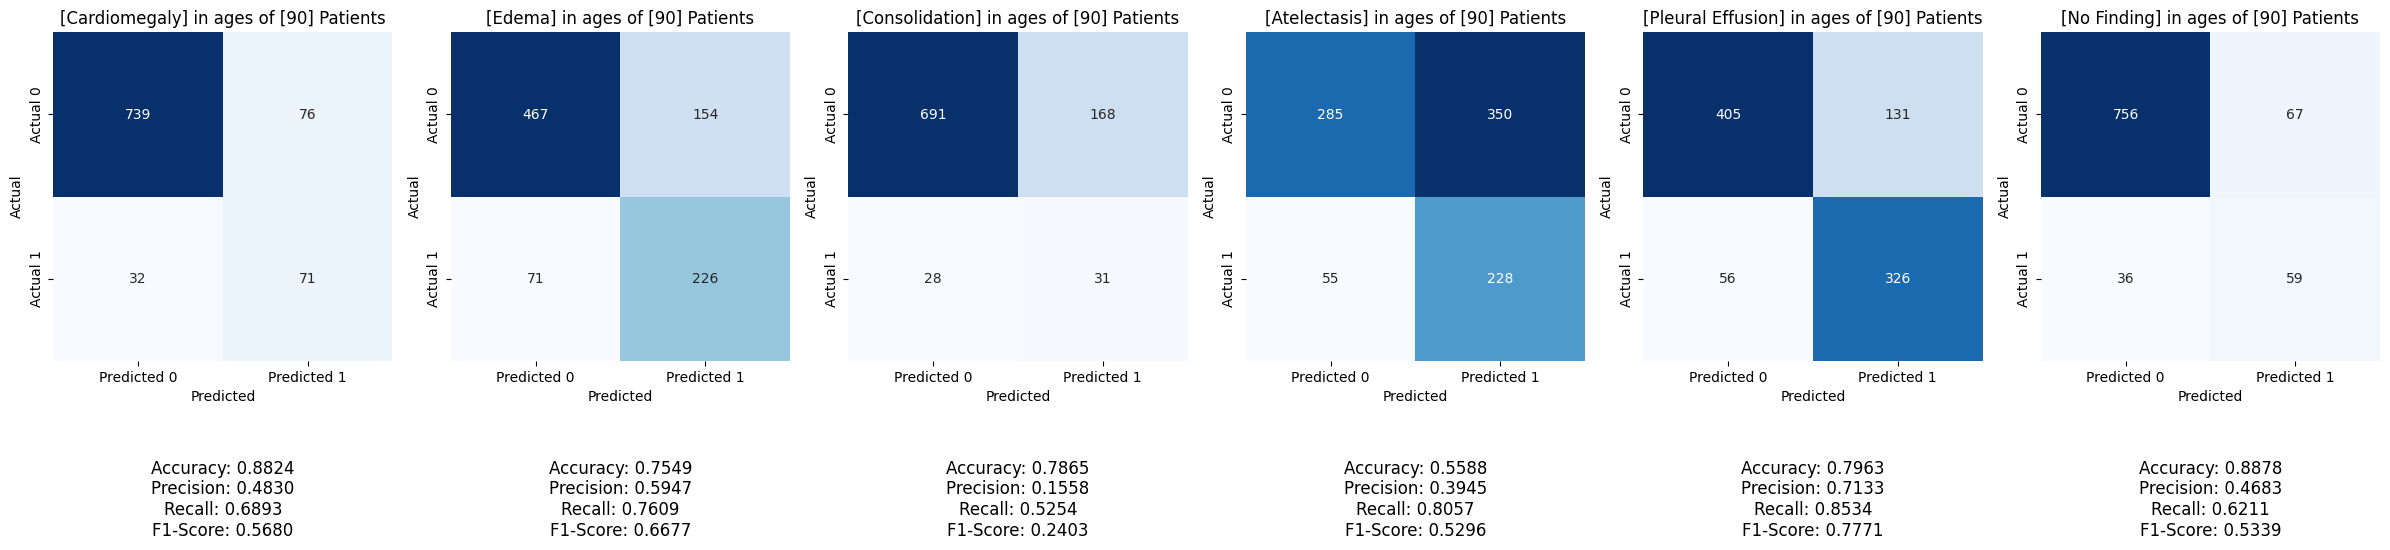

In [73]:
# ---------------------------------------------------------------------------- #
#                             PLOT confusion_matrix                            #
# ---------------------------------------------------------------------------- #
for AgeGroup in pp_groups:
    predicted_labels = apply_thresholds(pp_groups[AgeGroup], thresholds)
    print(f"AgeGroup: {AgeGroup}")
    plot_confusion_matrices(label_groups[AgeGroup], predicted_labels, f'ages of [{AgeGroup}]')

# plot_confusion_matrices(male_gtl, apply_thresholds(male_pp, find_best_threshold(male_pp, male_gtl)))

##### 📈📈 [**'AgeGroup'**] PLOT **ROC**s

/local/home/rezajam/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_plot/roc_curve.py:171: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")
/local/home/rezajam/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_plot/roc_curve.py:171: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")
/local/home/rezajam/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_plot/roc_curve.py:171: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")
/local/home/rezajam/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_pl

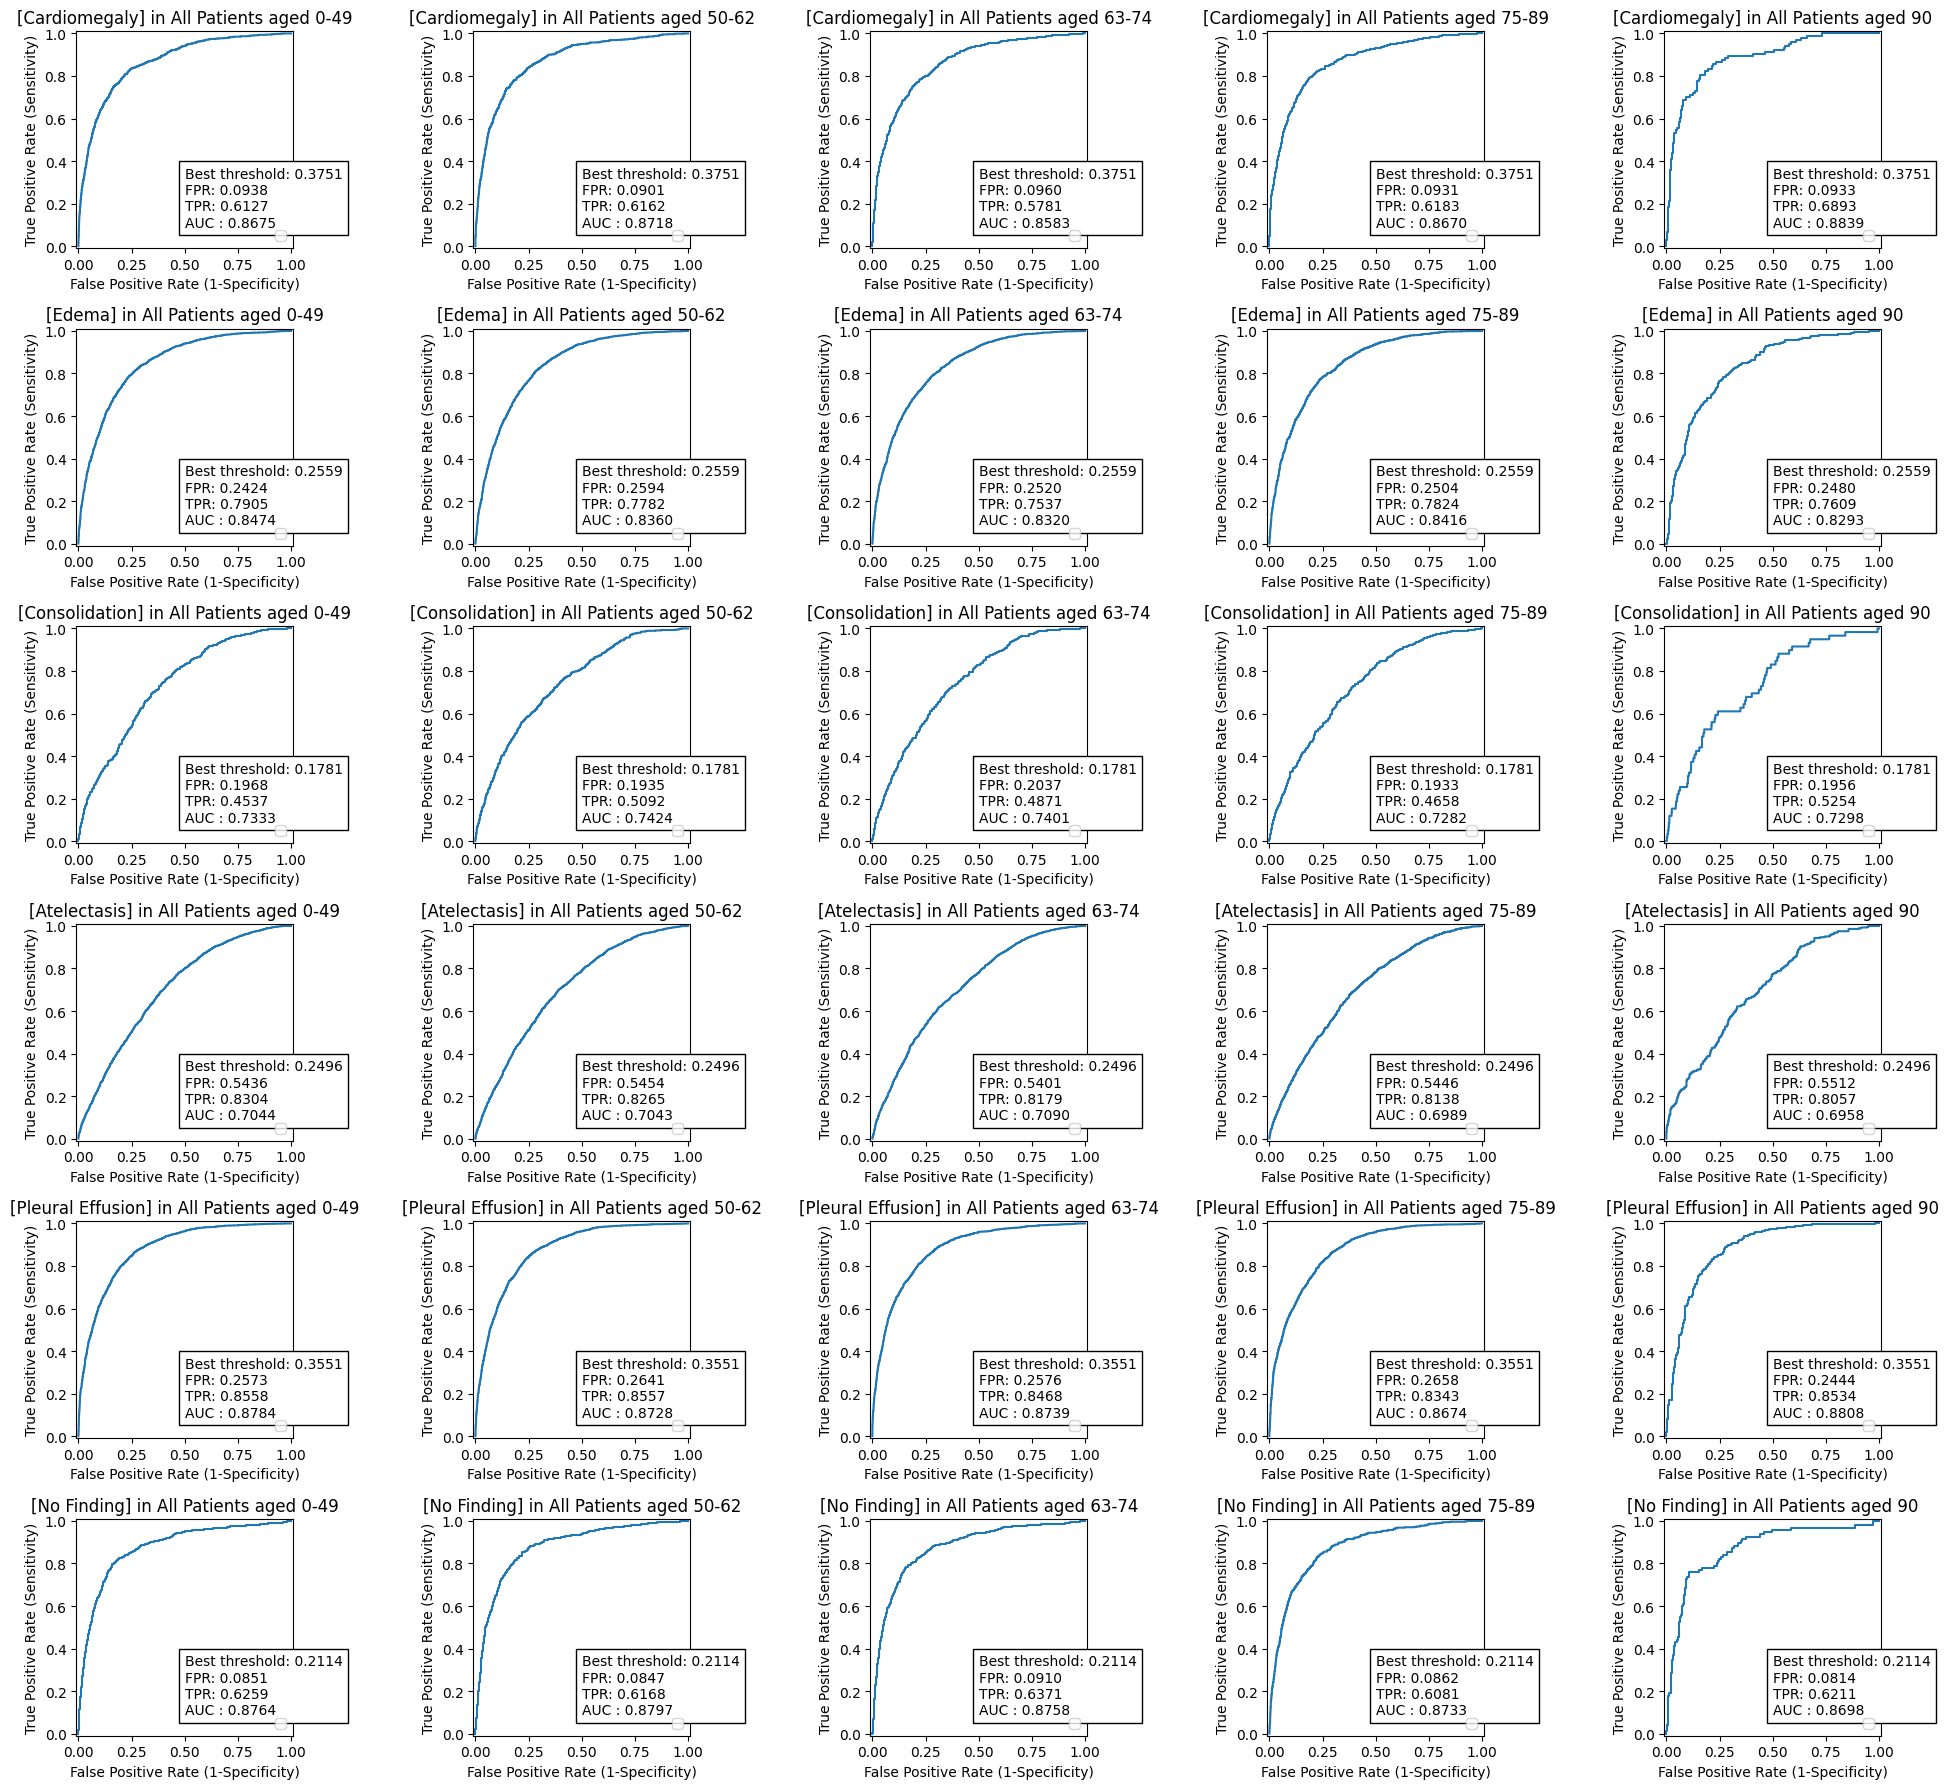

In [74]:
plot_roc_bigpicture(pp_groups,label_groups, 'All')

## 📝Performance Bias by ***Genders-AgeGroups***


#### 📊Overall distribution of Age Ranges with Genders

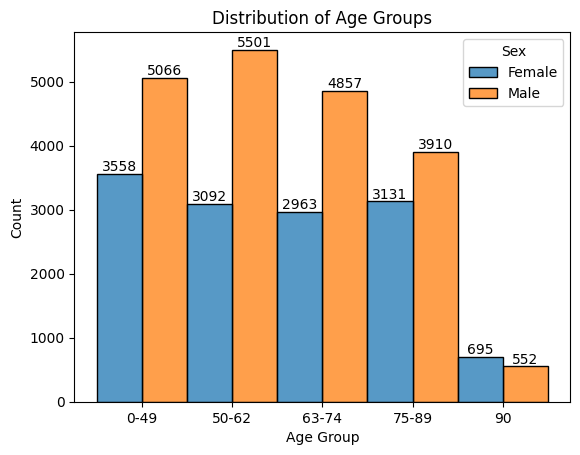

In [75]:
import pandas as pd

bins = [0, 49, 62, 74, 89, 90]  # Custom age bins based on quartiles and age.describe() stats
age_labels = ['0-49', '50-62', '63-74', '75-89', '90']  # Labels for the age groups

# Create the AgeGroup column with pd.cut()
chexpert_test_csv_agegroup['AgeGroup'] = pd.cut(chexpert_test_csv_agegroup['Age'], bins=bins, labels=age_labels, right=True, include_lowest=True)


import seaborn as sns
import matplotlib.pyplot as plt
hist = sns.histplot(data=chexpert_test_csv_agegroup, x='AgeGroup',  hue='Sex', multiple='dodge', discrete=True)
for container in hist.containers:
    hist.bar_label(container, fmt='%d', label_type='edge')  # Add integer labels to the top of the bars
# Plot the histogram of the AgeGroup column

plt.xlabel("Age Group")
plt.ylabel("Count")
plt.title("Distribution of Age Groups")
plt.show()




### 📝[**'Male-AgeGroup'**] Analysis


In [76]:
male_label_groups = {}
male_pp_groups = {}

# labels_test
for AgeGroup in age_labels:
    male_label_groups[AgeGroup] = labels_test_df[(chexpert_test_csv_agegroup['AgeGroup'] == AgeGroup) & (chexpert_test_csv_agegroup['Sex'] == 'Male')].to_numpy()
    male_pp_groups[AgeGroup] = pp_test_df[(chexpert_test_csv_agegroup['AgeGroup'] == AgeGroup) & (chexpert_test_csv_agegroup['Sex'] == 'Male')].to_numpy()


/tmp/ipykernel_2707232/5984806.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_label_groups[AgeGroup] = labels_test_df[(chexpert_test_csv_agegroup['AgeGroup'] == AgeGroup) & (chexpert_test_csv_agegroup['Sex'] == 'Male')].to_numpy()
/tmp/ipykernel_2707232/5984806.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_pp_groups[AgeGroup] = pp_test_df[(chexpert_test_csv_agegroup['AgeGroup'] == AgeGroup) & (chexpert_test_csv_agegroup['Sex'] == 'Male')].to_numpy()
/tmp/ipykernel_2707232/5984806.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_label_groups[AgeGroup] = labels_test_df[(chexpert_test_csv_agegroup['AgeGroup'] == AgeGroup) & (chexpert_test_csv_agegroup['Sex'] == 'Male')].to_numpy()
/tmp/ipykernel_2707232/5984806.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_pp_groups[AgeGroup] = pp_test_df[(chexpert_test_csv_agegroup['AgeGro

#### 📊📈🔢[**'Male-AgeGroup'**] plots and graphs

##### 🔢🔢[**'Male-AgeGroup'**] PLOT **confusion_matrix**  
Multiple Confusion matrices of each label, over different Age groups

AgeGroup: 0-49


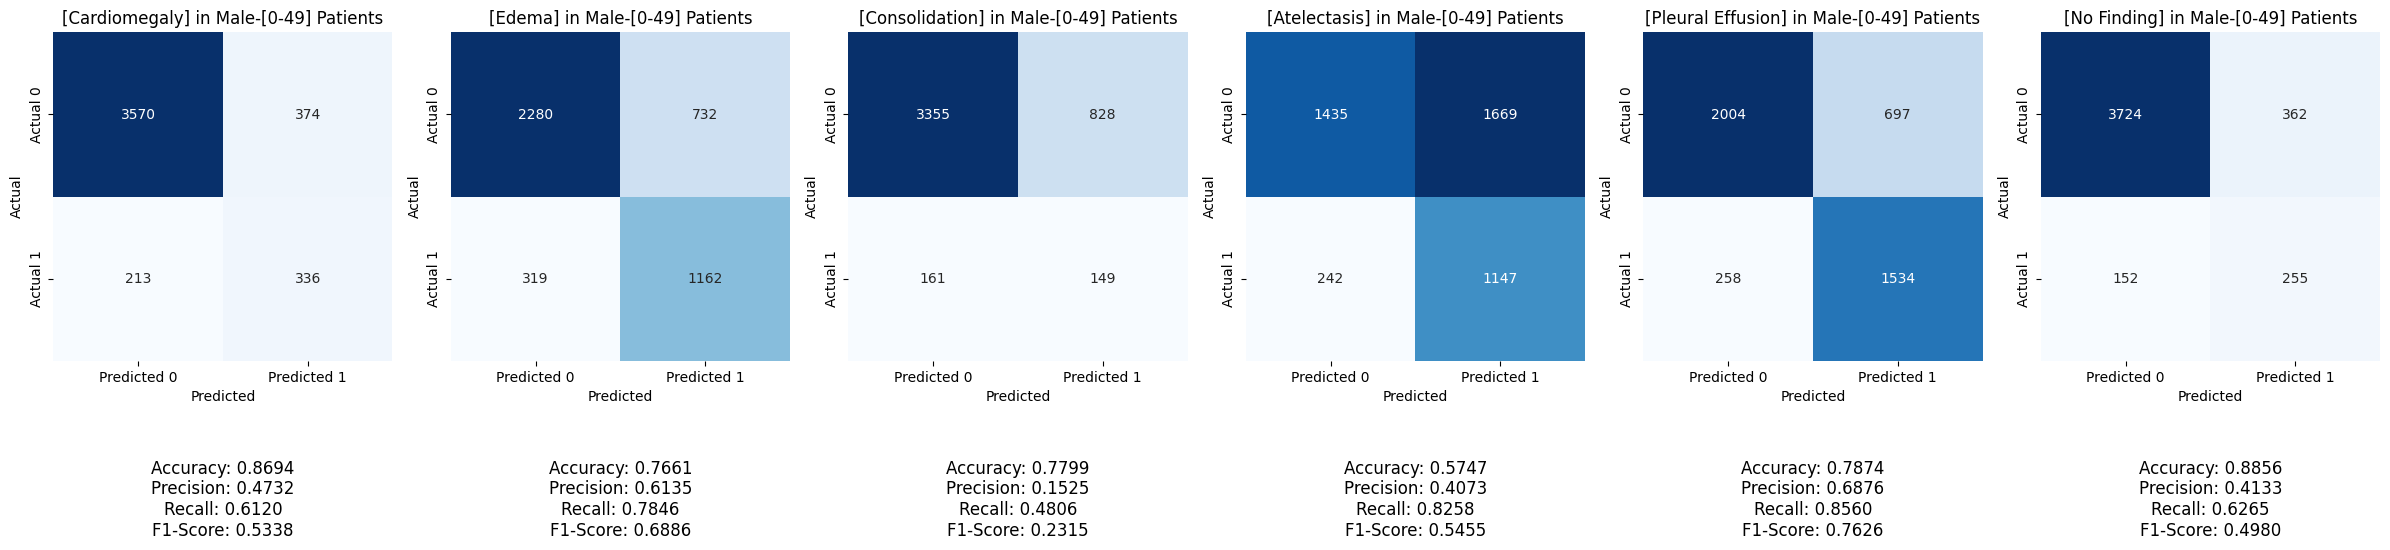

AgeGroup: 50-62


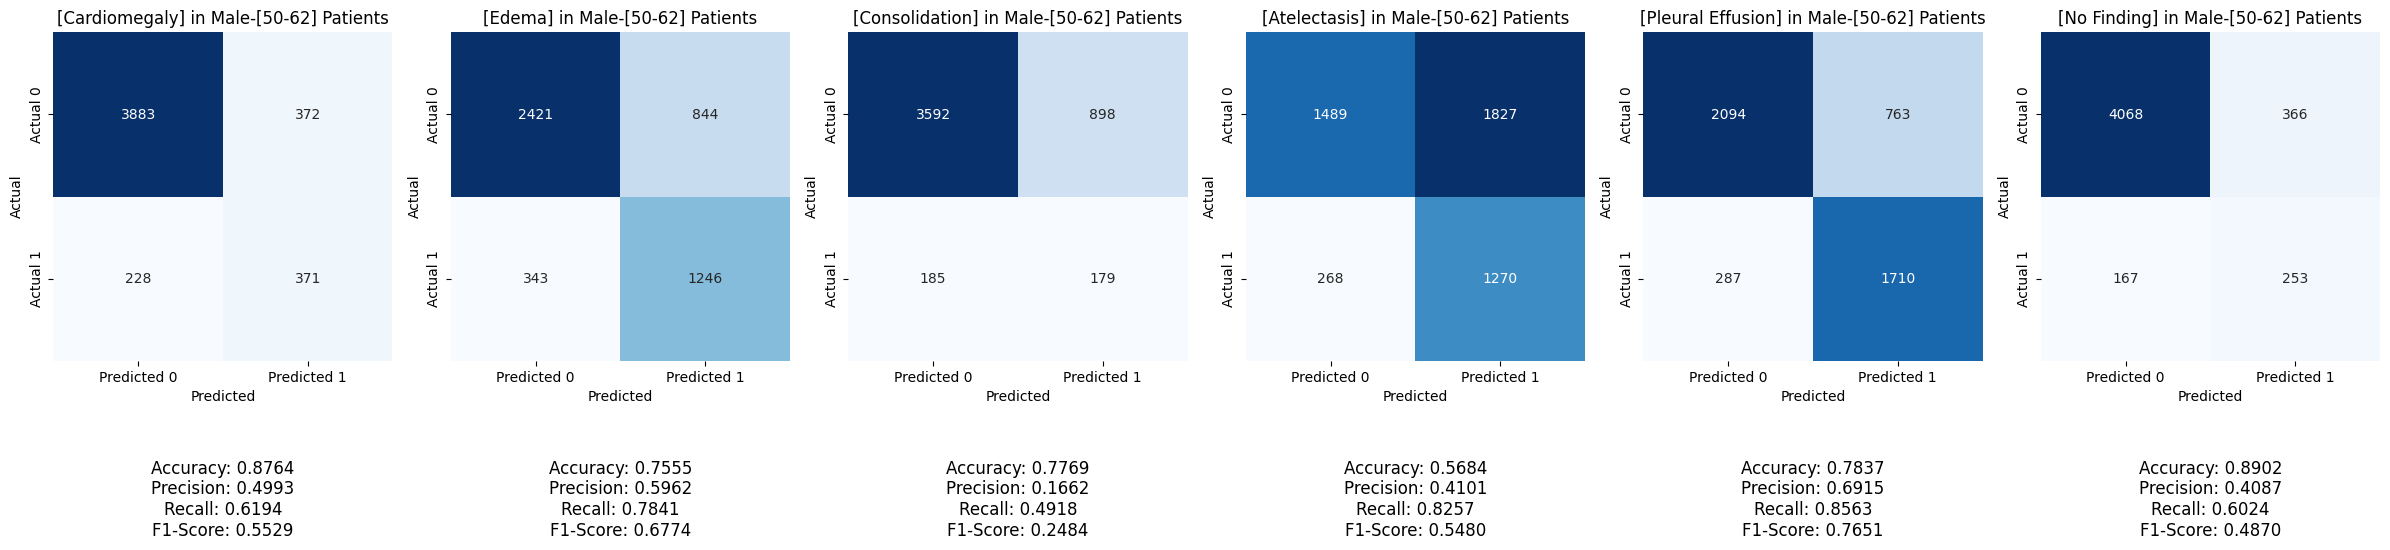

AgeGroup: 63-74


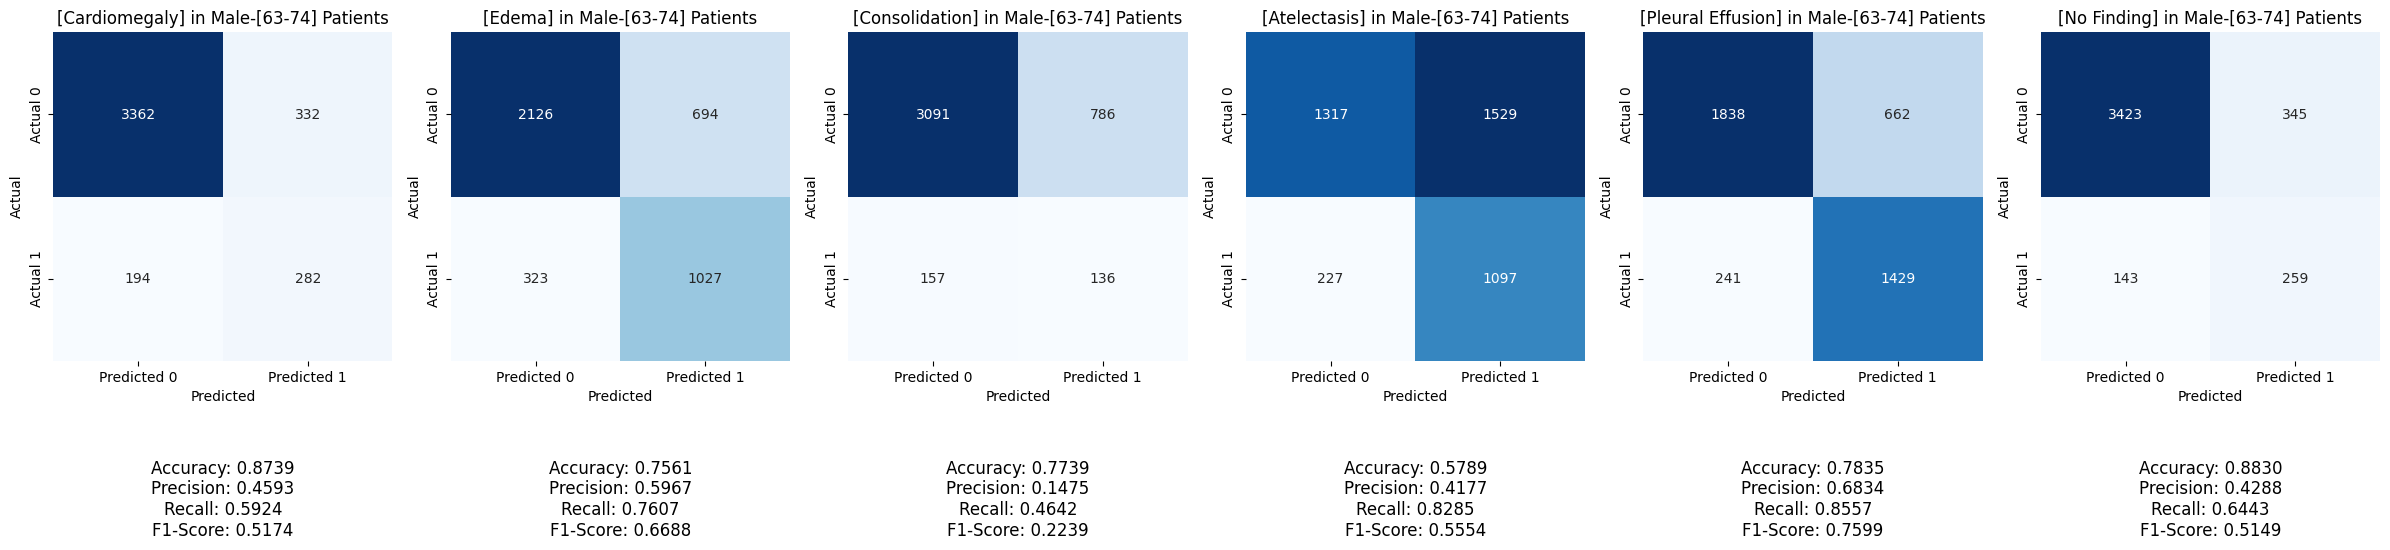

AgeGroup: 75-89


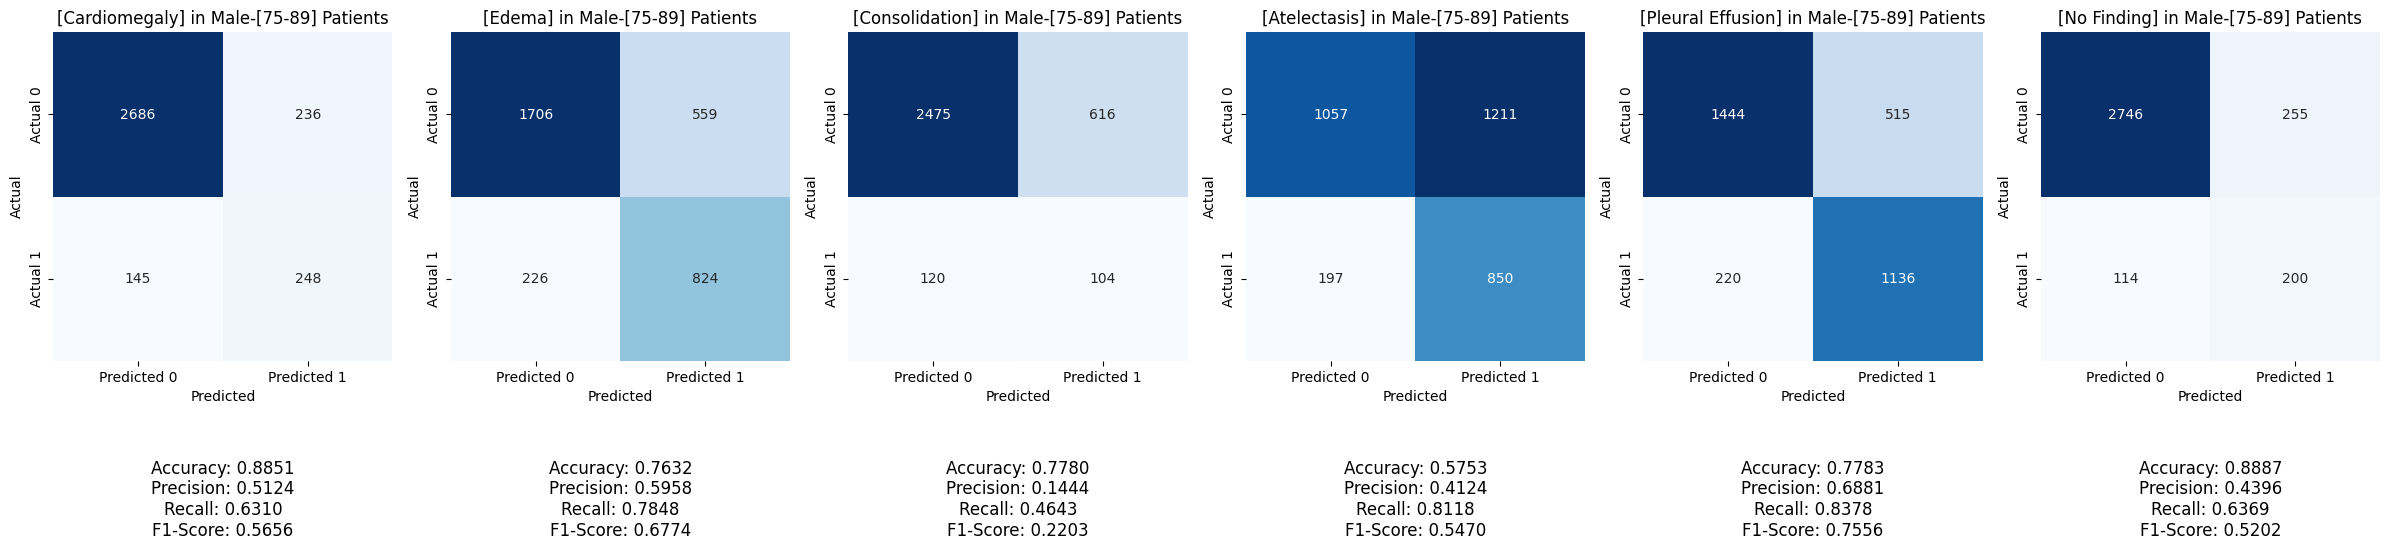

AgeGroup: 90


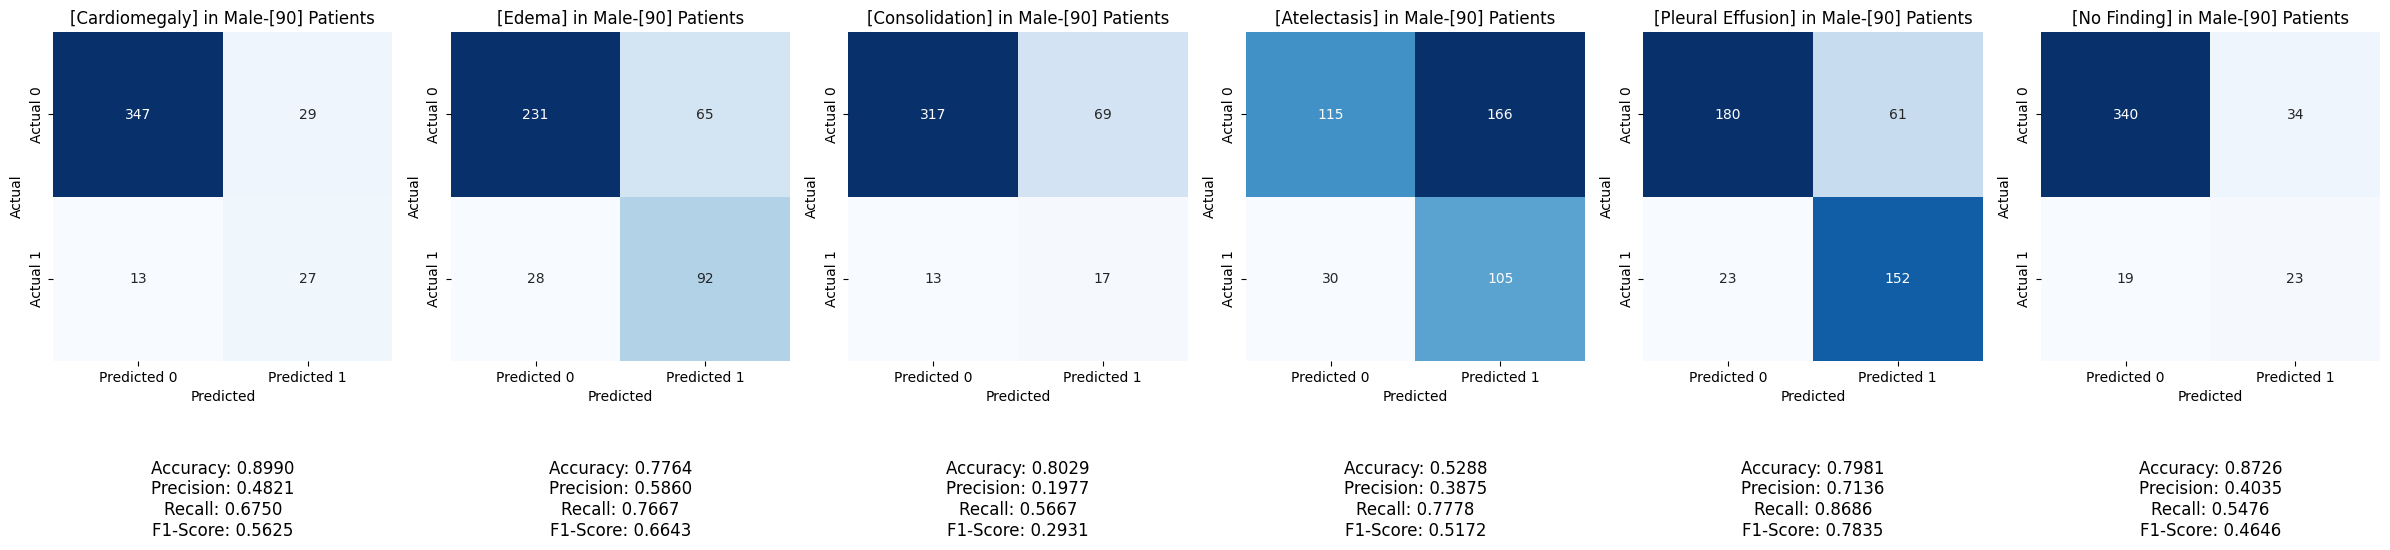

In [77]:
# ---------------------------------------------------------------------------- #
#                             PLOT confusion_matrix                            #
# ---------------------------------------------------------------------------- #
for AgeGroup in male_pp_groups:
    predicted_labels = apply_thresholds(male_pp_groups[AgeGroup], thresholds)
    print(f"AgeGroup: {AgeGroup}")
    plot_confusion_matrices(male_label_groups[AgeGroup], predicted_labels, f'Male-[{AgeGroup}]')

# plot_confusion_matrices(male_gtl, apply_thresholds(male_pp, find_best_threshold(male_pp, male_gtl)))

##### 📈📈 [**'Male-AgeGroup'**] PLOT **ROCs**  
Multiple ROCs of each label, over different Age groups

/local/home/rezajam/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_plot/roc_curve.py:171: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")
/local/home/rezajam/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_plot/roc_curve.py:171: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")
/local/home/rezajam/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_plot/roc_curve.py:171: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")
/local/home/rezajam/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_pl

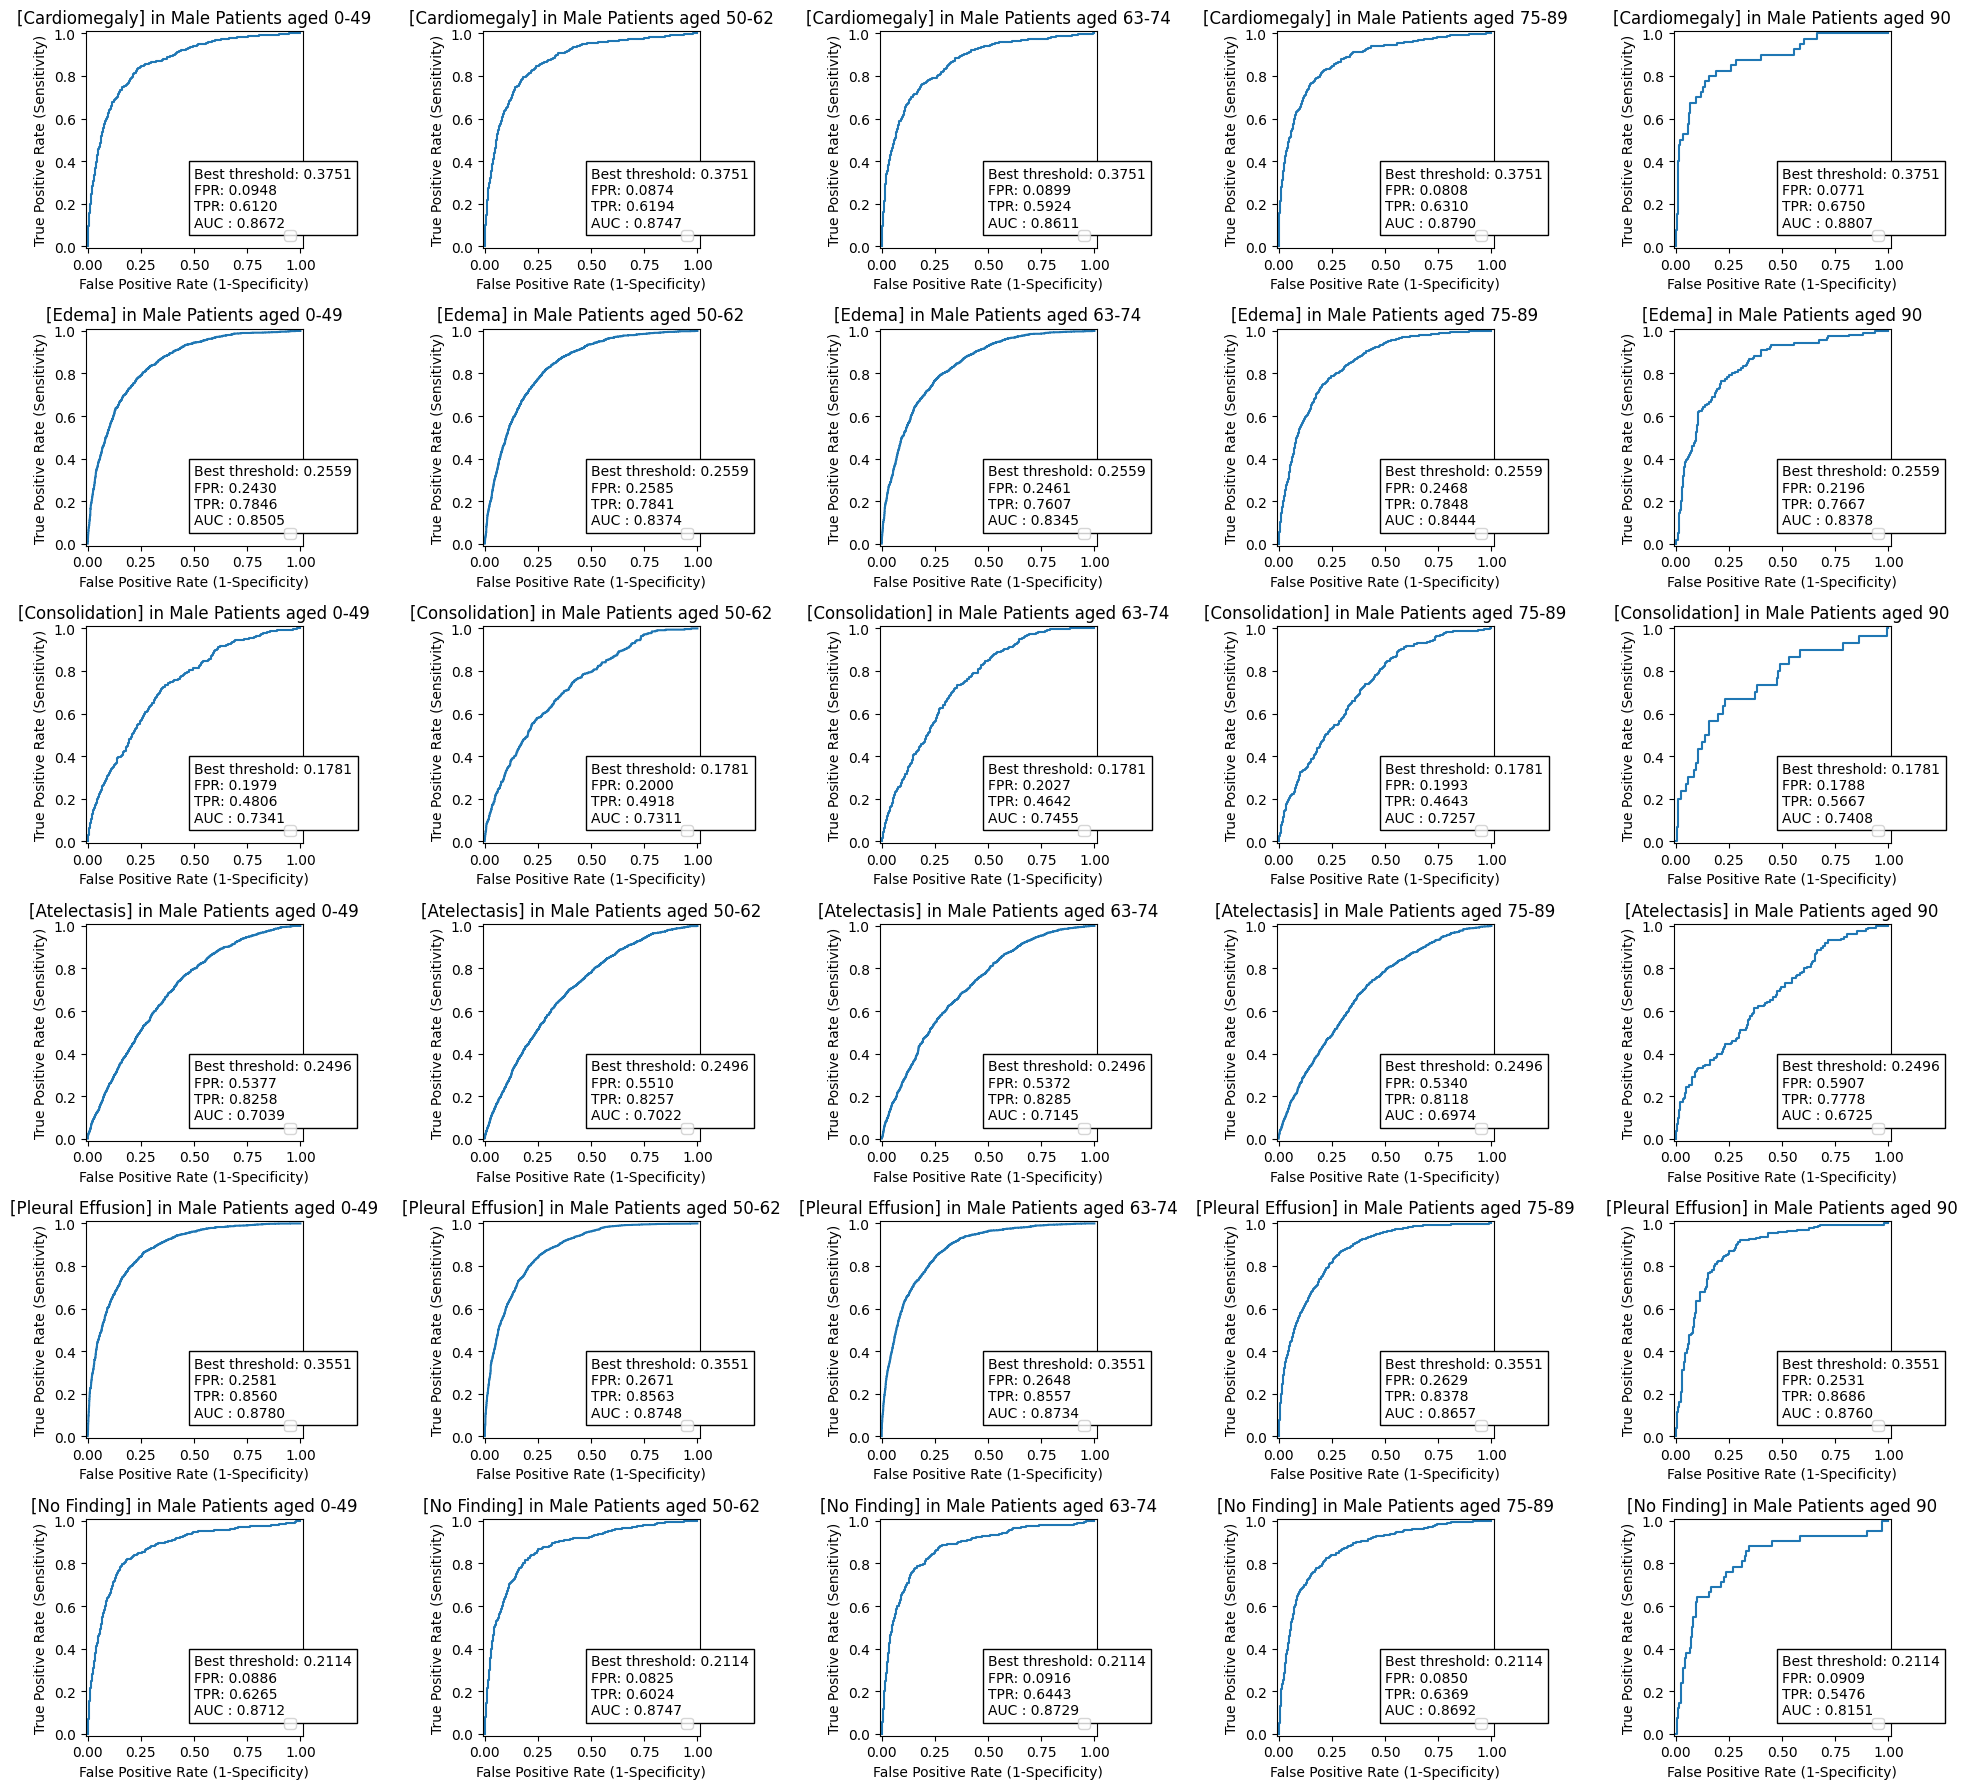

In [78]:
plot_roc_bigpicture(male_pp_groups,male_label_groups, 'Male')

### 📝[**'Female-AgeGroup'**] Analysis


In [79]:
female_label_groups = {}
female_pp_groups = {}

# labels_test
for AgeGroup in age_labels:
    female_label_groups[AgeGroup] = labels_test_df[(chexpert_test_csv_agegroup['AgeGroup'] == AgeGroup) & (chexpert_test_csv_agegroup['Sex'] == 'Female')].to_numpy()
    female_pp_groups[AgeGroup] = pp_test_df[(chexpert_test_csv_agegroup['AgeGroup'] == AgeGroup) & (chexpert_test_csv_agegroup['Sex'] == 'Female')].to_numpy()


/tmp/ipykernel_2707232/1756433991.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_label_groups[AgeGroup] = labels_test_df[(chexpert_test_csv_agegroup['AgeGroup'] == AgeGroup) & (chexpert_test_csv_agegroup['Sex'] == 'Female')].to_numpy()
/tmp/ipykernel_2707232/1756433991.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_pp_groups[AgeGroup] = pp_test_df[(chexpert_test_csv_agegroup['AgeGroup'] == AgeGroup) & (chexpert_test_csv_agegroup['Sex'] == 'Female')].to_numpy()
/tmp/ipykernel_2707232/1756433991.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_label_groups[AgeGroup] = labels_test_df[(chexpert_test_csv_agegroup['AgeGroup'] == AgeGroup) & (chexpert_test_csv_agegroup['Sex'] == 'Female')].to_numpy()
/tmp/ipykernel_2707232/1756433991.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_pp_groups[AgeGroup] = pp_test_df[(chexpert

##### 🔢🔢[**'Female-AgeGroup'**] PLOT **confusion_matrix**

AgeGroup: 0-49


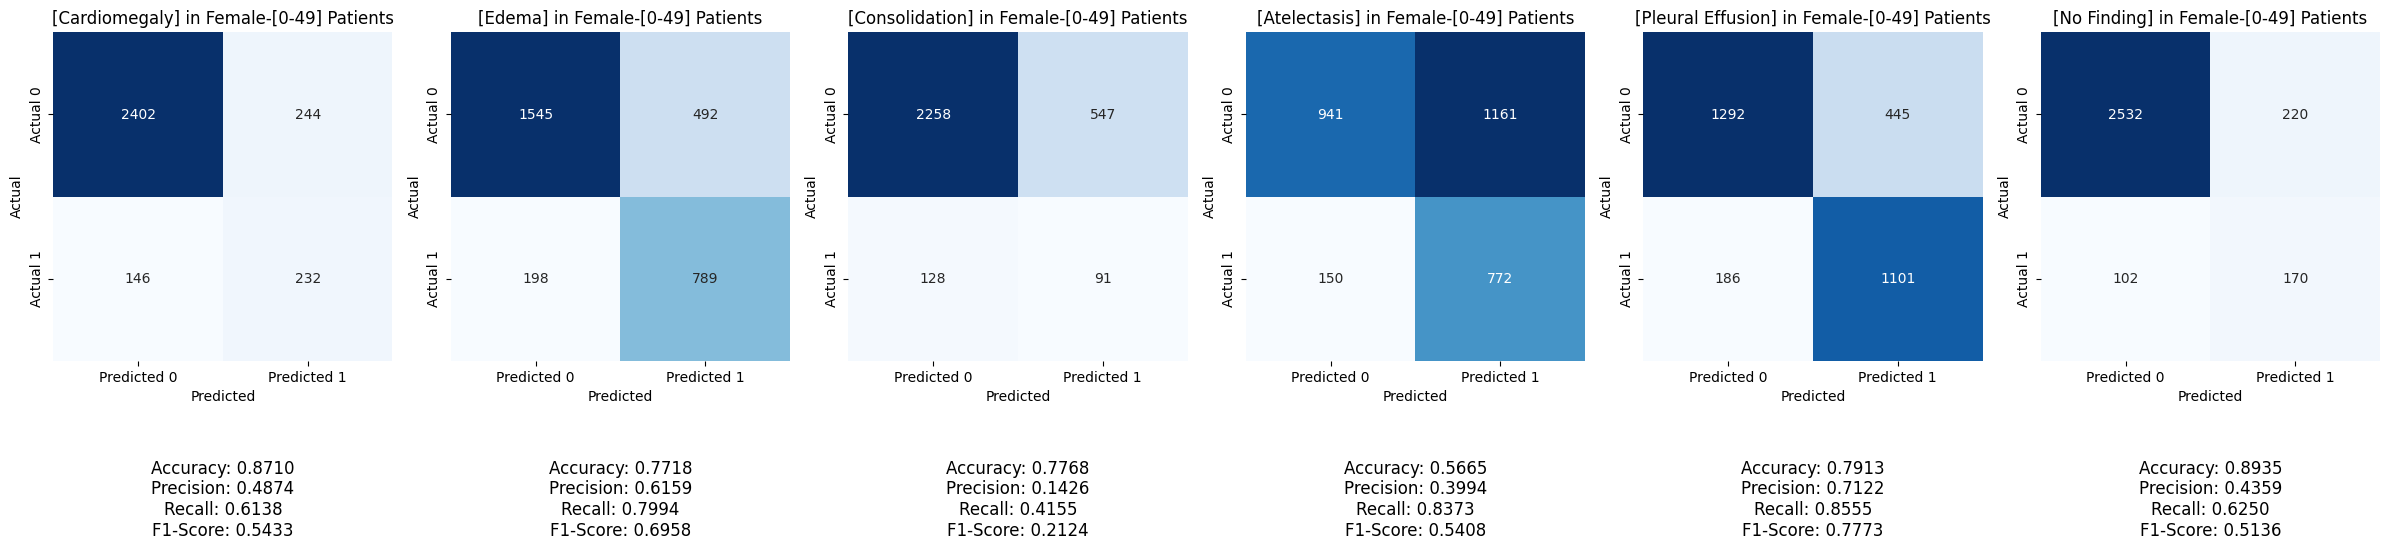

AgeGroup: 50-62


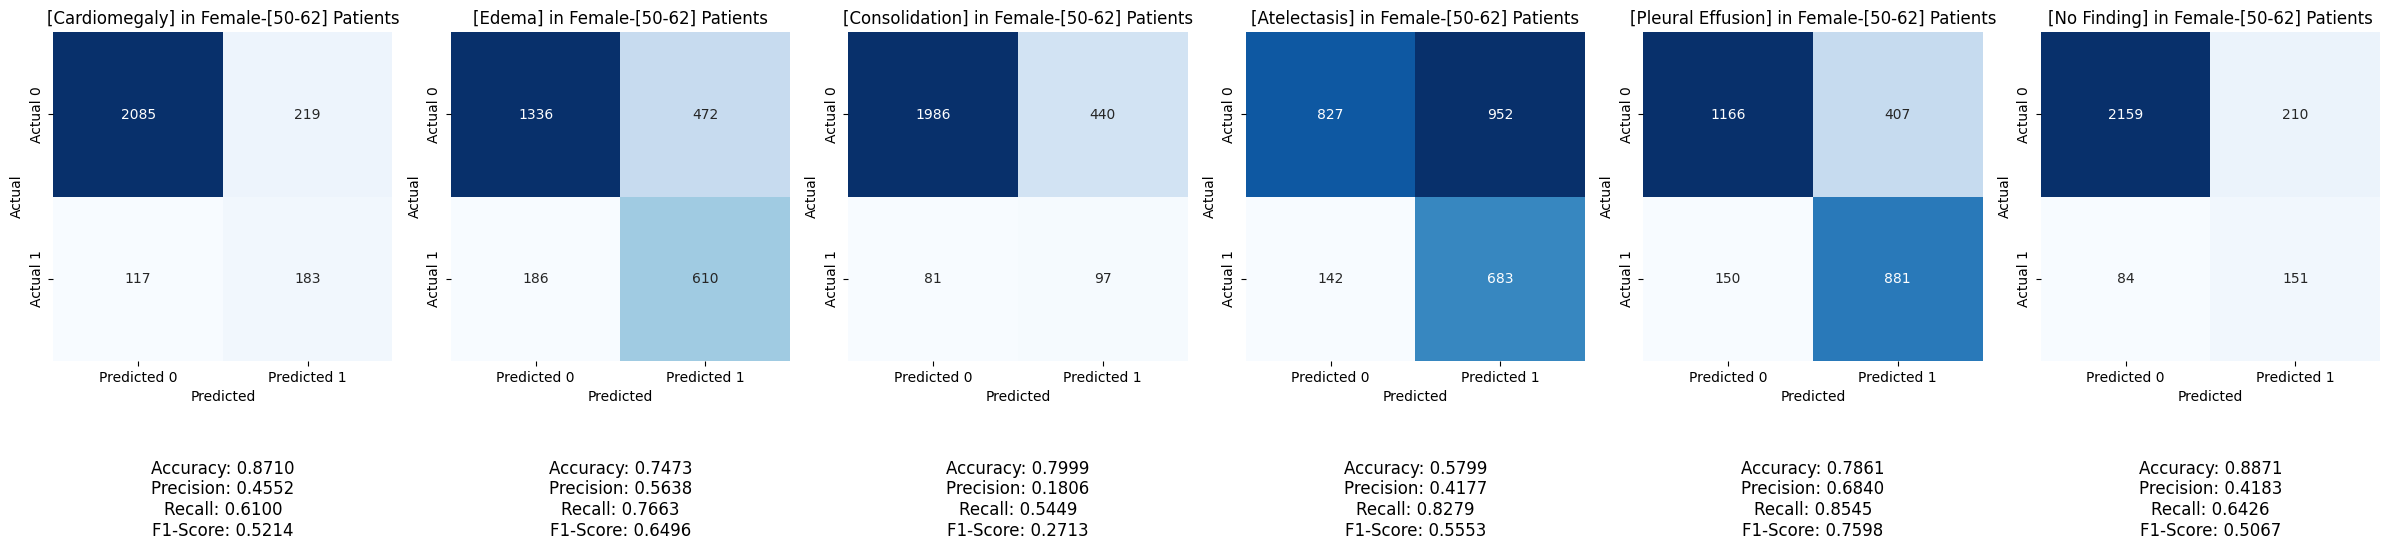

AgeGroup: 63-74


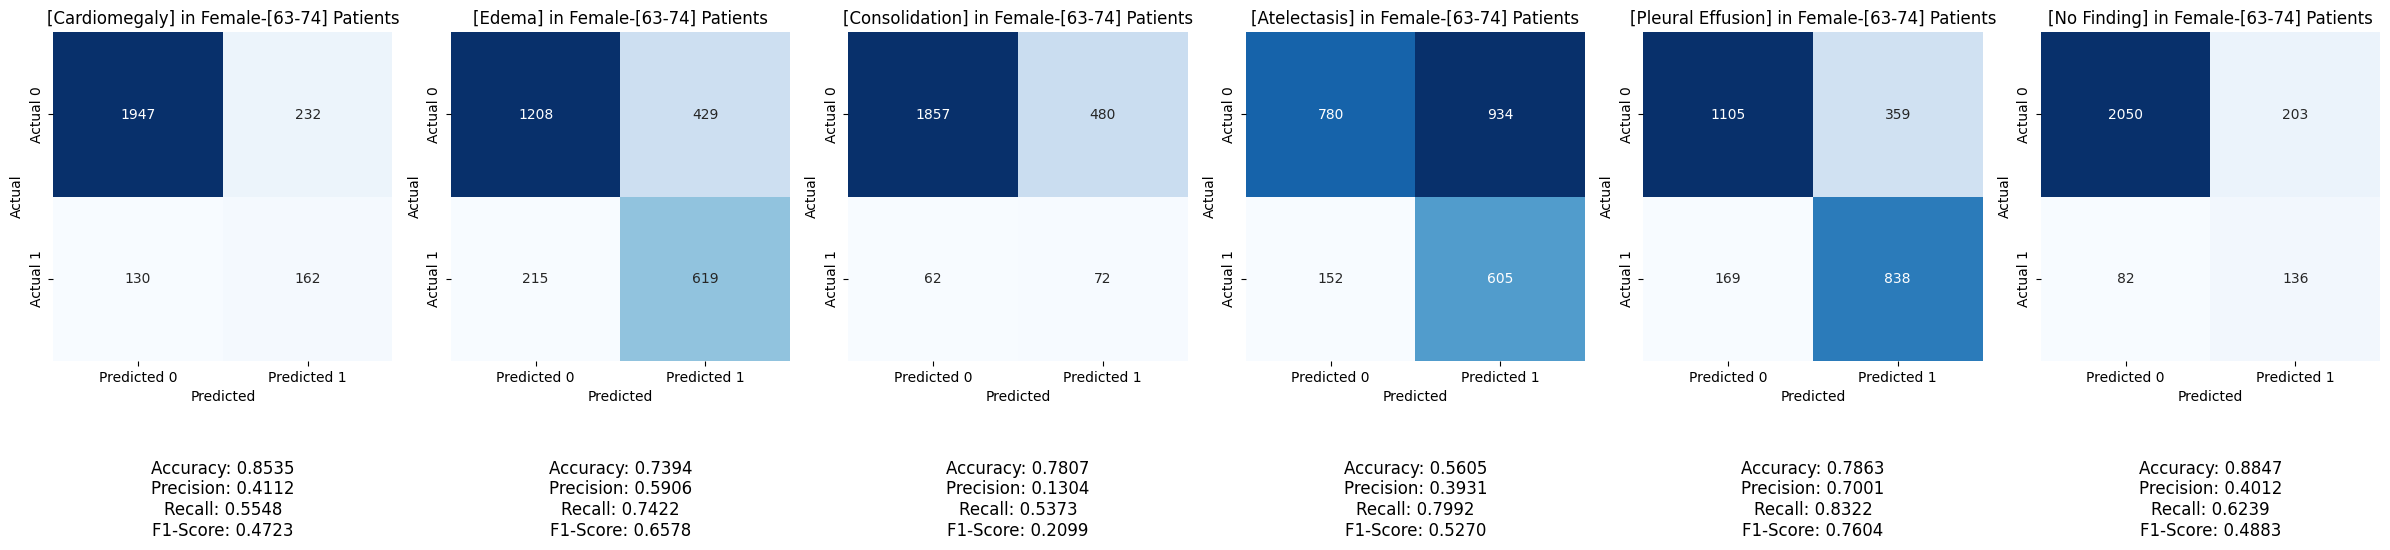

AgeGroup: 75-89


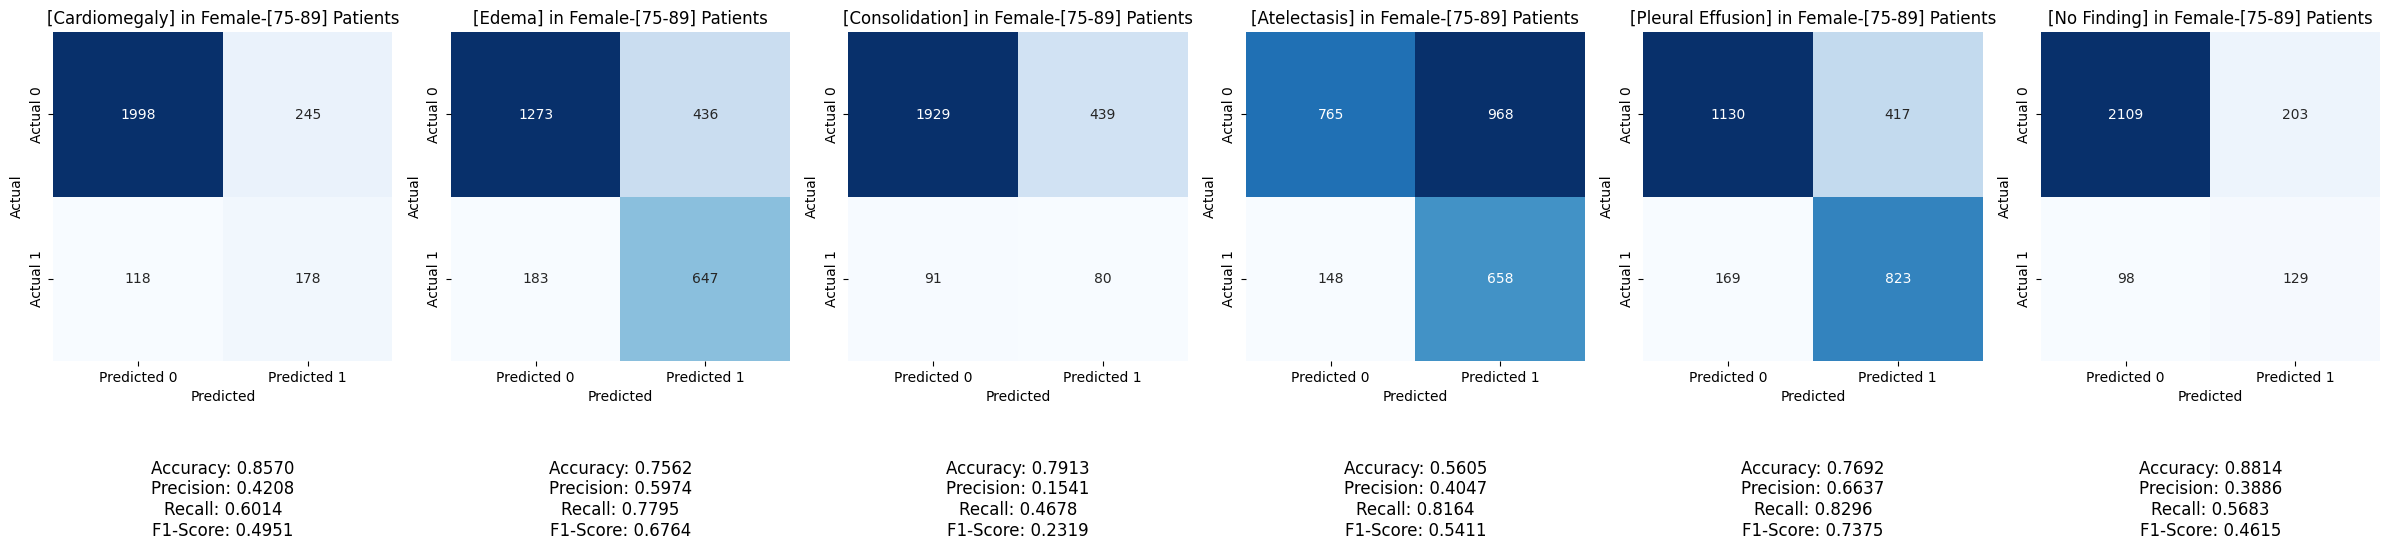

AgeGroup: 90


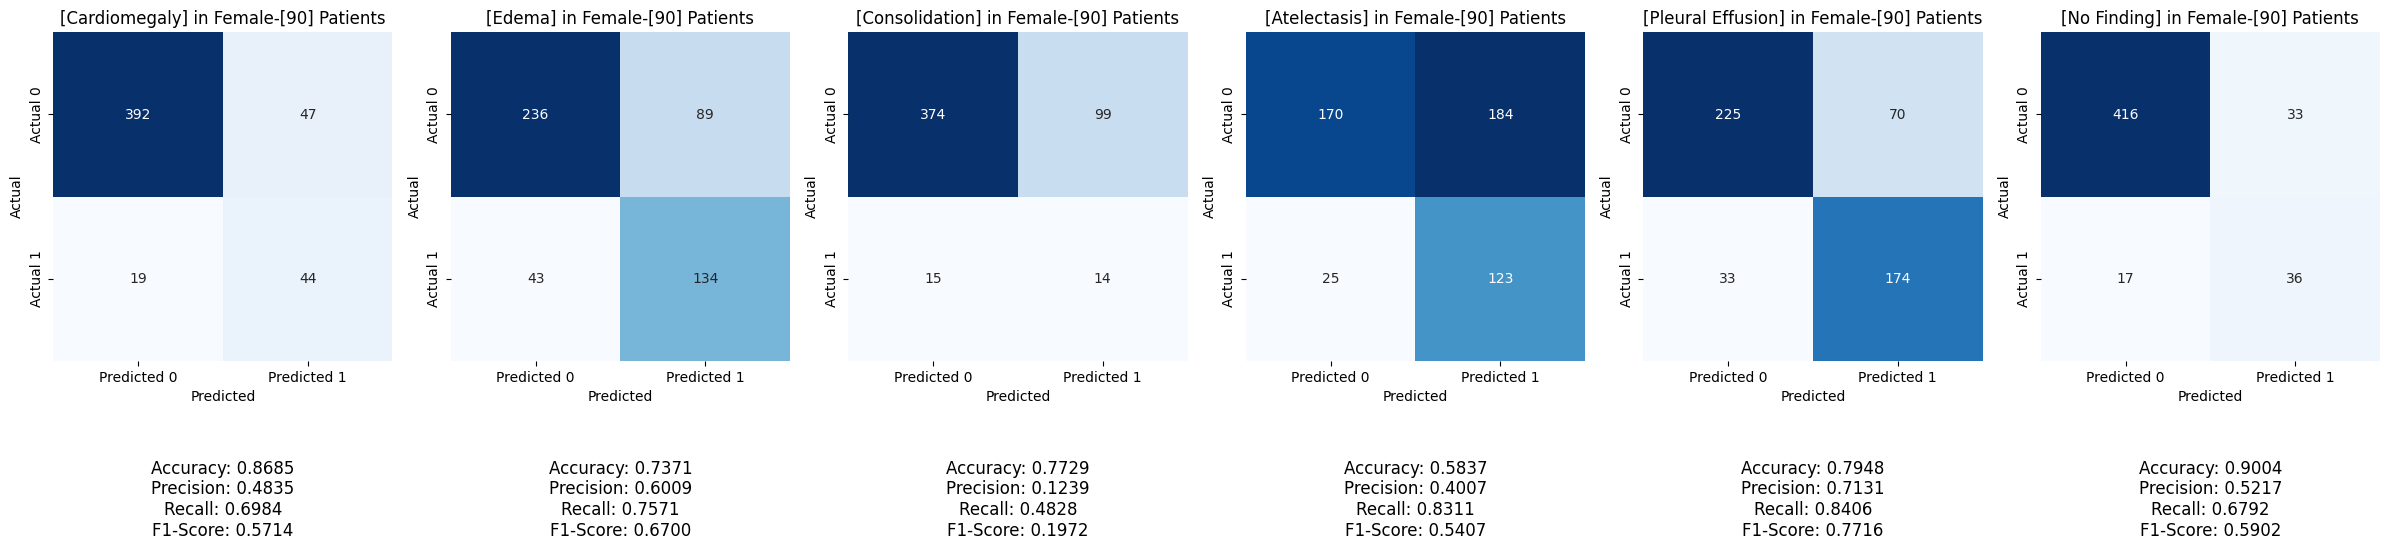

In [80]:
# ---------------------------------------------------------------------------- #
#                             PLOT confusion_matrix                            #
# ---------------------------------------------------------------------------- #
for AgeGroup in female_pp_groups:
    predicted_labels = apply_thresholds(female_pp_groups[AgeGroup], thresholds)
    print(f"AgeGroup: {AgeGroup}")
    plot_confusion_matrices(female_label_groups[AgeGroup], predicted_labels, f"Female-[{AgeGroup}]")

# plot_confusion_matrices(male_gtl, apply_thresholds(male_pp, find_best_threshold(male_pp, male_gtl)))

##### 📈📈[**'Female-AgeGroup'**] PLOT **ROC Curves**  


/local/home/rezajam/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_plot/roc_curve.py:171: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")
/local/home/rezajam/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_plot/roc_curve.py:171: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")
/local/home/rezajam/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_plot/roc_curve.py:171: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")
/local/home/rezajam/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_pl

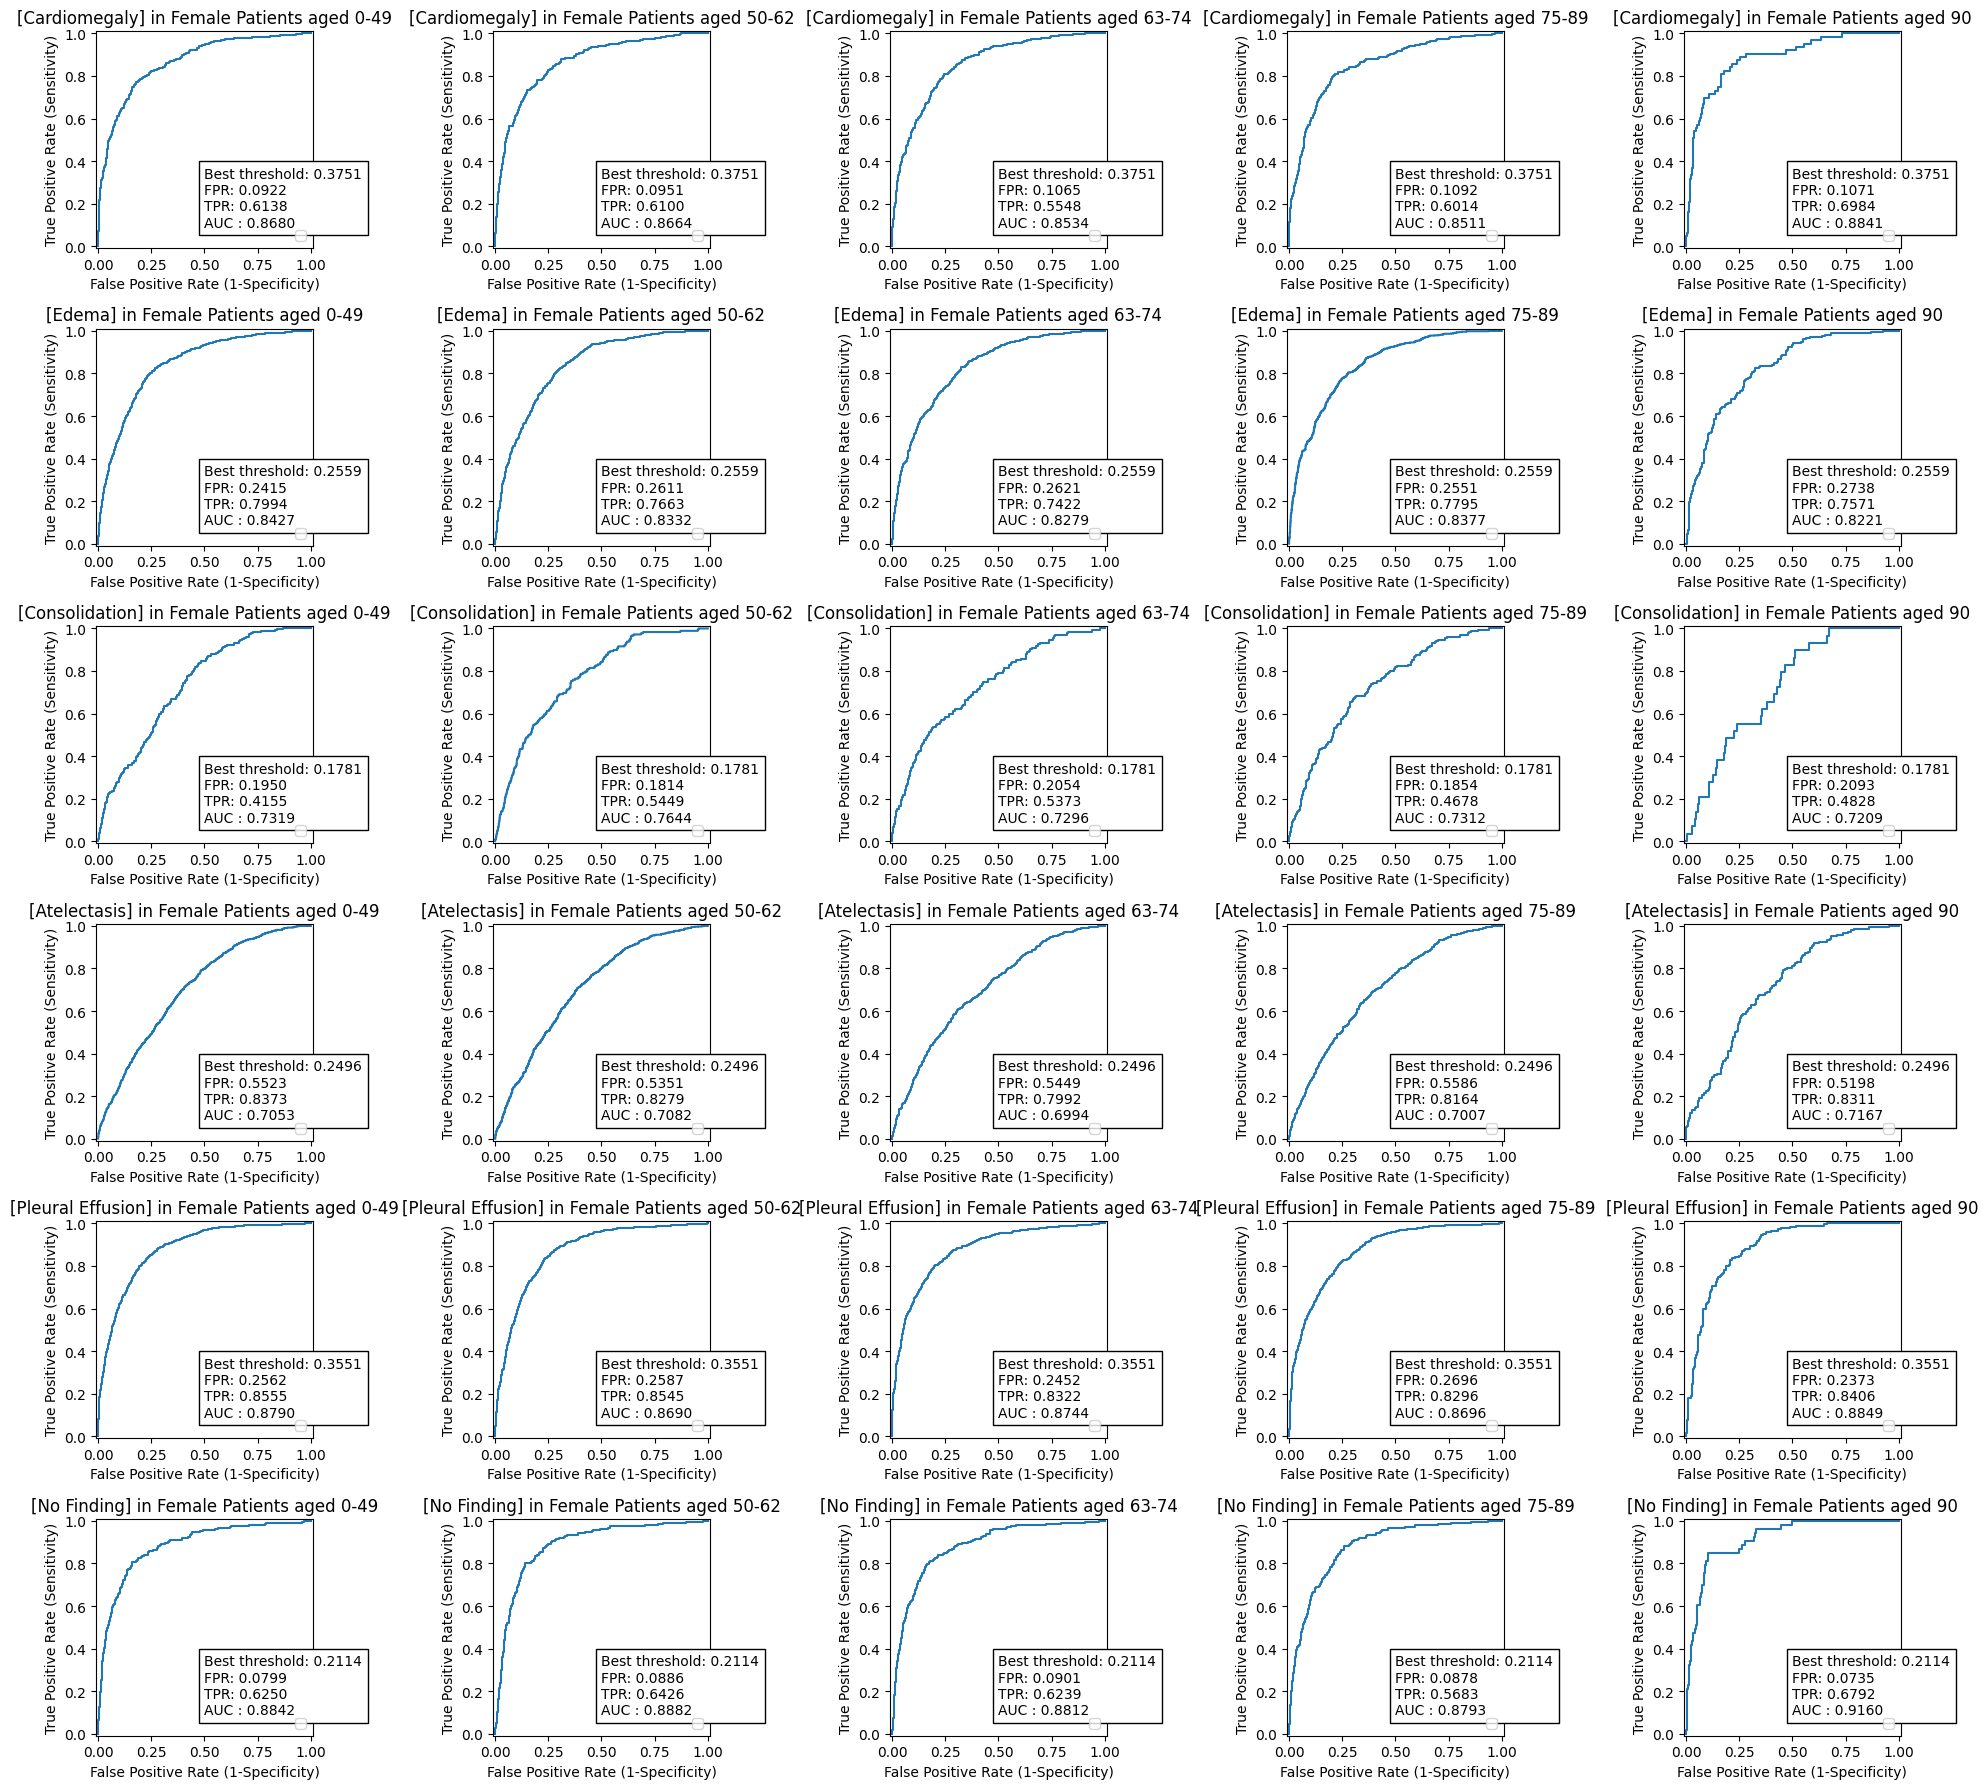

In [81]:
plot_roc_bigpicture(female_pp_groups,female_label_groups, 'Female')

### 📝[**'Male-AgeGroup'**] vs [**'Female-AgeGroup'**] Overall Evaluation  
- **Analysis Breakdown**:
  - **ROC Curves**: 6 (Number of Labels) × 2 (Genders) × 5 (Age Groups)
  - **Objective**: To assess model consistency and robustness by comparing performance metrics for male and female patients across matching age groups.

This approach allows for a comprehensive understanding of how model predictions vary across demographic segments, supporting a deeper analysis of potential model biases and highlighting areas for further refinement.

/local/home/rezajam/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_plot/roc_curve.py:171: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


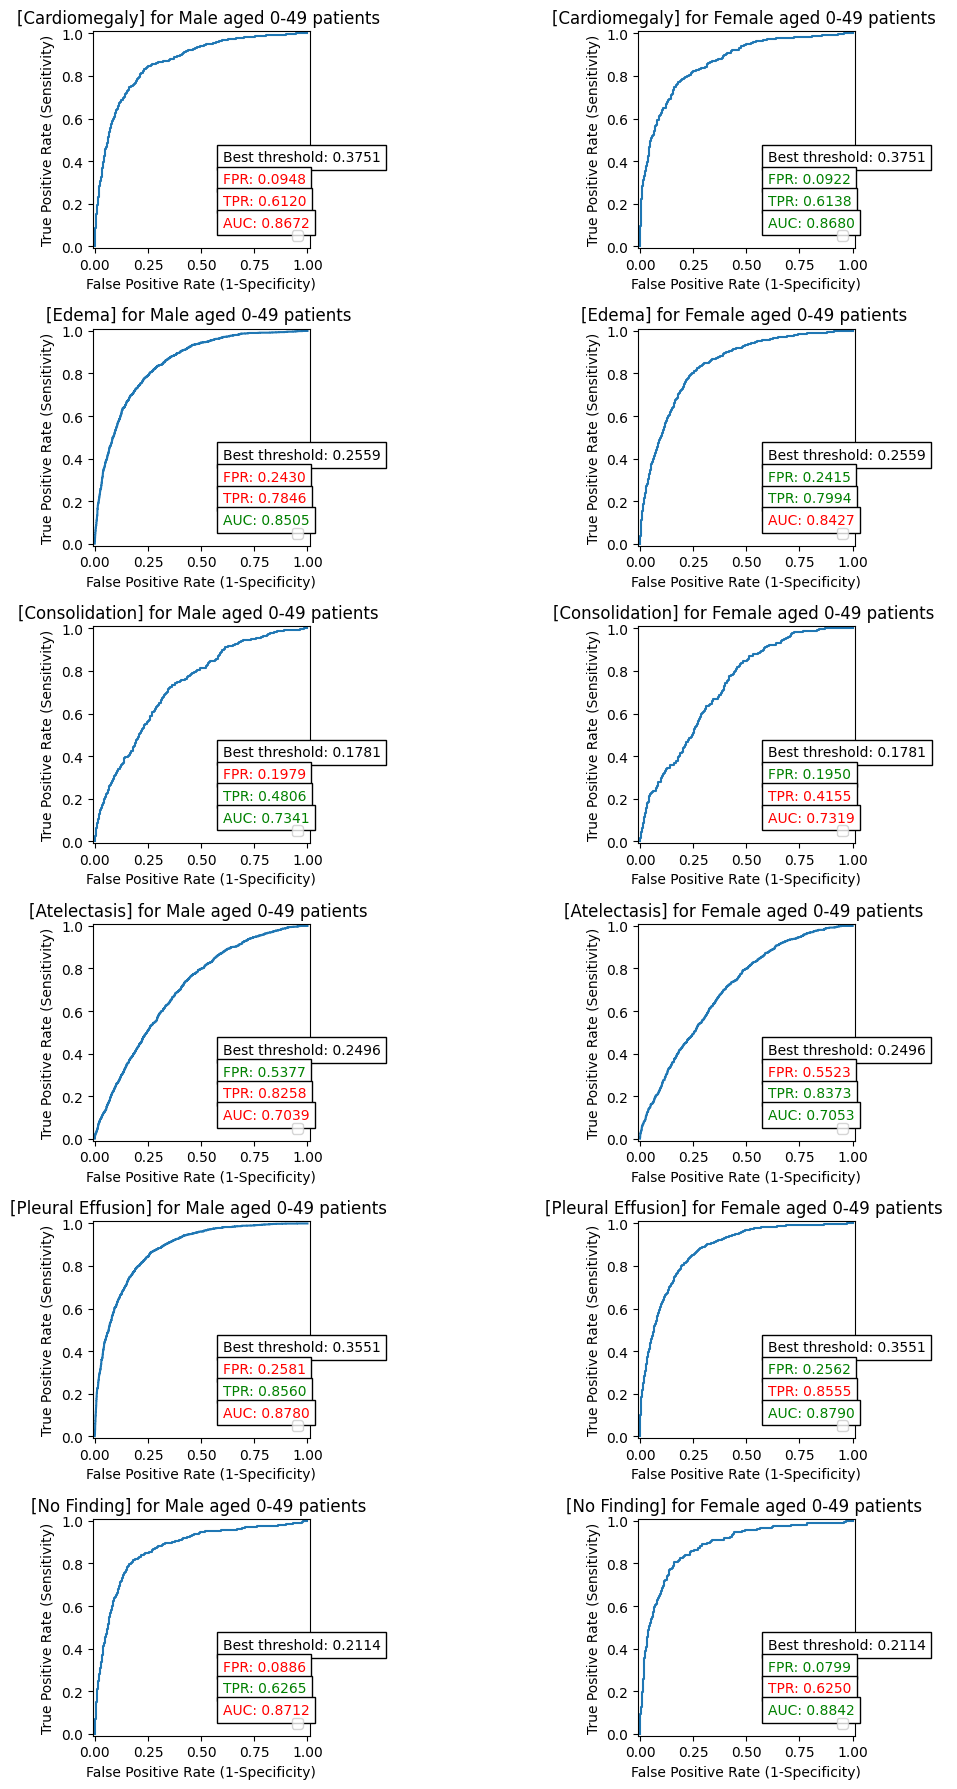

/local/home/rezajam/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_plot/roc_curve.py:171: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


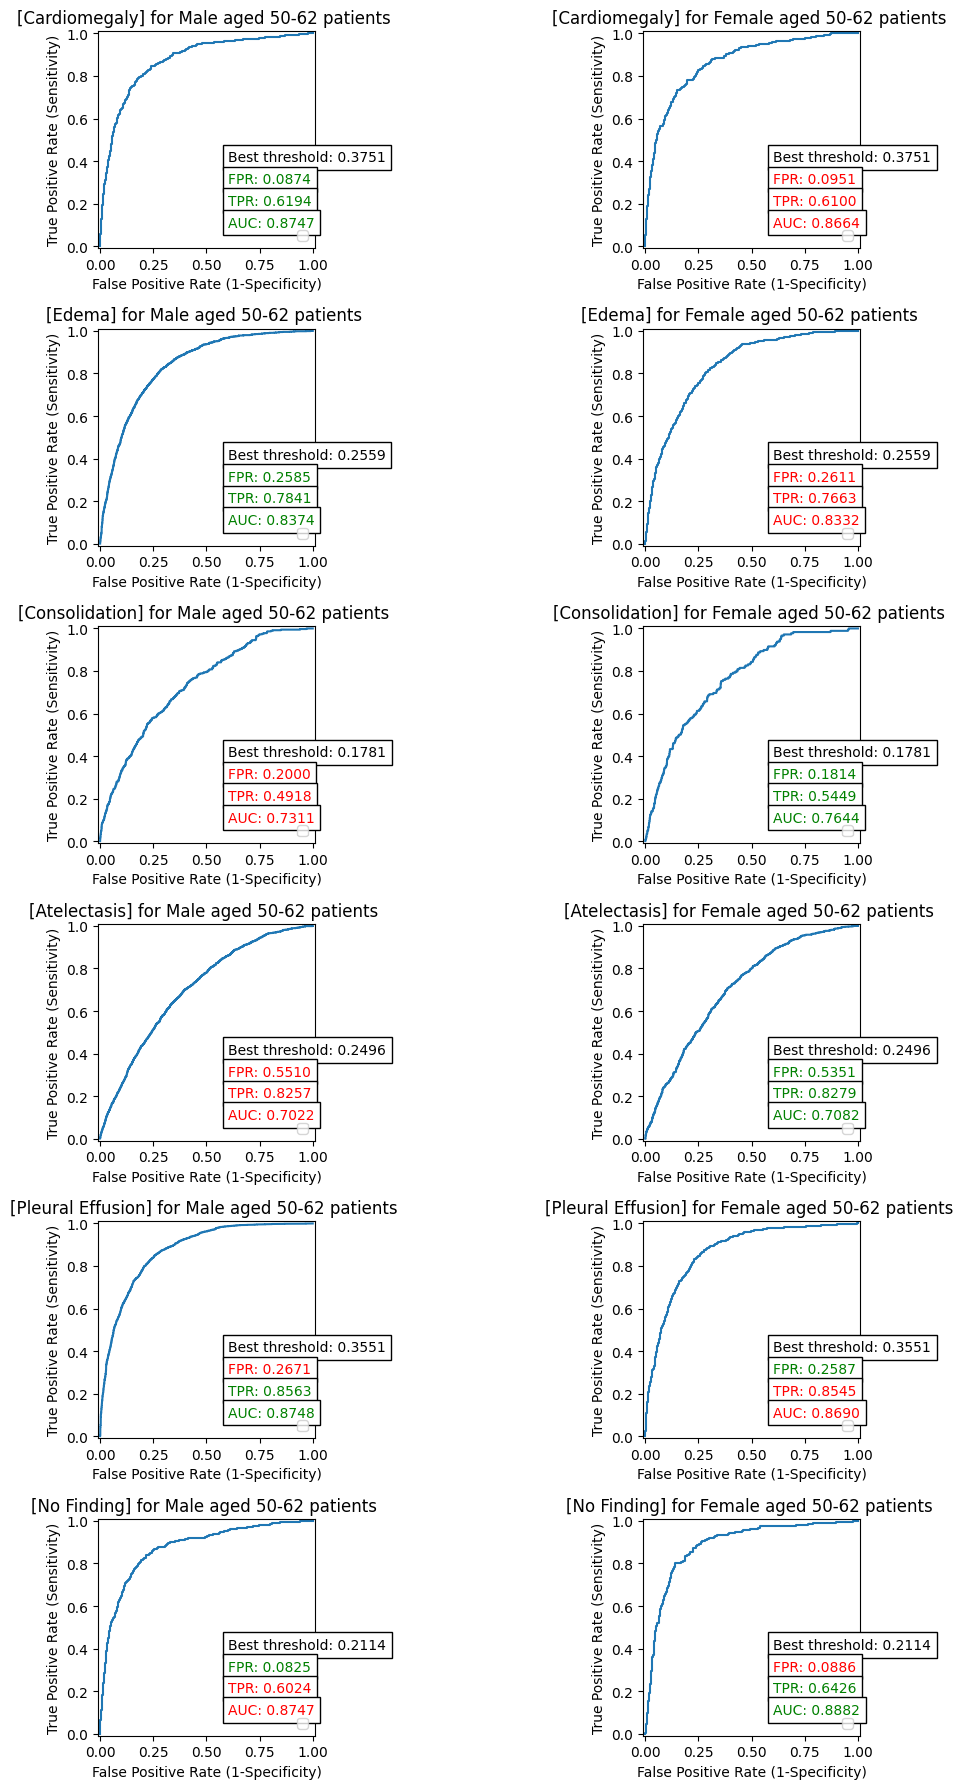

/local/home/rezajam/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_plot/roc_curve.py:171: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


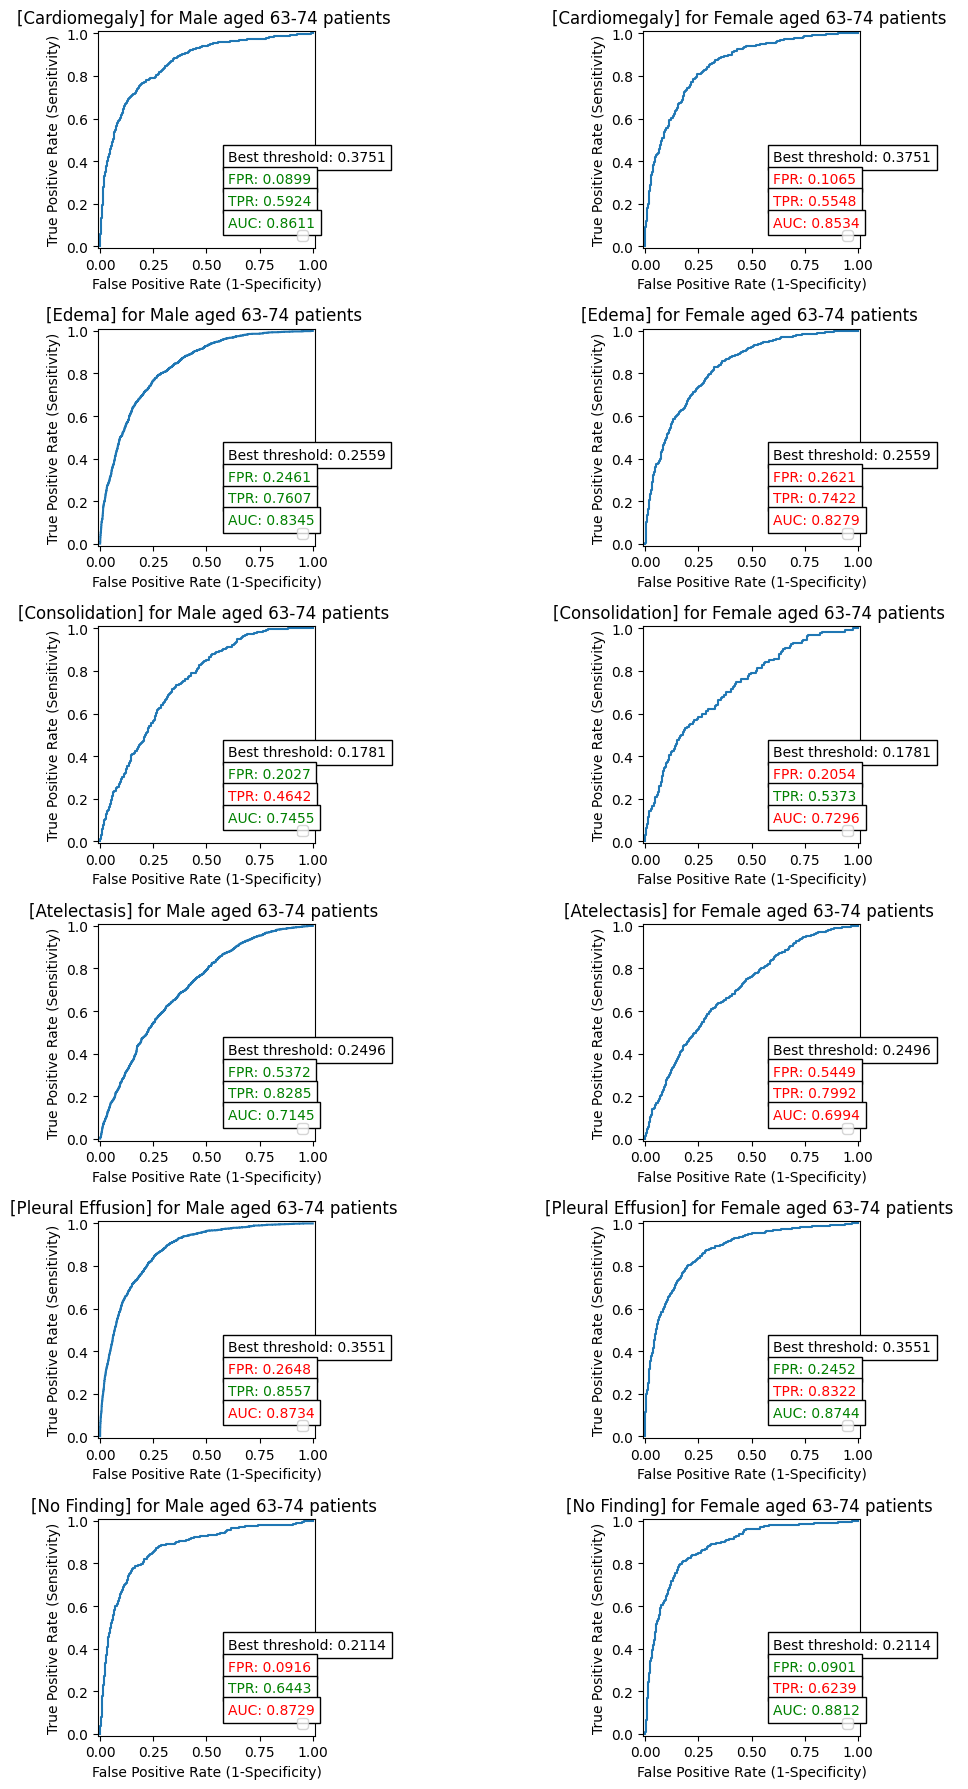

/local/home/rezajam/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_plot/roc_curve.py:171: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


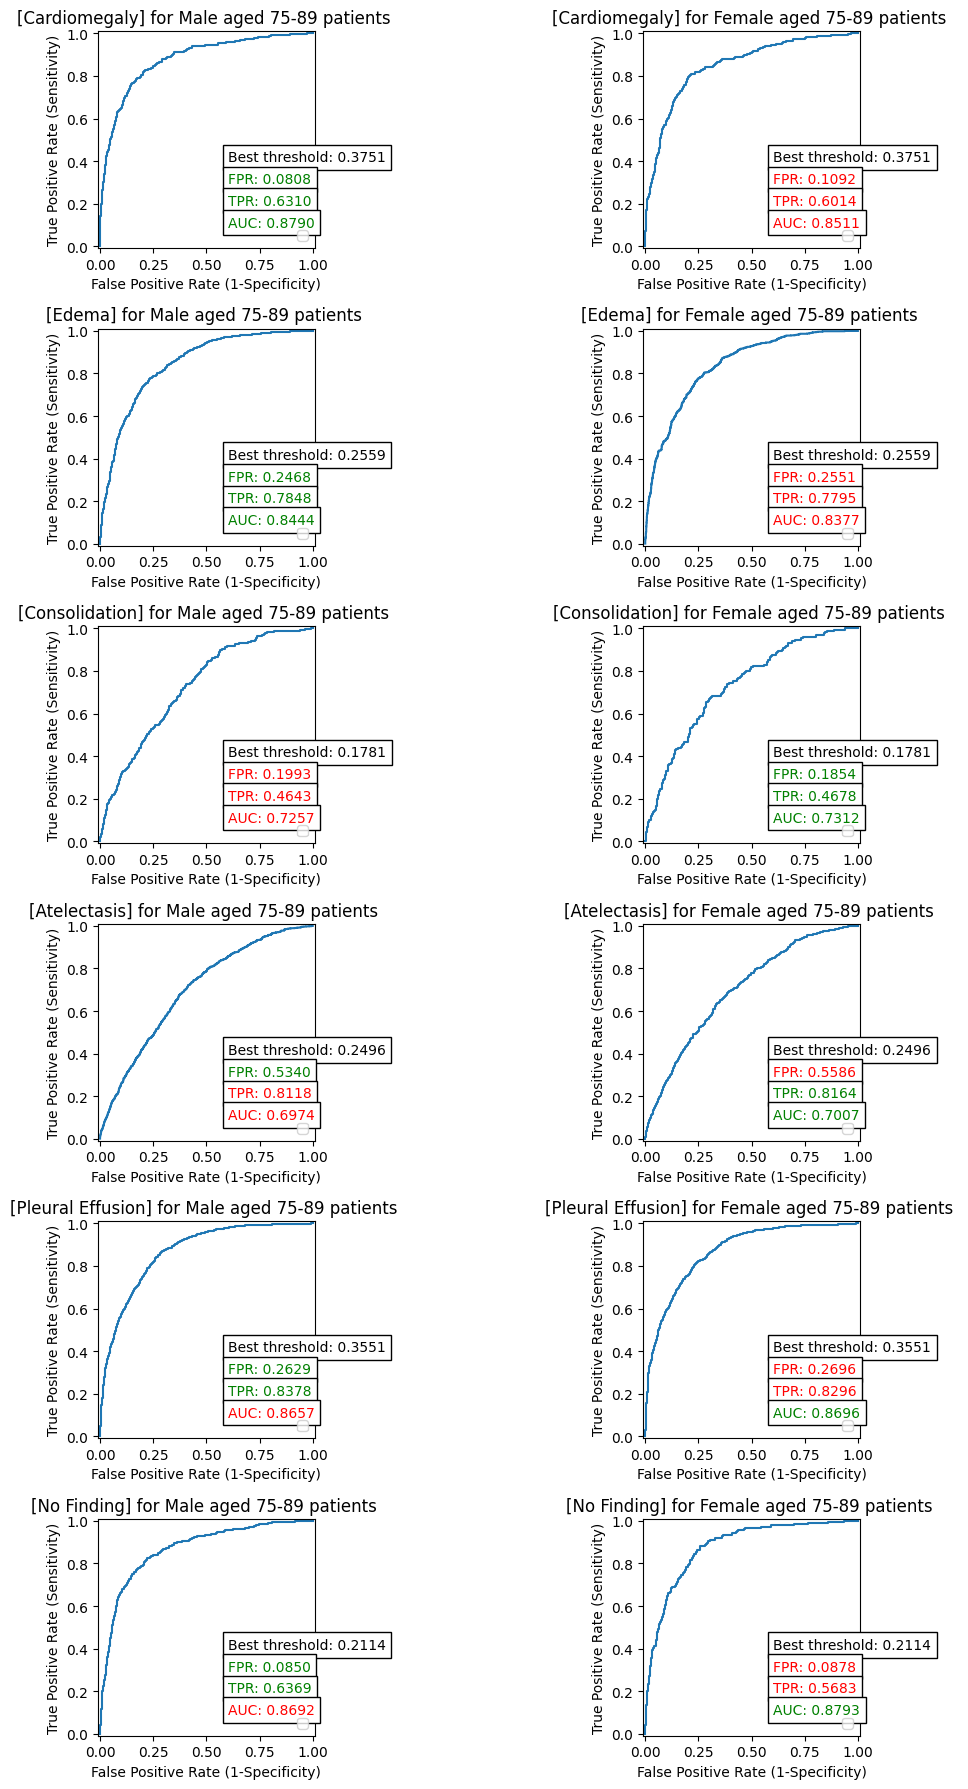

/local/home/rezajam/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_plot/roc_curve.py:171: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


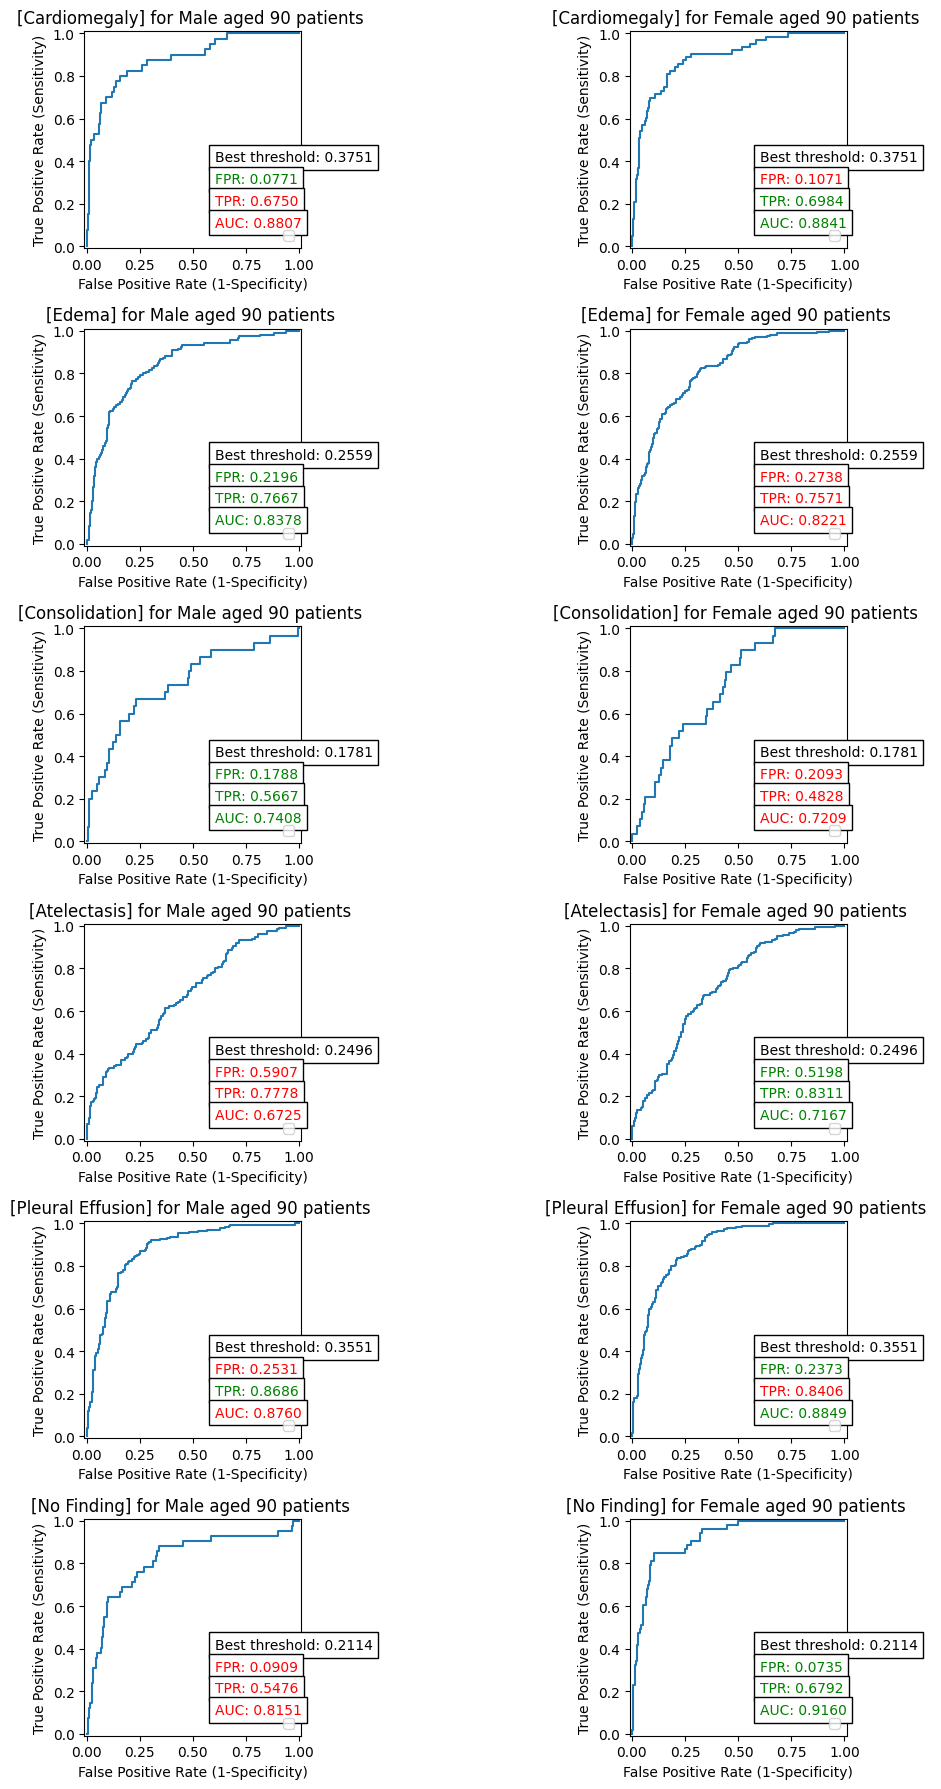

In [ ]:
for i in range(len(age_labels)):
    # plot_dual_aucs(fpr, tpr, fpr_overall, tpr_overall, AUC, fpr2, tpr2, fpr_overall2, tpr_overall2, AUC2, thresholds, threshold)
    fpr, tpr, fpr_overall, tpr_overall, AUC = fpr_tpr_auc(male_pp_groups[age_labels[i]], male_label_groups[age_labels[i]], thresholds)
    fpr2, tpr2, fpr_overall2, tpr_overall2, AUC2 = fpr_tpr_auc(female_pp_groups[age_labels[i]], female_label_groups[age_labels[i]], thresholds)

    compare_rocs_colored(fpr, tpr, fpr_overall, tpr_overall, AUC, fpr2, tpr2, fpr_overall2, tpr_overall2, AUC2, thresholds,f'Male aged {age_labels[i]}',f'Female aged {age_labels[i]}')